In [1]:
# System
import os
import sys
import logging
import multiprocessing as mp
from functools import partial
from collections import Counter

# Externals
import yaml
import pickle
import numpy as np
import pandas as pd
import trackml.dataset
import time
from torch_geometric.data import Data

def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi

def calc_eta(r, z):
    """Computes pseudorapidity
       (https://en.wikipedia.org/wiki/Pseudorapidity)
    """
    theta = np.arctan2(r, z)
    return -1. * np.log(np.tan(theta / 2.))

In [2]:
def select_edges(hits1, hits2, layer1, layer2, 
                 phi_slope_max, z0_max, module_map=[]):

    # start with all possible pairs of hits
    keys = ['evtid', 'r', 'phi', 'z', 'module_id']
    hit_pairs = hits1[keys].reset_index().merge(
        hits2[keys].reset_index(), on='evtid', suffixes=('_1', '_2'))

    # compute geometric features of the line through each hit pair
    dphi = calc_dphi(hit_pairs.phi_1, hit_pairs.phi_2)
    dz = hit_pairs.z_2 - hit_pairs.z_1
    dr = hit_pairs.r_2 - hit_pairs.r_1
    eta_1 = calc_eta(hit_pairs.r_1, hit_pairs.z_1)
    eta_2 = calc_eta(hit_pairs.r_2, hit_pairs.z_2)
    deta = eta_2 - eta_1
    dR = np.sqrt(deta**2 + dphi**2)
    
    # phi_slope and z0 used to filter spurious edges
    phi_slope = dphi / dr
    z0 = hit_pairs.z_1 - hit_pairs.r_1 * dz / dr
    
    # apply the intersecting line cut 
    intersected_layer = dr.abs() < -1 
    # 0th barrel layer to left EC or right EC
    if (layer1 == 0) and (layer2 == 11 or layer2 == 4): 
        z_coord = 71.56298065185547 * dz/dr + z0
        intersected_layer = np.logical_and(z_coord > -490.975, 
                                           z_coord < 490.975)
    # 1st barrel layer to the left EC or right EC
    if (layer1 == 1) and (layer2 == 11 or layer2 == 4): 
        z_coord = 115.37811279296875 * dz / dr + z0
        intersected_layer = np.logical_and(z_coord > -490.975, 
                                           z_coord < 490.975)
        
    # mask edges not in the module map
    mid1 = hit_pairs.module_id_1.values
    mid2 = hit_pairs.module_id_2.values
    in_module_map = module_map[mid1, mid2]

    # filter edges according to selection criteria
    good_edge_mask = ((phi_slope.abs() < phi_slope_max) & # geometric
                      (z0.abs() < z0_max) &               # geometric
                      (intersected_layer == False)) #&      # geometric
                      # (in_module_map))                    # data-driven
    
    # store edges (in COO format) and geometric edge features 
    selected_edges = {'edges': hit_pairs[['index_1', 'index_2']][good_edge_mask],
                      'dr': dr[good_edge_mask],    
                      'dphi': dphi[good_edge_mask], 
                      'dz': dz[good_edge_mask],
                      'dR': dR[good_edge_mask]}
    
    return selected_edges 

In [3]:
def check_truth_labels(hits, edges, y, particle_ids):
    """ Corrects for extra edges surviving the barrel intersection
        cut, i.e. for each particle counts the number of extra 
        "transition edges" crossing from a barrel layer to an 
        innermost endcap slayer; the sum is n_incorrect
        - [edges] = n_edges x 2
        - [y] = n_edges
        - [particle_ids] = n_edges
    """
    # layer indices for barrel-to-endcap edges
    barrel_to_endcaps = {(0,4), (1,4), (2,4),    # barrel to l-EC
                         (0,11), (1,11), (2,11)} # barrel to r-EC
    
    # group hits by particle id, get layer indices
    hits_by_particle = hits.groupby('particle_id')
    layers_1 = hits.layer.loc[edges.index_1].values
    layers_2 = hits.layer.loc[edges.index_2].values

    # loop over particle_id, particle_hits, 
    # count extra transition edges as n_incorrect
    n_incorrect = 0
    for p, particle_hits in hits_by_particle:
        particle_hit_ids = particle_hits['hit_id'].values
        
        # grab true segment indices for particle p
        relevant_indices = ((particle_ids==p) & (y==1))
        
        # get layers connected by particle's edges
        particle_l1 = layers_1[relevant_indices]
        particle_l2 = layers_2[relevant_indices]
        layer_pairs = set(zip(particle_l1, particle_l2))
        
        # count the number of transition edges
        transition_edges = layer_pairs.intersection(barrel_to_endcaps)
        if (len(transition_edges) > 1):
            n_incorrect += 1
            
    if (n_incorrect > 0):
        logging.info(f'incorrectly-labeled edges: {n_incorrect}')
    
    return n_incorrect

In [4]:
def construct_graph(hits, layer_pairs, phi_slope_max, z0_max,
                    feature_names, feature_scale, evtid="-1",
                    module_maps={}, s=(-1,-1)):
    """ Loops over hits in layer pairs and extends edges
        between them based on geometric and/or data-driven
        constraints. 
    """
    # loop over layer pairs, assign edges between their hits
    groups = hits.groupby('layer')
    edges, dr, dphi, dz, dR = [], [], [], [], []
    for (layer1, layer2) in layer_pairs:
        module_map = module_maps[(layer1, layer2)]
        try:
            hits1 = groups.get_group(layer1)
            hits2 = groups.get_group(layer2)
        except KeyError as e: # skip if layer is empty
            continue
            
        # assign edges based on geometric and data-driven constraints
        selected_edges = select_edges(hits1, hits2, layer1, layer2,
                                      phi_slope_max, z0_max,  # geometric 
                                      module_map=module_map)  # data-driven
        edges.append(selected_edges['edges'])
        dr.append(selected_edges['dr'])
        dphi.append(selected_edges['dphi'])
        dz.append(selected_edges['dz'])
        dR.append(selected_edges['dR'])
    
    # if edges were reconstructed, concatenate edge 
    # attributes and indices across all layer pairs 
    if len(edges) > 0:
        edges = pd.concat(edges)
        dr, dphi = pd.concat(dr), pd.concat(dphi)
        dz, dR = pd.concat(dz), pd.concat(dR)
    else: # if no edges were reconstructed, return empty graph 
        edges = np.array([])
        dr, dphi = np.array([]), np.array([])
        dz, dR = np.array([]), np.array([])
        x = (hits[feature_names].values / feature_scale).astype(np.float32)
        return {'x': x, 'hit_id': hits['hit_id'],
                'edge_index': np.array([[],[]]),
                'edge_attr': np.array([[],[],[],[]]),
                'y': [], 's': s, 'n_incorrect': 0}
    
    # prepare the graph matrices
    n_nodes = hits.shape[0]
    n_edges = edges.shape[0]
    
    # select and scale relevant features
    x = (hits[feature_names].values / feature_scale).astype(np.float32)
    edge_attr = np.stack((dr/feature_scale[0], 
                          dphi/feature_scale[1], 
                          dz/feature_scale[2], 
                          dR))
    y = np.zeros(n_edges, dtype=np.float32)

    # use a series to map hit label-index onto positional-index.
    node_idx = pd.Series(np.arange(n_nodes), index=hits.index)
    edge_start = node_idx.loc[edges.index_1].values
    edge_end = node_idx.loc[edges.index_2].values
    edge_index = np.stack((edge_start, edge_end))

    # fill the edge, particle labels
    # true edges have the same pid, ignore noise (pid=0)
    pid1 = hits.particle_id.loc[edges.index_1].values
    pid2 = hits.particle_id.loc[edges.index_2].values
    y[:] = ((pid1 == pid2) & (pid1>0) & (pid2>0)) 
    n_incorrect = check_truth_labels(hits, edges, y, pid1)
    
    return {'x': x, 'hit_id': hits['hit_id'],
            'edge_index': edge_index, 'edge_attr': edge_attr, 
            'y': y, 's': s, 'n_incorrect': n_incorrect}

In [5]:
def select_hits(hits, truth, particles, pt_min=0, endcaps=False, 
                remove_noise=False, remove_duplicates=False):
     
    # Barrel volume and layer ids
    vlids = [(8,2), # 0 
             (8,4), # 1
             (8,6), # 2
             (8,8)] # 3
    if (endcaps): 
        vlids.extend([(7,14), # 4 
                      (7,12), # 5
                      (7,10), # 6
                      (7,8),  # 7
                      (7,6),  # 8
                      (7,4),  # 9
                      (7,2),  # 10
                      (9,2),  # 11
                      (9,4),  # 12
                      (9,6),  # 13
                      (9,8),  # 14
                      (9,10), # 15
                      (9,12), # 16
                      (9,14), # 17
                     ])
    n_det_layers = len(vlids)
    
    # Select barrel layers and assign convenient layer number [0-9]
    vlid_groups = hits.groupby(['volume_id', 'layer_id'])
    hits = pd.concat([vlid_groups.get_group(vlids[i]).assign(layer=i)
                      for i in range(n_det_layers)])
    
    # Calculate particle transverse momentum
    particles['pt'] = np.sqrt(particles.px**2 + particles.py**2)
    particles['eta_pt'] = calc_eta(particles.pt, particles.pz)
    
    # True particle selection.
    particles = particles[particles.pt > pt_min]
    truth_noise = truth[['hit_id', 'particle_id']][truth.particle_id==0]
    truth_noise['pt'] = 0
    truth = (truth[['hit_id', 'particle_id']]
             .merge(particles[['particle_id', 'pt', 'eta_pt']], on='particle_id'))

    # optionally add noise 
    if (not remove_noise): 
        truth = truth.append(truth_noise)

    # calculate derived hits variables
    hits['r'] = np.sqrt(hits.x**2 + hits.y**2)
    hits['phi'] = np.arctan2(hits.y, hits.x)
    hits['eta'] = calc_eta(hits.r, hits.z)
    
    # select the data columns we need
    hits = (hits[['hit_id', 'r', 'phi', 'eta', 'z', 'layer', 'module_id']]
            .merge(truth[['hit_id', 'particle_id', 'pt', 'eta_pt']], on='hit_id'))
    
    # optionally remove duplicates
    if (remove_duplicates):
        noise_hits = hits[hits.particle_id==0]
        particle_hits = hits[hits.particle_id!=0]
        particle_hits = particle_hits.loc[particle_hits.groupby(['particle_id', 'layer']).r.idxmin()]
        hits = particle_hits.append(noise_hits)
        
    # relabel particle IDs in [1:n_particles]
    particles = particles[particles.particle_id.isin(pd.unique(hits.particle_id))]
    particle_id_map = {p: i+1 for i, p in enumerate(particles['particle_id'].values)}
    particle_id_map[0] = 0
    particles = particles.assign(particle_id=particles['particle_id'].map(particle_id_map))
    hits = hits.assign(particle_id=hits['particle_id'].map(particle_id_map))
    return hits, particles

In [6]:
def get_particle_properties(hits_by_particle, valid_connections, debug=False):
    """ Calculates the following truth quantities per particle:
         - n_track_segs: number of track segments generated
         - reconstructable: true if particle doesn't skip a layer
         - pt: particle transverse momentum [GeV]
         - eta: pseudorapidity w.r.t. transverse and longitudinal momentum
    """
    # loop over particle_ids and corresponding particle hits
    n_track_segs, reconstructable = {}, {}
    pt, eta = {}, {}
    for particle_id, particle_hits in hits_by_particle:
        
        # noise isn't reconstructable, store 0s
        if (particle_id==0): 
            reconstructable[particle_id] = 0
            pt[particle_id] = 0
            eta[particle_id] = 0
            n_track_segs[particle_id] = 0
            continue
            
        # store pt and eta 
        pt[particle_id] = particle_hits.pt.values[0]
        eta[particle_id] = particle_hits.eta_pt.values[0]
        
        # store hit multiplicity per layer 
        layers_hit = particle_hits.layer.values
        hits_per_layer = Counter(layers_hit) 
        layers = np.unique(layers_hit)
        
        # single-hits aren't reconstructable
        if (len(layers)==1): 
            reconstructable[particle_id] = 0
            n_track_segs[particle_id] = 0
            continue
        
        # all edges must be valid for a reconstructable particle
        layer_pairs = set(zip(layers[:-1], layers[1:]))
        reconstructable[particle_id] = layer_pairs.issubset(valid_connections)
        
        # total number of track segments produced by particle 
        good_layer_pairs = layer_pairs.intersection(valid_connections)
        count = 0
        for good_lp in good_layer_pairs:
            count += hits_per_layer[good_lp[0]] * hits_per_layer[good_lp[1]]
        n_track_segs[particle_id] = count
        
        if debug and (particle_id%100==0):
            print('Test Hit Pattern:', layers_hit)
            print(' - layer pairs:', layer_pairs)
            print(' - reconstructable:', reconstructable[particle_id])
            print(' - n_track_segs:', n_track_segs[particle_id])
            print(' - pt', pt[particle_id])
            print(' - eta', eta[particle_id])
        
    return {'pt': pt, 'eta': eta, 'n_track_segs': n_track_segs, 
            'reconstructable': reconstructable}

In [7]:
def get_n_track_segs(hits_by_particle, valid_connections):
    """ Calculates the number of track segments present in 
        a subset of hits generated by a particle
        (used for analyzing efficiency per sector)
    """
    # loop over particle_ids and corresponding particle hits
    n_track_segs = {}
    for particle_id, particle_hits in hits_by_particle:
        
        # noise doesn't produce true edges
        if (particle_id==0): 
            n_track_segs[particle_id] = 0
            continue
            
        # store hit multiplicity per layer 
        layers_hit = particle_hits.layer.values
        hits_per_layer = Counter(layers_hit) 
        layers = np.unique(layers_hit)
        
        # single-hits don't produce truth edges
        if (len(layers)==1): 
            n_track_segs[particle_id] = 0
            continue
        
        # all edges must be valid for a reconstructable particle
        layer_pairs = set(zip(layers[:-1], layers[1:]))
        
        # total number of true edges produced by particle 
        good_layer_pairs = layer_pairs.intersection(valid_connections)
        count = 0
        for good_lp in good_layer_pairs:
            count += hits_per_layer[good_lp[0]] * hits_per_layer[good_lp[1]]
        n_track_segs[particle_id] = count
        
    return n_track_segs

In [8]:
def split_detector_sectors(hits, phi_edges, eta_edges, verbose=False):
    """Split hits according to provided phi and eta boundaries."""
    hits_sectors = {}
    sector_info = {}
    phi_overlap, eta_overlap = 0, 0
    for i in range(len(phi_edges) - 1):
        phi_min, phi_max = phi_edges[i], phi_edges[i+1]
        # Select hits in this phi sector
        phi_hits = hits[((hits.phi > (phi_min-phi_overlap)) & 
                          (hits.phi < (phi_max+phi_overlap)))]
        # Center these hits on phi=0
        centered_phi = phi_hits.phi - (phi_min + phi_max) / 2
        phi_hits = phi_hits.assign(phi=centered_phi, phi_sector=i)
        for j in range(len(eta_edges) - 1):
            eta_min, eta_max = eta_edges[j], eta_edges[j+1]
            # Select hits in this eta sector
            eta = calc_eta(phi_hits.r, phi_hits.z)
            sec_hits = phi_hits[((eta > (eta_min-eta_overlap)) & 
                                 (eta < (eta_max+eta_overlap)))]
            
            # label hits by tuple s = (eta_sector, phi_sector)
            hits_sectors[(j,i)] = sec_hits.assign(eta_sector=j)
                         
            # store eta and phi ranges per sector
            sector_info[(j,i)] = {'eta_range': [eta_min, eta_max],
                                  'phi_range': [phi_min, phi_max]}
            if verbose:
                logging.info(f"Sector ({i},{j}):\n" + 
                             f"...eta_range=({eta_min:.3f},{eta_max:.3f})\n"
                             f"...phi_range=({phi_min:.3f},{phi_max:.3f})")
    
    return hits_sectors, sector_info

In [9]:
def graph_summary(evtid, sectors, particle_properties, 
                  sector_info, print_per_layer=False):
    """ Calculates per-sector and per-graph summary stats
        and returns a dictionary for subsequent analysis
         - total_track_segs: # track segments (true edges) possible 
         - total_nodes: # nodes present in graph / sector
         - total_edges: # edges present in graph / sector
         - total_true: # true edges present in graph / sector
         - total_false # false edges present in graph / sector
         - boundary_fraction: fraction of track segs lost between sectors
         
    """
   
    # truth number of track segments possible
    track_segs = particle_properties['n_track_segs'].values()
    total_track_segs = np.sum(list(track_segs))
    total_track_segs_sectored = 0
    
    # reconstructed quantities per graph
    total_nodes, total_edges = 0, 0
    total_true, total_false = 0, 0

    # helper function for division by 0
    def div(a,b):
        return float(a)/b if b else 0
    
    # loop over graph sectors and compile statistics
    sector_stats = {}
    total_possible_per_s = 0
    for i, sector in enumerate(sectors):
        
        # get information about the graph's sector
        s = sector['s'] # s = sector label
        sector_ranges = sector_info[s]
        
        # calculate graph properties
        n_nodes = sector['x'].shape[0]
        total_nodes += n_nodes
        # correct n_edges for multiple transition edges
        # (see check_truth_labels()) 
        n_true = np.sum(sector['y']) - sector['n_incorrect']
        total_true += n_true
        n_false = np.sum(sector['y']==0)
        total_false += n_false
        n_edges = len(sector['y'])
        total_edges += n_edges
        
        # calculate track segments in sector
        n_track_segs_per_pid = particle_properties['n_track_segs_per_s'][s]
        n_track_segs = np.sum(list(n_track_segs_per_pid.values()))
        total_track_segs_sectored += n_track_segs
        
        # estimate purity in each sector
        sector_stats[i] = {'eta_range': sector_ranges['eta_range'],
                           'phi_range': sector_ranges['phi_range'],
                           'n_nodes': n_nodes, 'n_edges': n_edges,
                           'purity': div(n_true, n_edges),
                           'efficiency': div(n_true, n_track_segs)}
        
    # proportion of true edges to all possible track segments
    efficiency = div(total_true, total_track_segs)
    # proportion of true edges to total reconstructed edges
    purity = div(total_true, total_edges)
    # proportion of true track segments lost in sector boundaries
    boundary_fraction = div(total_track_segs - total_track_segs_sectored, 
                            total_track_segs)
    
    logging.info(f'Event {evtid}, graph summary statistics\n' + 
                 f'...total nodes: {total_nodes}\n' +
                 f'...total edges: {total_edges}\n' + 
                 f'...efficiency: {efficiency:.5f}\n' +
                 f'...purity: {purity:.5f}\n'
                 f'...boundary edge fraction: {boundary_fraction:.5f}')

    return {'n_nodes': total_nodes, 'n_edges': total_edges,
            'efficiency': efficiency, 'purity': purity,
            'boundary_fraction': boundary_fraction,
            'sector_stats': sector_stats}

In [10]:
def process_event(prefix, output_dir, module_maps, pt_min, 
                  n_eta_sectors, n_phi_sectors,
                  eta_range, phi_range, phi_slope_max, z0_max,
                  endcaps, remove_noise, remove_duplicates):
    
    # define valid layer pair connections
    layer_pairs = [(0,1), (1,2), (2,3)] # barrel-barrel
    if endcaps:
        layer_pairs.extend([(0,4), (1,4), (2,4),  # barrel-LEC
                            (0,11), (1,11), (2,11), # barrel-REC
                            (4,5), (5,6), (6,7), # LEC-LEC
                            (7,8), (8,9), (9,10), 
                            (11,12), (12,13), (13,14), # REC-REC
                            (14,15), (15,16), (16,17)])
                                 
    # load the data
    evtid = int(prefix[-9:])
    logging.info('Event %i, loading data' % evtid)
    hits, particles, truth = trackml.dataset.load_event(
        prefix, parts=['hits', 'particles', 'truth'])

    # apply hit selection
    logging.info('Event %i, selecting hits' % evtid)
    hits, particles = select_hits(hits, truth, particles, pt_min, endcaps, 
                                  remove_noise, remove_duplicates)
    hits = hits.assign(evtid=evtid)
    
    # get truth information for each particle
    hits_by_particle = hits.groupby('particle_id')
    particle_properties = get_particle_properties(hits_by_particle,
                                                  set(layer_pairs), debug=False)
    hits = hits[['hit_id', 'r', 'phi', 'eta', 'z', 'evtid',
                 'layer', 'module_id', 'particle_id']]
    
    # divide detector into sectors
    phi_edges = np.linspace(*phi_range, num=n_phi_sectors+1)
    eta_edges = np.linspace(*eta_range, num=n_eta_sectors+1)
    hits_sectors, sector_info = split_detector_sectors(hits, phi_edges, eta_edges)
    
    # calculate particle truth in each sector
    n_track_segs_per_s = {}
    for s, hits_sector in hits_sectors.items():
        hits_sector_by_particle = hits_sector.groupby('particle_id')
        n_track_segs_s = get_n_track_segs(hits_sector_by_particle, set(layer_pairs))
        n_track_segs_per_s[s] = n_track_segs_s
    particle_properties['n_track_segs_per_s'] = n_track_segs_per_s
    
    # graph features and scale
    feature_names = ['r', 'phi', 'z']
    feature_scale = np.array([1000., np.pi / n_phi_sectors, 1000.])

    # Construct the graph
    logging.info('Event %i, constructing graphs' % evtid)
    sectors = [construct_graph(sector_hits, layer_pairs=layer_pairs,
                               phi_slope_max=phi_slope_max, z0_max=z0_max,
                               s=s, feature_names=feature_names,
                               feature_scale=feature_scale,
                               evtid=evtid, module_maps=module_maps)
               for s, sector_hits in hits_sectors.items()]

    logging.info('Event %i, calculating graph summary' % evtid)
    summary_stats = graph_summary(evtid, sectors, particle_properties,
                                  sector_info, print_per_layer=False)
    
    # Write these graphs to the output directory
    #try:
    #    base_prefix = os.path.basename(prefix)
    #    filenames = [os.path.join(output_dir, '%s_g%03i' % (base_prefix, i))
    #                 for i in range(len(graphs))]
    #except Exception as e:
    #    logging.info(e)
    #
    #logging.info('Event %i, writing graphs', evtid)    
    #for graph, filename in zip(graphs, filenames):
    #    np.savez(filename, ** dict(x=graph.x, edge_attr=graph.edge_attr,
    #                               edge_index=graph.edge_index, 
    #                               y=graph.y, pid=graph.pid, pt=graph.pt, eta=graph.eta))
        
    output = {'sectors': sectors, 
              'particle_properties': particle_properties,
              'summary_stats': summary_stats}
    
    return output

In [11]:
# main method
pt_map = {0: '0p0', 0.5: '0p5', 0.6: '0p6', 0.7: '0p7', 0.8: '0p8', 0.9: '0p9',
          1: '1', 1.1: '1p1', 1.2: '1p2', 1.3: '1p3', 1.4: '1p4', 1.5: '1p5', 
          1.6: '1p6', 1.7: '1p7', 1.8: '1p8', 1.9: '1p9', 2.0: '2'}

input_dir = '/tigress/jdezoort/train_1'
output_dir = '/scratch/gpfs/jdezoort/gnns-for-tracking'
module_map_dir = '/scratch/gpfs2/jdezoort/reorganize_IN_paper_repo/interaction_network_paper/graph_construction/module_maps'
n_files = 1770
evtid_range = [1000,1050]
verbose = False
task = 0
n_tasks = 1
n_workers = 10
config = {'pt_min': 2, # GeV,
          'phi_slope_max': 0.0006,
          'z0_max': 15000,
          'n_phi_sectors': 8,
          'n_eta_sectors': 2,
          'eta_range': [-5, 5],
          'endcaps': True,
          'remove_noise': True, 
          'remove_duplicates': True,
         }
pt_str = pt_map[config['pt_min']]

# Setup logging
log_format = '%(asctime)s %(levelname)s %(message)s'
log_level = logging.DEBUG if verbose else logging.INFO
logging.basicConfig(level=log_level, format=log_format)
logging.info('Initializing')

# Find the input files
all_files = os.listdir(input_dir)
suffix = '-hits.csv'
file_prefixes = sorted(os.path.join(input_dir, f.replace(suffix, ''))
                       for f in all_files if f.endswith(suffix))
file_prefixes = file_prefixes[:n_files]
evtids = [int(prefix[-9:]) for prefix in file_prefixes]
if (evtid_range[0] < np.min(evtids)): evtid_range[0] = np.min(evtids)
if (evtid_range[1] > np.max(evtids)): evtid_range[1] = np.max(evtids)

# Take only files in a prespecified range 
file_prefixes = [prefix for prefix in file_prefixes
                 if ((int(prefix.split("00000")[1]) >= evtid_range[0]) and
                     (int(prefix.split("00000")[1]) <= evtid_range[1]))]

# Split the input files by number of tasks and select my chunk only
file_prefixes = np.array_split(file_prefixes, n_tasks)[task]

# Load module maps
module_maps = np.load(f"{module_map_dir}/module_map_2_1GeV.npy", 
                      allow_pickle=True).item()
#module_maps = np.load(f"{module_map_dir}/module_map_2_{pt_str}GeV.npy", 
#                      allow_pickle=True).item()
module_maps = {key: item.astype(bool) for key, item in module_maps.items()}

with mp.Pool(processes=n_workers) as pool:
    process_func = partial(process_event, output_dir=output_dir,
                           phi_range=(-np.pi, np.pi), 
                           module_maps=module_maps,
                           **config)
    output = pool.map(process_func, file_prefixes)
    
# analyze output statistics
logging.info('All done!')
graph_sectors = [graph['sectors'] for graph in output]
output = [graph['summary_stats'] for graph in output]
n_nodes = np.array([graph_stats['n_nodes'] for graph_stats in output])
n_edges = np.array([graph_stats['n_edges'] for graph_stats in output])
purity = np.array([graph_stats['purity'] for graph_stats in output])
efficiency = np.array([graph_stats['efficiency'] for graph_stats in output])
boundary_fraction = np.array([graph_stats['boundary_fraction'] for graph_stats in output])
logging.info(logging.info(f'Events {evtid_range}, average stats:\n' +
                          f'...n_nodes: {n_nodes.mean():.0f}+/-{n_nodes.std():.0f}\n' +
                          f'...n_edges: {n_edges.mean():.0f}+/-{n_edges.std():.0f}\n' + 
                          f'...purity: {purity.mean():.5f}+/-{purity.std():.5f}\n' + 
                          f'...efficiency: {efficiency.mean():.5f}+/-{efficiency.std():.5f}\n' + 
                          f'...boundary fraction: {boundary_fraction.mean():.5f}+/-{boundary_fraction.std():.5f}'))

# analyze per-sector statistics
sector_stats_list = [graph_stats['sector_stats'] for graph_stats in output]
num_sectors = config['n_phi_sectors'] * config['n_eta_sectors']
eta_range_per_s = {s: [] for s in range(num_sectors)}
phi_range_per_s = {s: [] for s in range(num_sectors)}
n_nodes_per_s = {s: [] for s in range(num_sectors)}
n_edges_per_s = {s: [] for s in range(num_sectors)}
purity_per_s = {s: [] for s in range(num_sectors)}
efficiency_per_s = {s: [] for s in range(num_sectors)}
for sector_stats in sector_stats_list:
    for s, stats in sector_stats.items():
        eta_range_per_s[s] = stats['eta_range']
        phi_range_per_s[s] = stats['phi_range']
        n_nodes_per_s[s].append(stats['n_nodes'])
        n_edges_per_s[s].append(stats['n_edges'])
        purity_per_s[s].append(stats['purity'])
        efficiency_per_s[s].append(stats['efficiency'])
        
for s in range(num_sectors):
    eta_range_s = eta_range_per_s[s]
    phi_range_s = phi_range_per_s[s]
    n_nodes_s = np.array(n_nodes_per_s[s])
    n_edges_s = np.array(n_edges_per_s[s])
    purity_s = np.array(purity_per_s[s])
    efficiency_s = np.array(efficiency_per_s[s])
    logging.info(f'Event {evtid_range}, Sector {s}, average stats:\n' +
                 f'...eta_range: ({eta_range_s[0]:.3f},{eta_range_s[1]:.3f})\n' + 
                 f'...phi_range: ({phi_range_s[0]:.3f},{phi_range_s[1]:.3f})\n' + 
                 f'...n_nodes: {n_nodes_s.mean():.0f}+/-{n_nodes_s.std():.0f}\n' +
                 f'...n_edges: {n_edges_s.mean():.0f}+/-{n_edges_s.std():.0f}\n' + 
                 f'...purity: {purity_s.mean():.5f}+/-{purity_s.std():.5f}\n' + 
                 f'...efficiency: {efficiency_s.mean():.5f}+/-{efficiency_s.std():.5f}')
    

2021-10-19 16:04:27,150 INFO Initializing
2021-10-19 16:04:27,463 INFO Event 1000, loading data
2021-10-19 16:04:27,467 INFO Event 1002, loading data
2021-10-19 16:04:27,473 INFO Event 1004, loading data
2021-10-19 16:04:27,477 INFO Event 1006, loading data
2021-10-19 16:04:27,480 INFO Event 1008, loading data
2021-10-19 16:04:27,485 INFO Event 1010, loading data
2021-10-19 16:04:27,489 INFO Event 1012, loading data
2021-10-19 16:04:27,494 INFO Event 1014, loading data
2021-10-19 16:04:27,498 INFO Event 1016, loading data
2021-10-19 16:04:27,508 INFO Event 1018, loading data
2021-10-19 16:04:27,914 INFO Event 1012, selecting hits
2021-10-19 16:04:27,921 INFO Event 1018, selecting hits
2021-10-19 16:04:27,925 INFO Event 1000, selecting hits
2021-10-19 16:04:27,938 INFO Event 1010, selecting hits
2021-10-19 16:04:27,951 INFO Event 1002, selecting hits
2021-10-19 16:04:27,961 INFO Event 1008, selecting hits
2021-10-19 16:04:27,972 INFO Event 1016, selecting hits
2021-10-19 16:04:27,990 IN

2021-10-19 16:04:36,736 INFO Event 1030, loading data
2021-10-19 16:04:36,738 INFO Event 1015, graph summary statistics
...total nodes: 1267
...total edges: 1701
...efficiency: 0.97660
...purity: 0.56437
...boundary edge fraction: 0.01017
2021-10-19 16:04:36,741 INFO Event 1032, loading data
2021-10-19 16:04:36,754 INFO Event 1034, loading data
2021-10-19 16:04:36,757 INFO Event 1022, selecting hits
2021-10-19 16:04:36,834 INFO Event 1024, selecting hits
2021-10-19 16:04:36,837 INFO Event 1017, calculating graph summary
2021-10-19 16:04:36,840 INFO Event 1017, graph summary statistics
...total nodes: 1325
...total edges: 1886
...efficiency: 0.97463
...purity: 0.52969
...boundary edge fraction: 0.02049
2021-10-19 16:04:36,852 INFO Event 1019, calculating graph summary
2021-10-19 16:04:36,854 INFO Event 1019, graph summary statistics
...total nodes: 1208
...total edges: 1736
...efficiency: 0.97819
...purity: 0.51671
...boundary edge fraction: 0.01418
2021-10-19 16:04:36,859 INFO Event 10

2021-10-19 16:04:45,047 INFO Event 1025, graph summary statistics
...total nodes: 1415
...total edges: 2376
...efficiency: 0.99165
...purity: 0.44992
...boundary edge fraction: 0.00649
2021-10-19 16:04:45,064 INFO Event 1050, loading data
2021-10-19 16:04:45,082 INFO Event 1042, constructing graphs
2021-10-19 16:04:45,103 INFO Event 1031, calculating graph summary
2021-10-19 16:04:45,105 INFO Event 1031, graph summary statistics
...total nodes: 1226
...total edges: 1686
...efficiency: 0.95992
...purity: 0.53974
...boundary edge fraction: 0.01266
2021-10-19 16:04:45,107 INFO Event 1037, calculating graph summary
2021-10-19 16:04:45,108 INFO Event 1037, graph summary statistics
...total nodes: 1269
...total edges: 1720
...efficiency: 0.98657
...purity: 0.55523
...boundary edge fraction: 0.01136
2021-10-19 16:04:45,138 INFO Event 1035, calculating graph summary
2021-10-19 16:04:45,142 INFO Event 1035, graph summary statistics
...total nodes: 895
...total edges: 1132
...efficiency: 0.98420

2021-10-19 16:04:52,220 INFO Event [1000, 1050], Sector 11, average stats:
...eta_range: (0.000,5.000)
...phi_range: (0.785,1.571)
...n_nodes: 68+/-20
...n_edges: 88+/-36
...purity: 0.61749+/-0.12006
...efficiency: 0.99484+/-0.01467
2021-10-19 16:04:52,220 INFO Event [1000, 1050], Sector 12, average stats:
...eta_range: (-5.000,0.000)
...phi_range: (1.571,2.356)
...n_nodes: 70+/-23
...n_edges: 94+/-45
...purity: 0.61672+/-0.13385
...efficiency: 0.99697+/-0.00883
2021-10-19 16:04:52,221 INFO Event [1000, 1050], Sector 13, average stats:
...eta_range: (0.000,5.000)
...phi_range: (1.571,2.356)
...n_nodes: 68+/-24
...n_edges: 90+/-52
...purity: 0.63883+/-0.15352
...efficiency: 0.99485+/-0.01728
2021-10-19 16:04:52,221 INFO Event [1000, 1050], Sector 14, average stats:
...eta_range: (-5.000,0.000)
...phi_range: (2.356,3.142)
...n_nodes: 66+/-22
...n_edges: 90+/-53
...purity: 0.62378+/-0.13645
...efficiency: 0.99568+/-0.00911
2021-10-19 16:04:52,222 INFO Event [1000, 1050], Sector 15, averag

In [12]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn-paper')
import matplotlib.colors as mcolors
from mpl_toolkits import mplot3d
plt.rc('mathtext',**{'default':'regular'})

def plot_rz(X, idxs, y, label, save_fig=False, filename="rz.png"):
    X = np.array(X)
    feats_o = X[idxs[0,:]]
    feats_i = X[idxs[1,:]]
    
    fig = plt.figure(dpi=200)
    for i in range(len(X)):        
        plt.scatter(X[i][2], X[i][0], c='silver', linewidths=0, marker='s', s=8)

    track_segs_o = feats_o[y>0.5]
    track_segs_i = feats_i[y>0.5]
    for i in range(len(track_segs_o)):
        plt.plot((track_segs_o[i][2], track_segs_i[i][2]),
                 (track_segs_o[i][0], track_segs_i[i][0]),
                  marker='o', ls='-', color='blue', lw=0.25, ms=0.1, alpha=1)

    false_edges_o = feats_o[y<0.5]
    false_edges_i = feats_i[y<0.5]
    for i in range(len(false_edges_o)):
        plt.plot((false_edges_o[i][2], false_edges_i[i][2]),
                 (false_edges_o[i][0], false_edges_i[i][0]),
                  marker='o', ls='-', color='black', lw=0.25, ms=0.1, alpha=0.5)
        
    plt.ylabel("r [m]")
    plt.xlabel("z [m]")
    print(label)
    plt.title(f'Sector: ({label[0]}, {label[1]})')
    if (save_fig): plt.savefig(filename, dpi=1200)
    plt.show()
    
def plot_3d(X, idxs, y, label, save_fig=False, filename="rz.png"):
    X = np.array(X)
    r, phi, z = X[:,0], X[:,1], X[:,2]
    pred = y
    x, y = r*np.cos(phi), r*np.sin(phi)
    x_o, y_o, z_o = x[idxs[0,:]], y[idxs[0,:]], z[idxs[0,:]]
    x_i, y_i, z_i = x[idxs[1,:]], y[idxs[1,:]], z[idxs[1,:]]
    
    #feats_o = X[idxs[0,:]]
    #feats_i = X[idxs[1,:]]
    
    fig = plt.figure(dpi=200)
    ax = plt.axes(projection='3d')
    for i in range(len(X)):  
        ax.scatter3D(x, y, z, c='silver', marker='s', s=1);
        #plt.scatter(X[i][2], X[i][0], c='silver', linewidths=0, marker='s', s=8)

    xt_o, yt_o, zt_o = x_o[pred>0.5], y_o[pred>0.5], z_o[pred>0.5]
    xt_i, yt_i, zt_i = x_i[pred>0.5], y_i[pred>0.5], z_i[pred>0.5]
    #track_segs_o = feats_o[y>0.5]
    #track_segs_i = feats_i[y>0.5]
    for i in range(len(xt_o)):
        ax.plot3D((xt_o[i], xt_i[i]), (yt_o[i], yt_i[i]), (zt_o[i], zt_i[i]),
                   marker='o', ls='-', color='blue', lw=0.25, ms=0.1, alpha=1)

    xf_o, yf_o, zf_o = x_o[pred<0.5], y_o[pred<0.5], z_o[pred<0.5]
    xf_i, yf_i, zf_i = x_i[pred<0.5], y_i[pred<0.5], z_i[pred<0.5]
    #false_edges_o = feats_o[y<0.5]
    #false_edges_i = feats_i[y<0.5]
    for i in range(len(xf_o)):
        ax.plot3D((xf_o[i], xf_i[i]), (yf_o[i], yf_i[i]), (zf_o[i], zf_i[i]),
                   marker='o', ls='-', color='black', lw=0.25, ms=0.1, alpha=0.8)
        
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_zlabel("z [m]")
    plt.title(f'Sector: ({label[0]}, {label[1]})')
    #if (save_fig): plt.savefig(filename, dpi=1200)
    plt.show()

(0, 0)


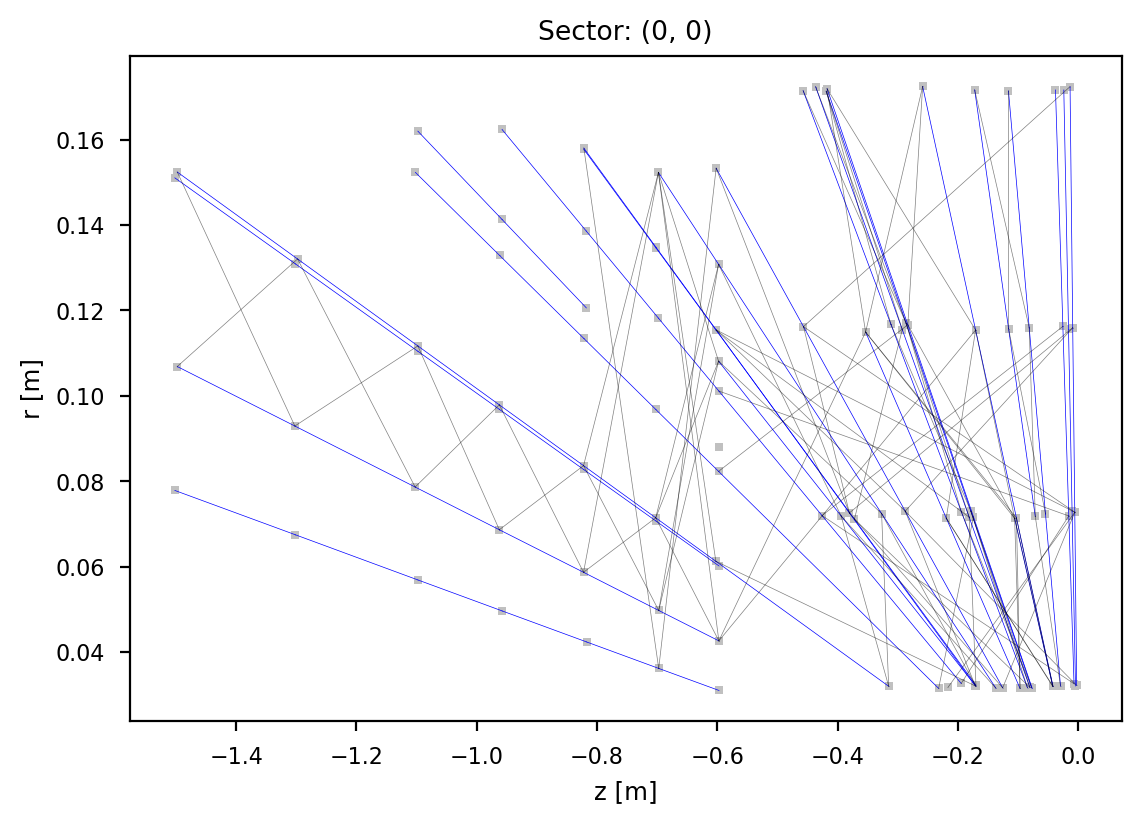

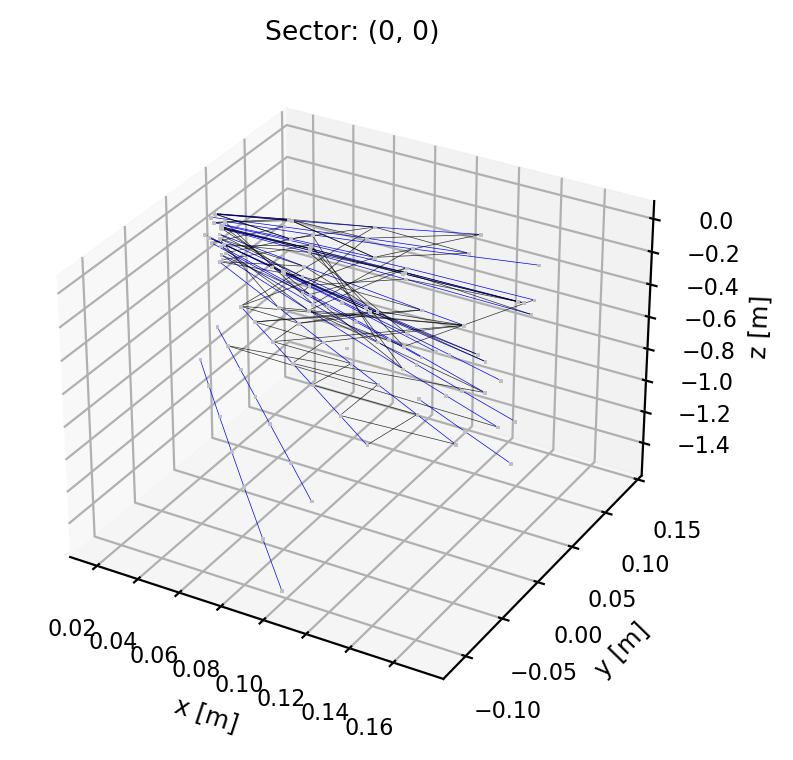

(1, 0)


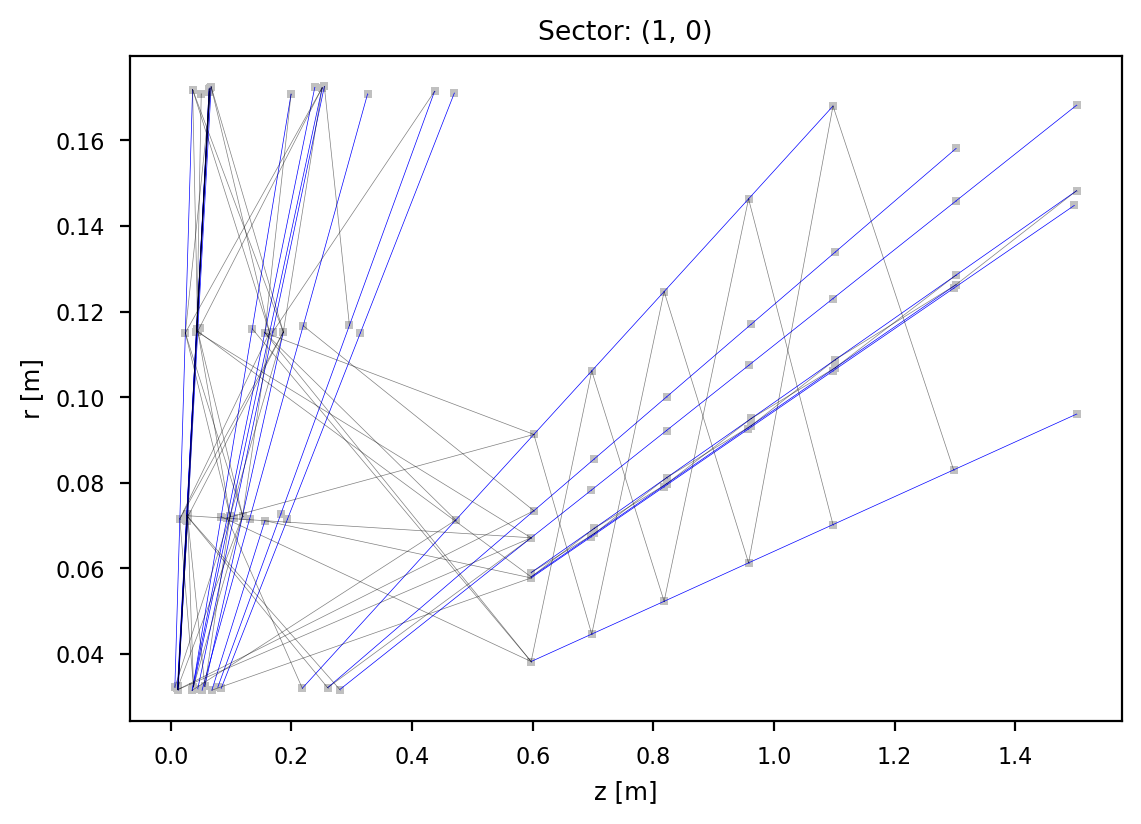

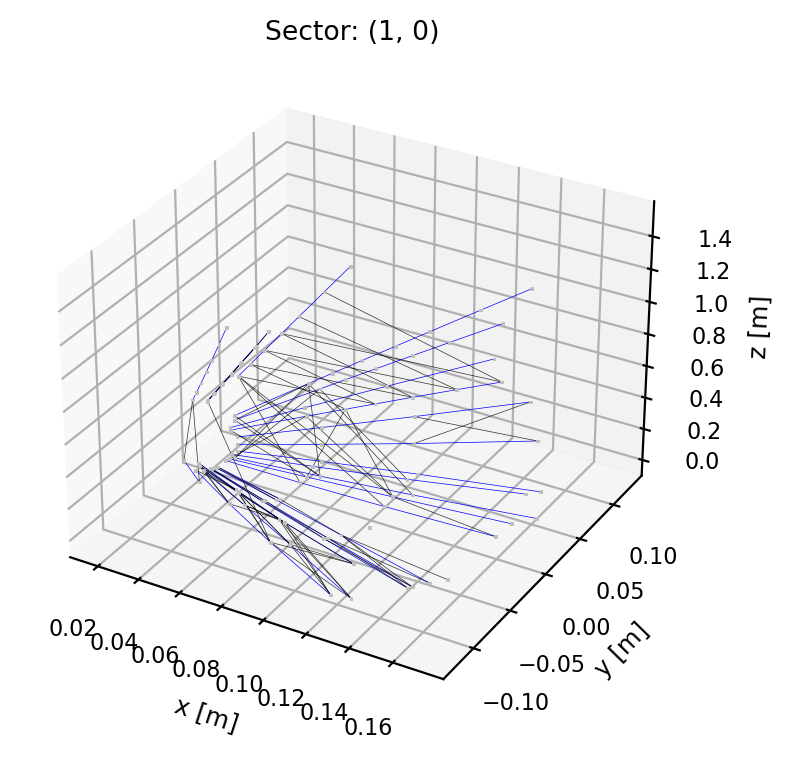

(0, 1)


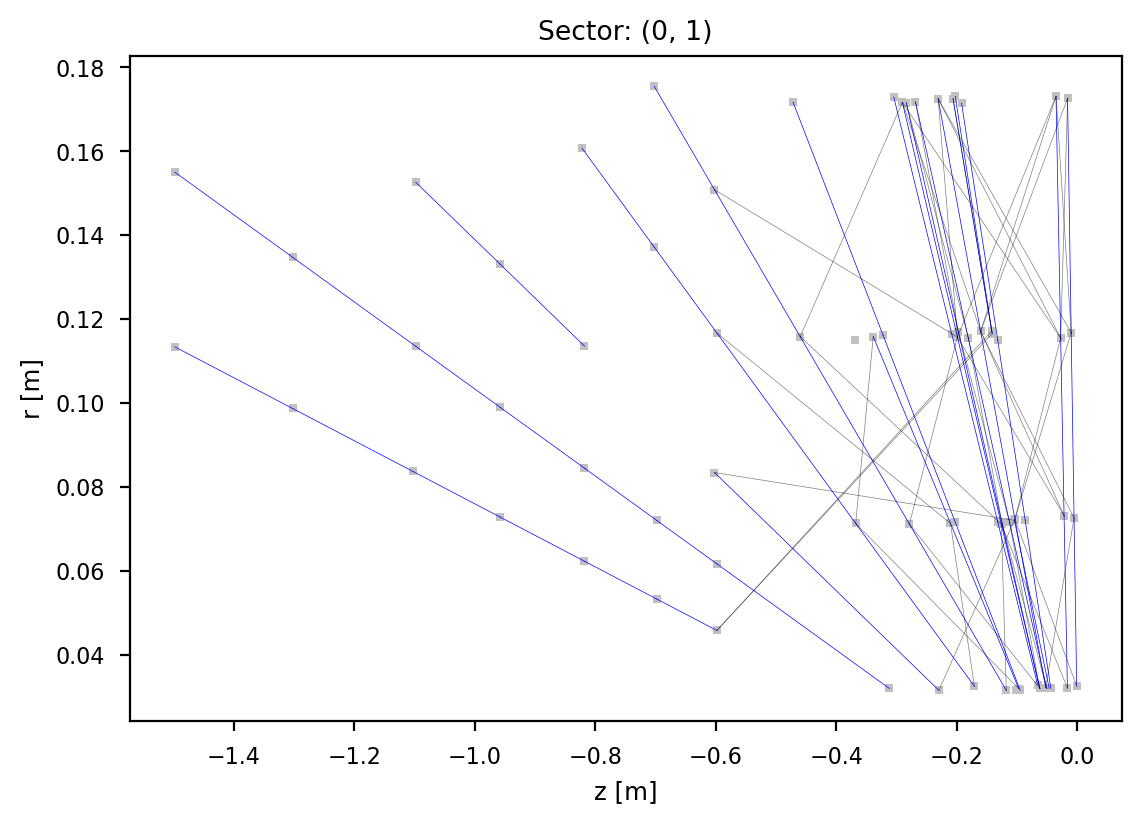

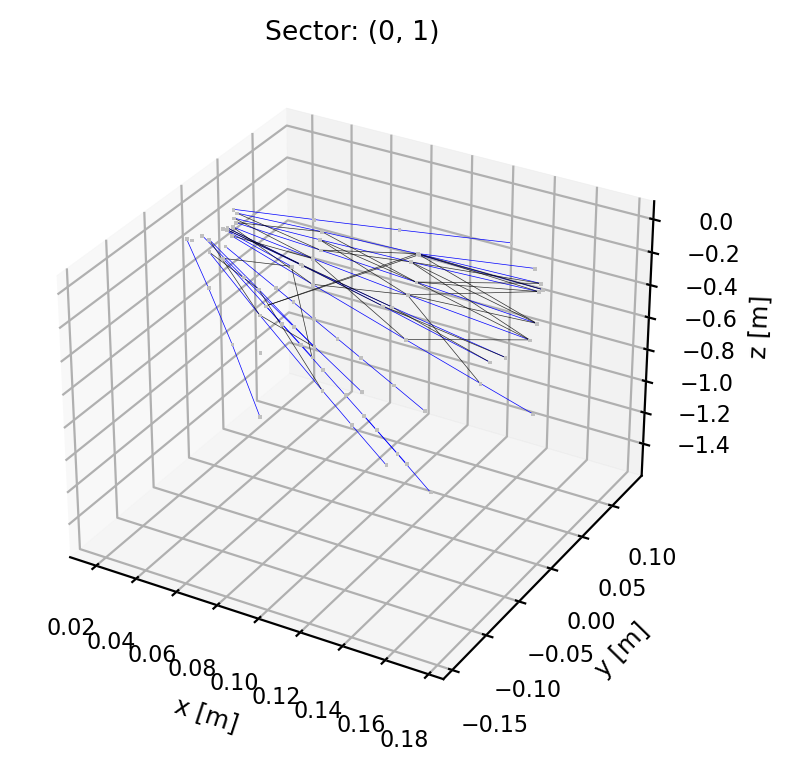

(1, 1)


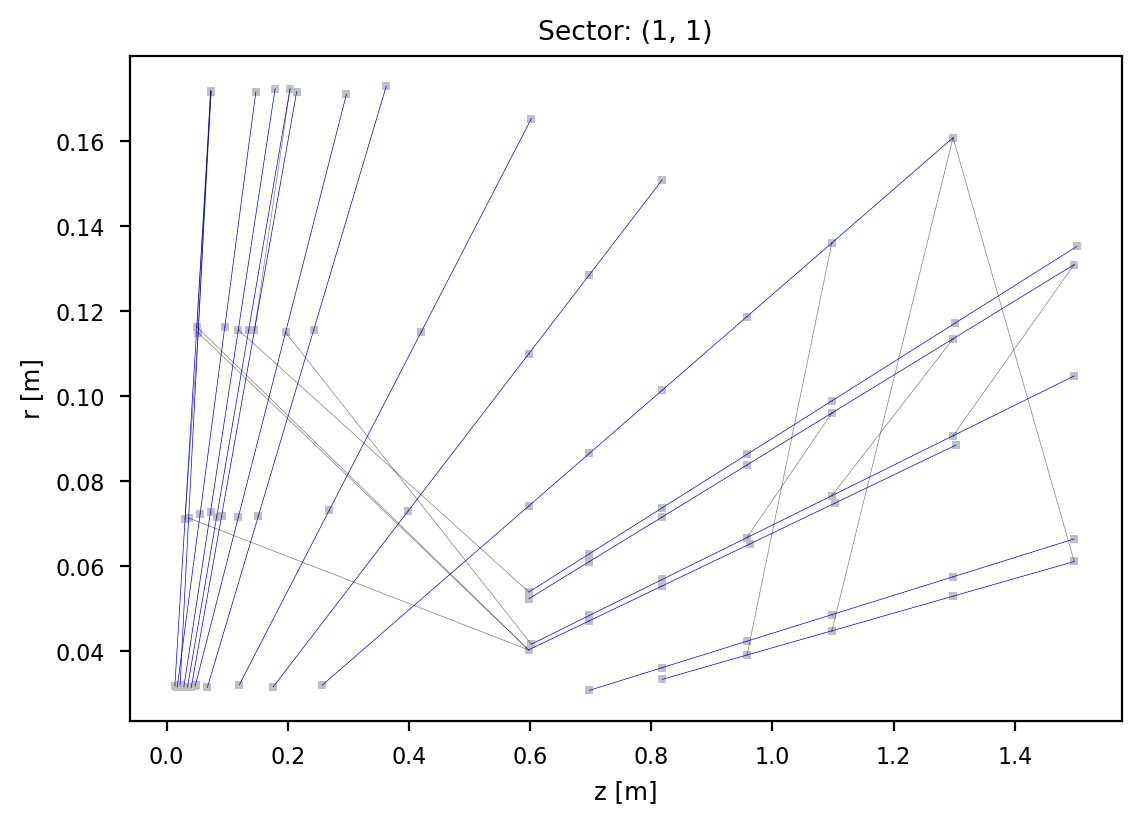

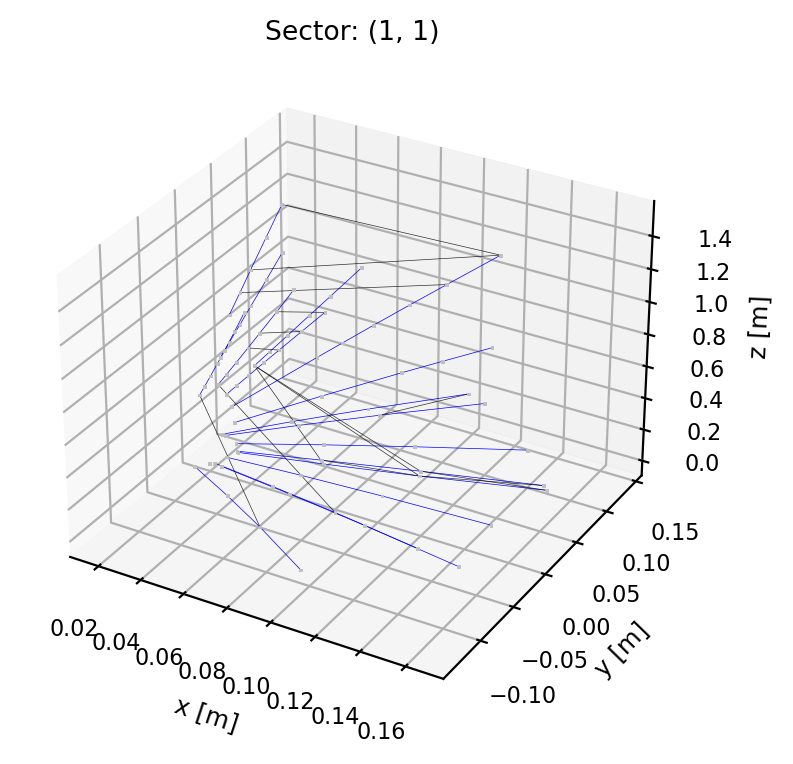

(0, 2)


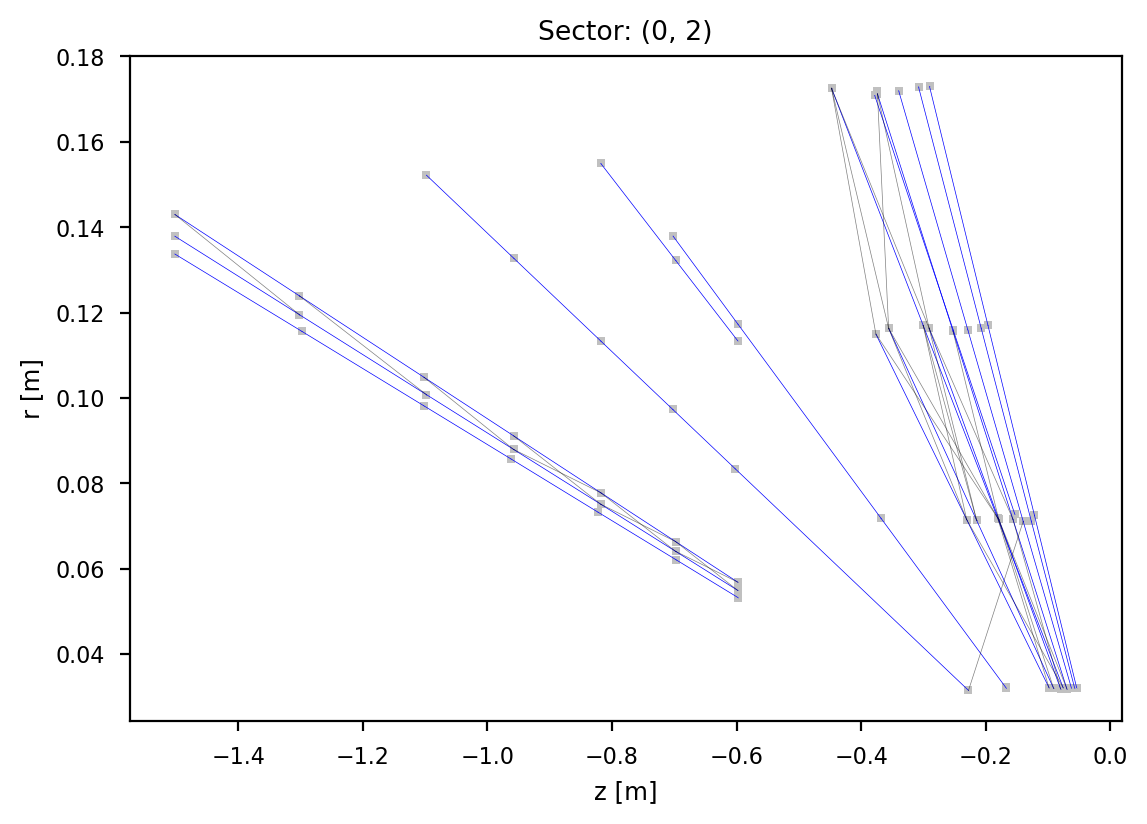

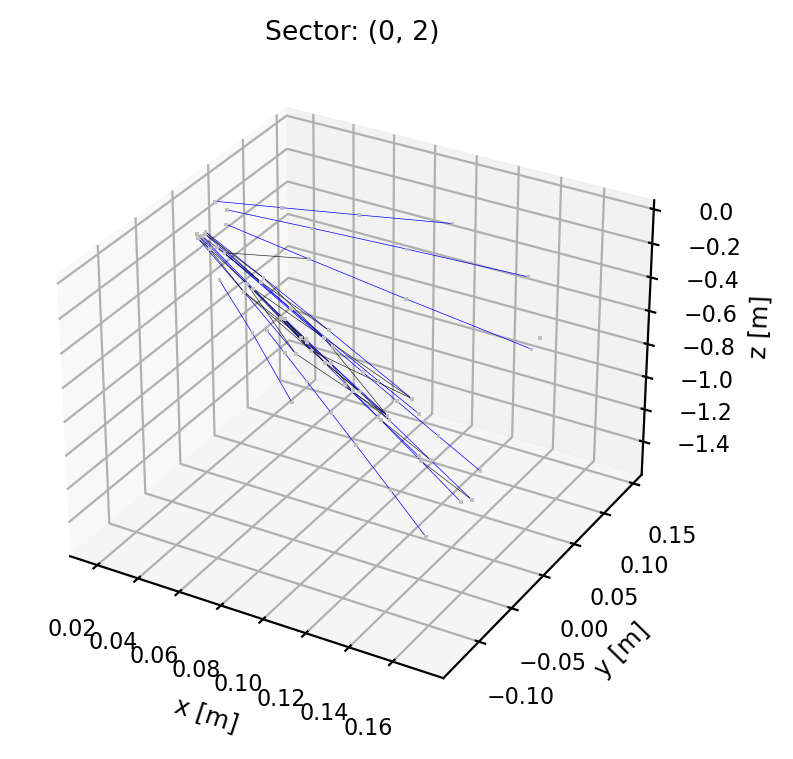

(1, 2)


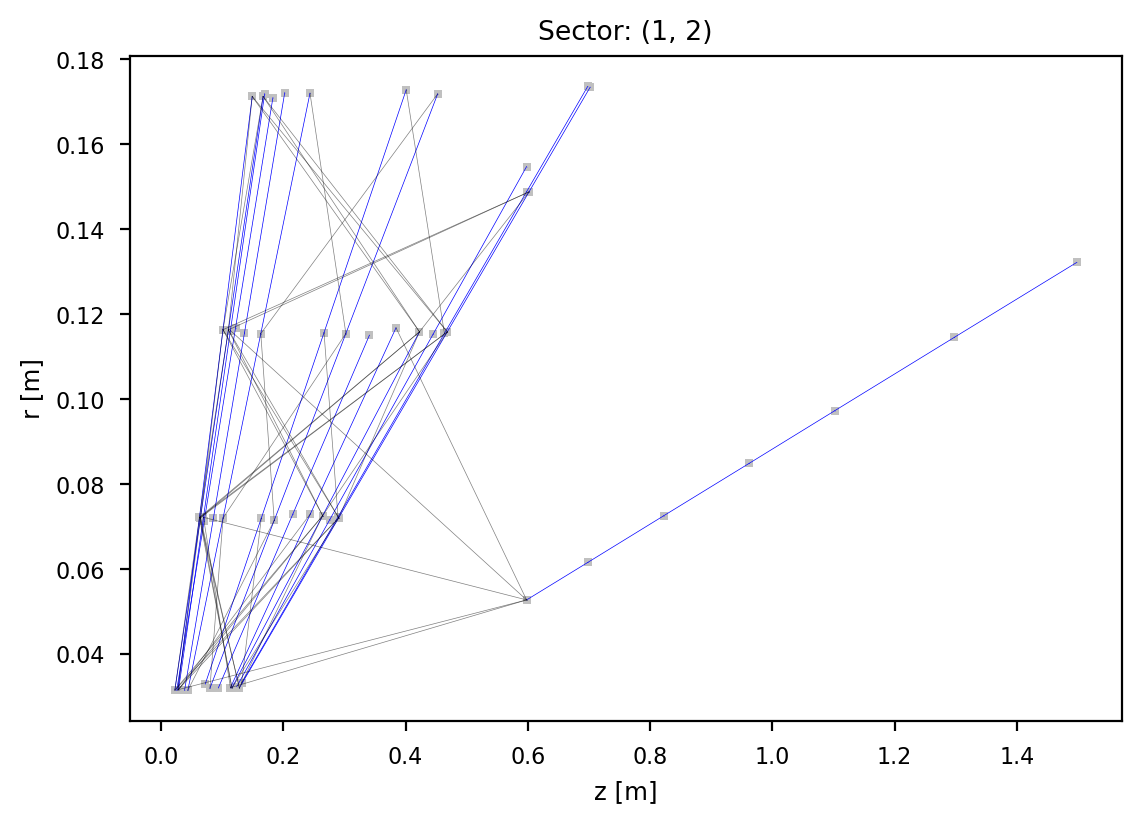

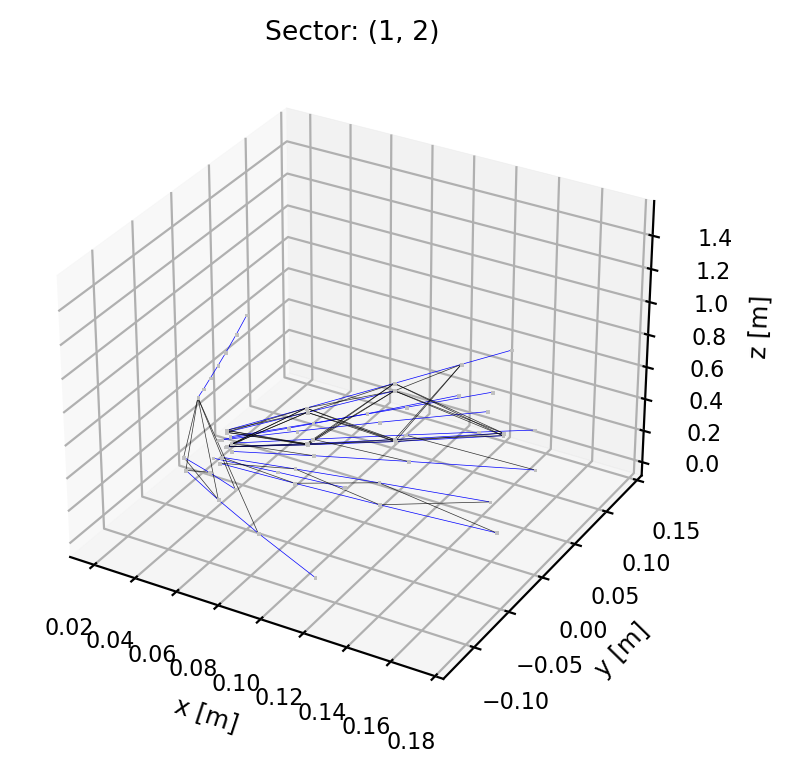

(0, 3)


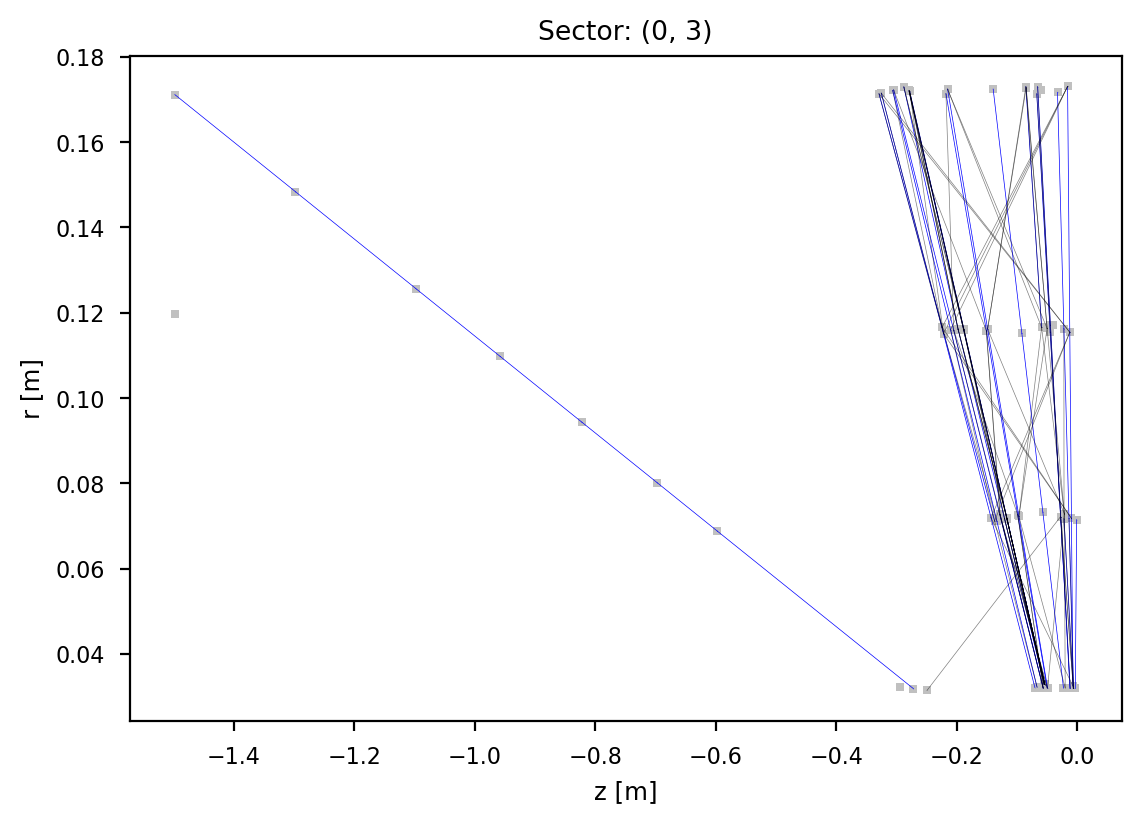

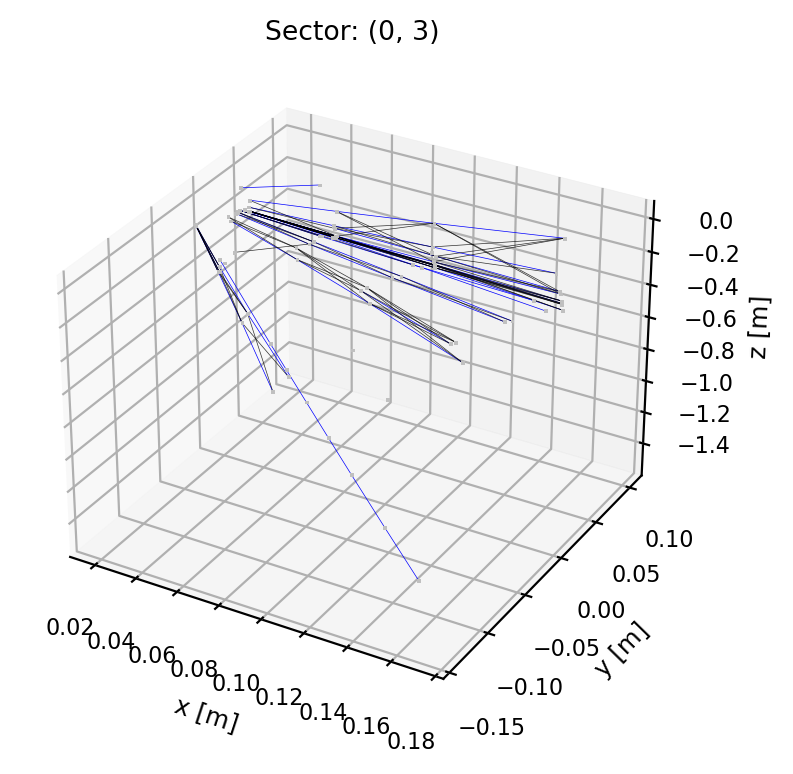

(1, 3)


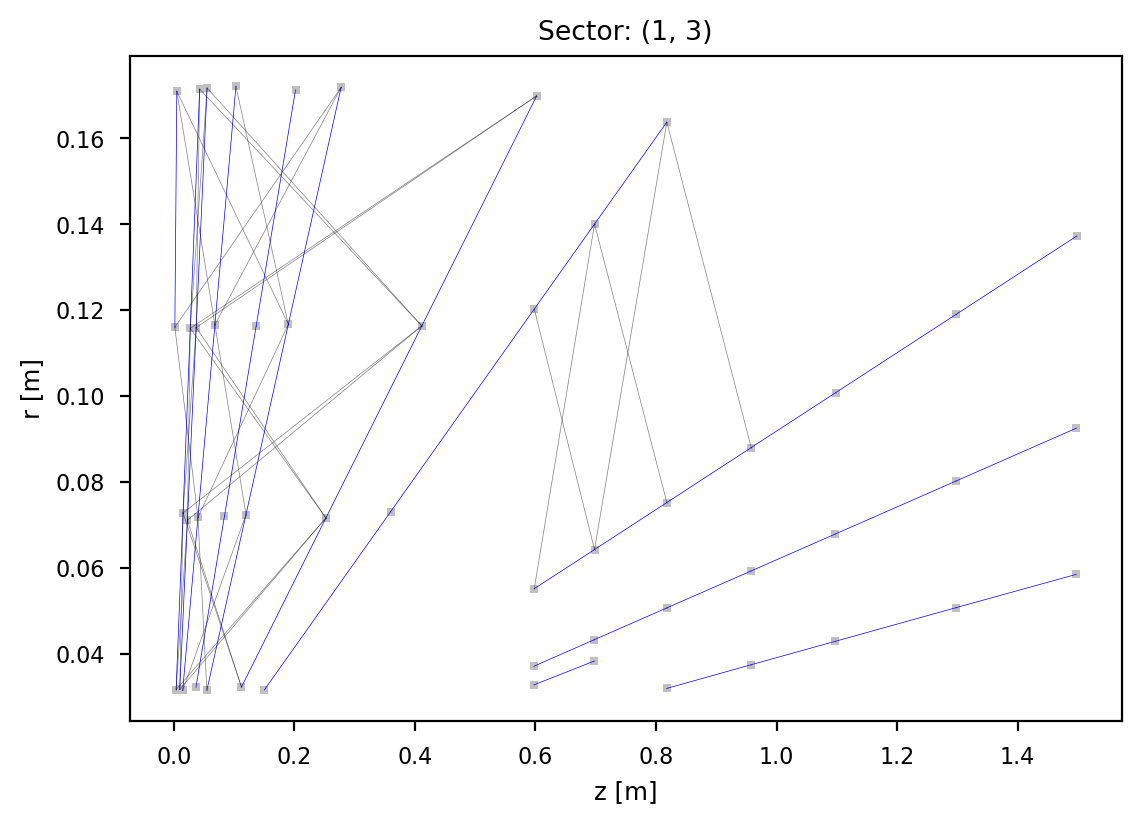

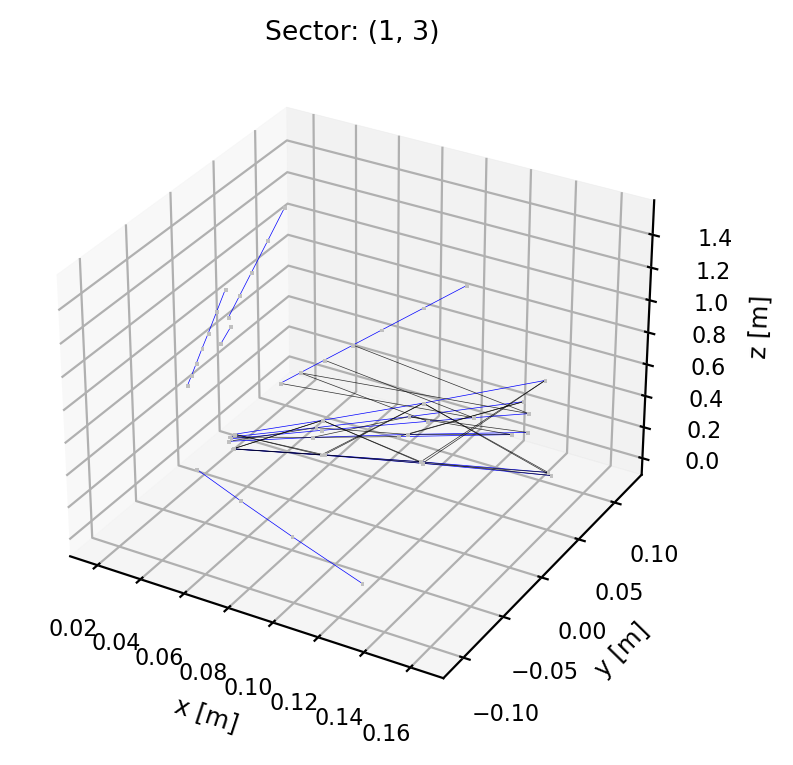

(0, 4)


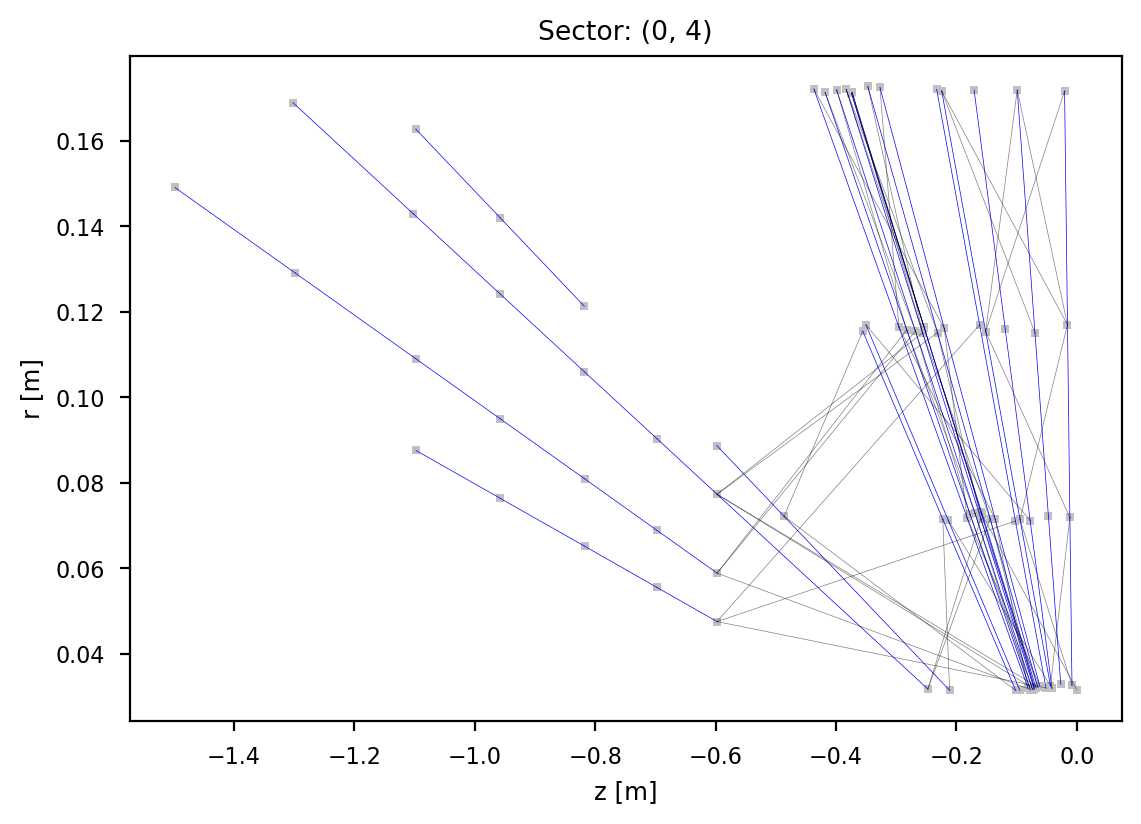

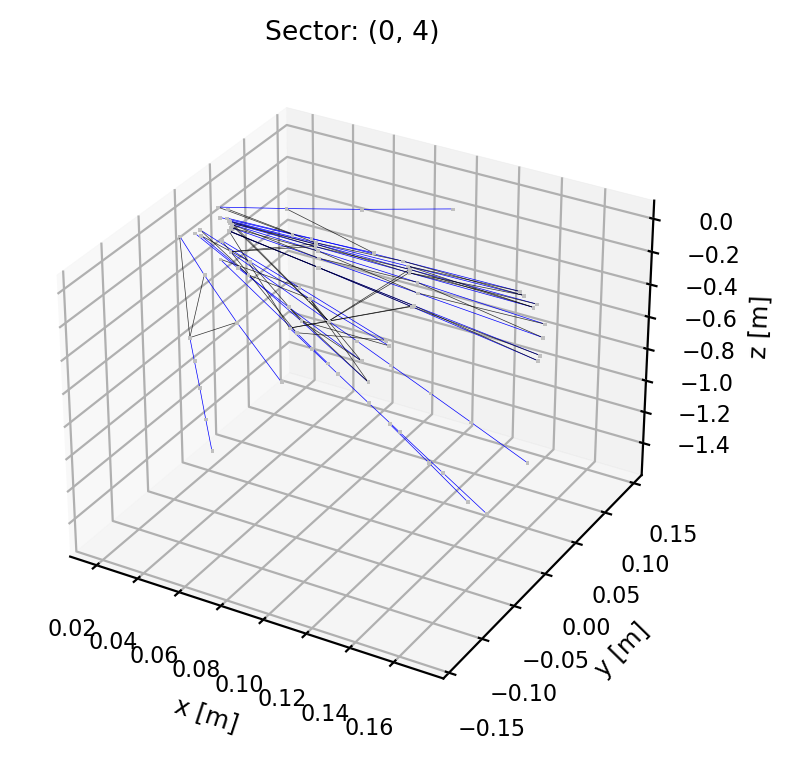

(1, 4)


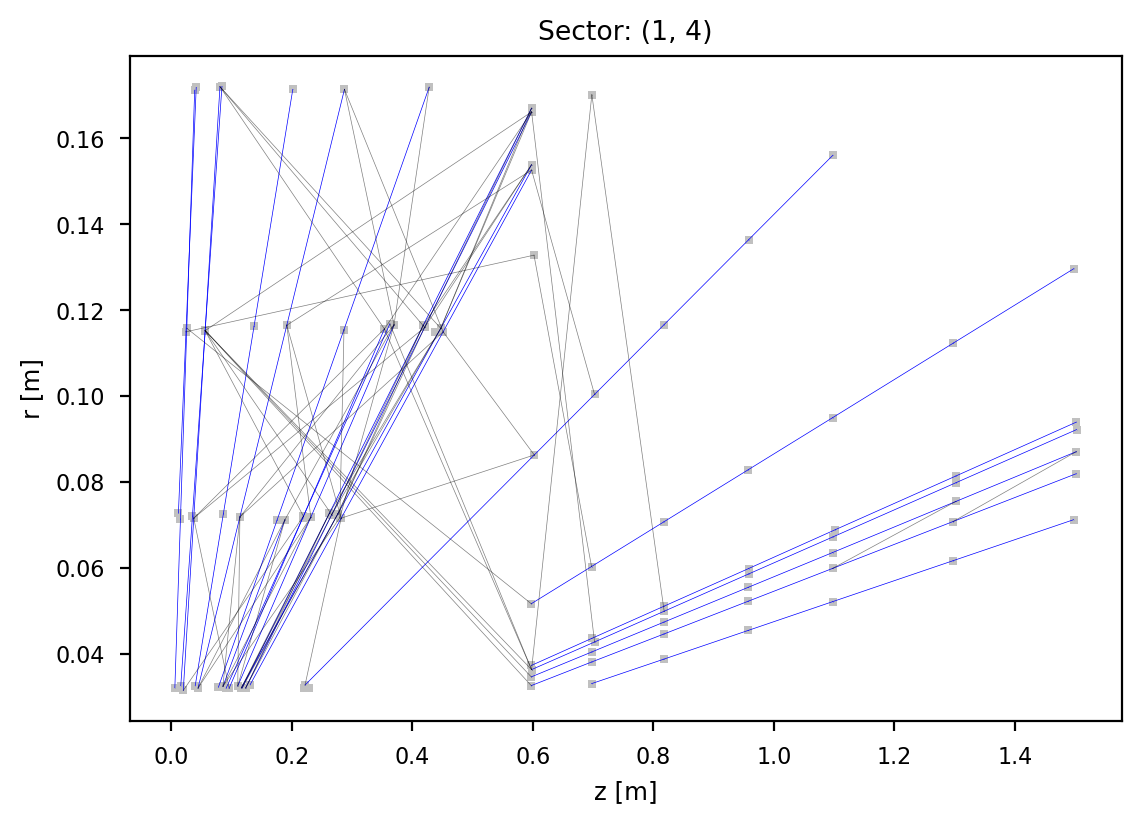

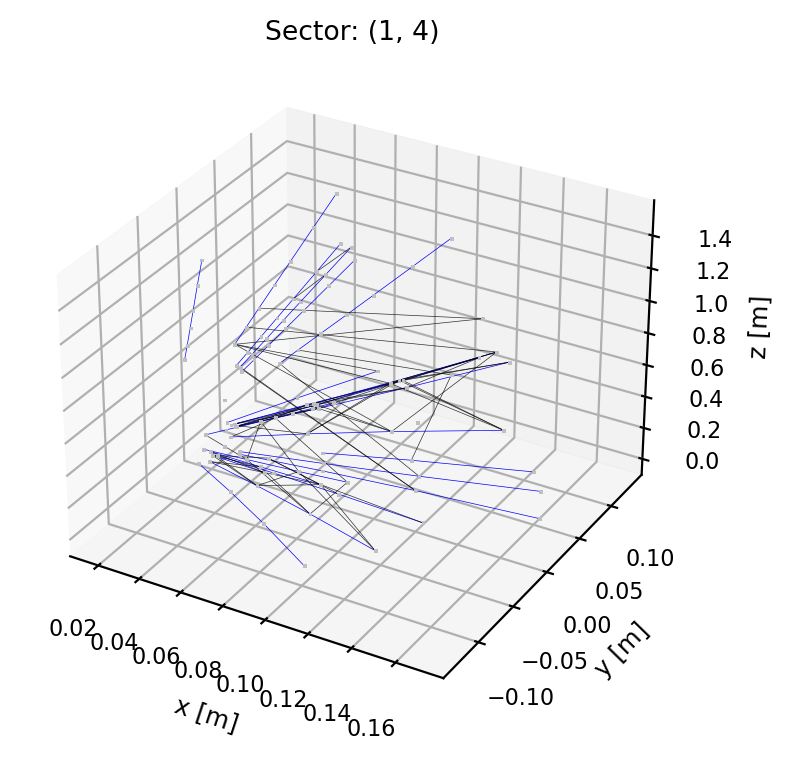

(0, 5)


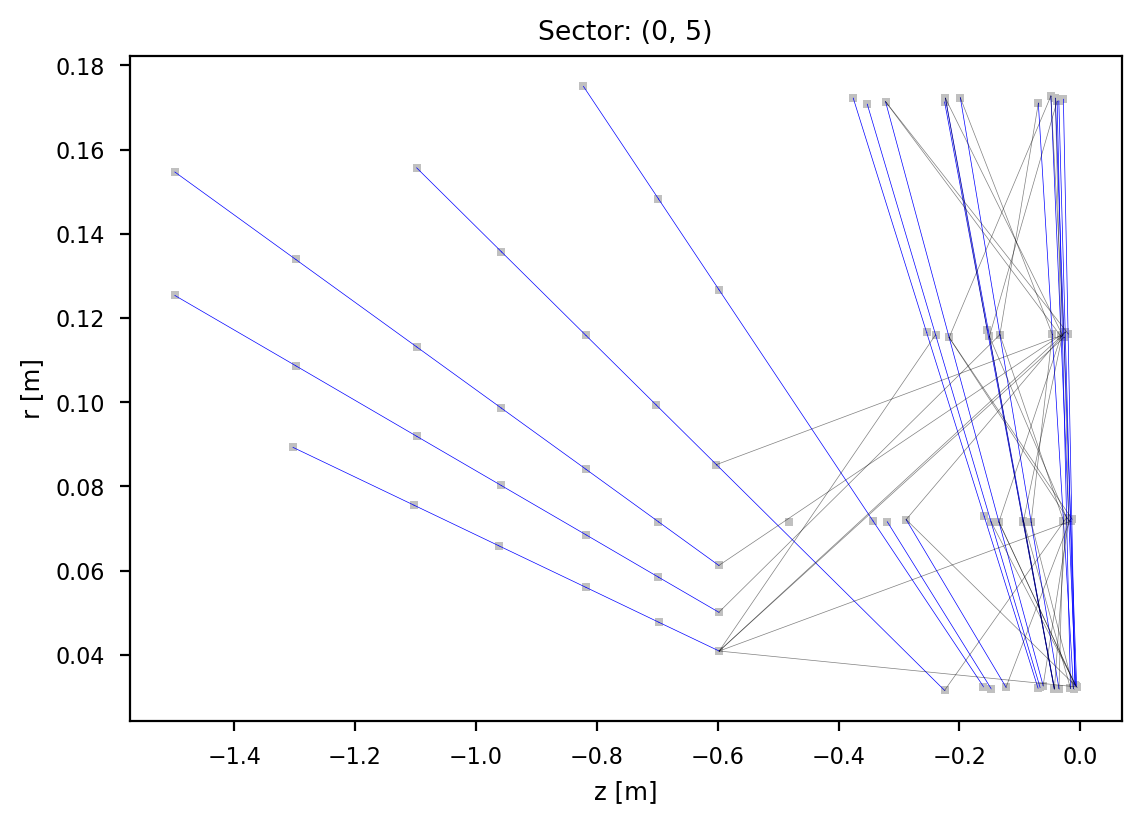

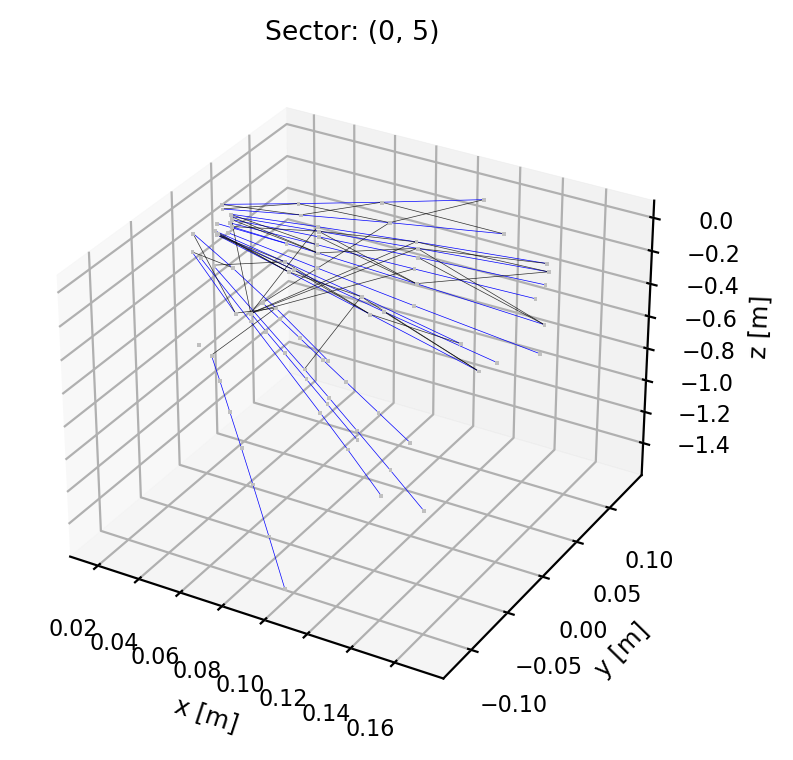

(1, 5)


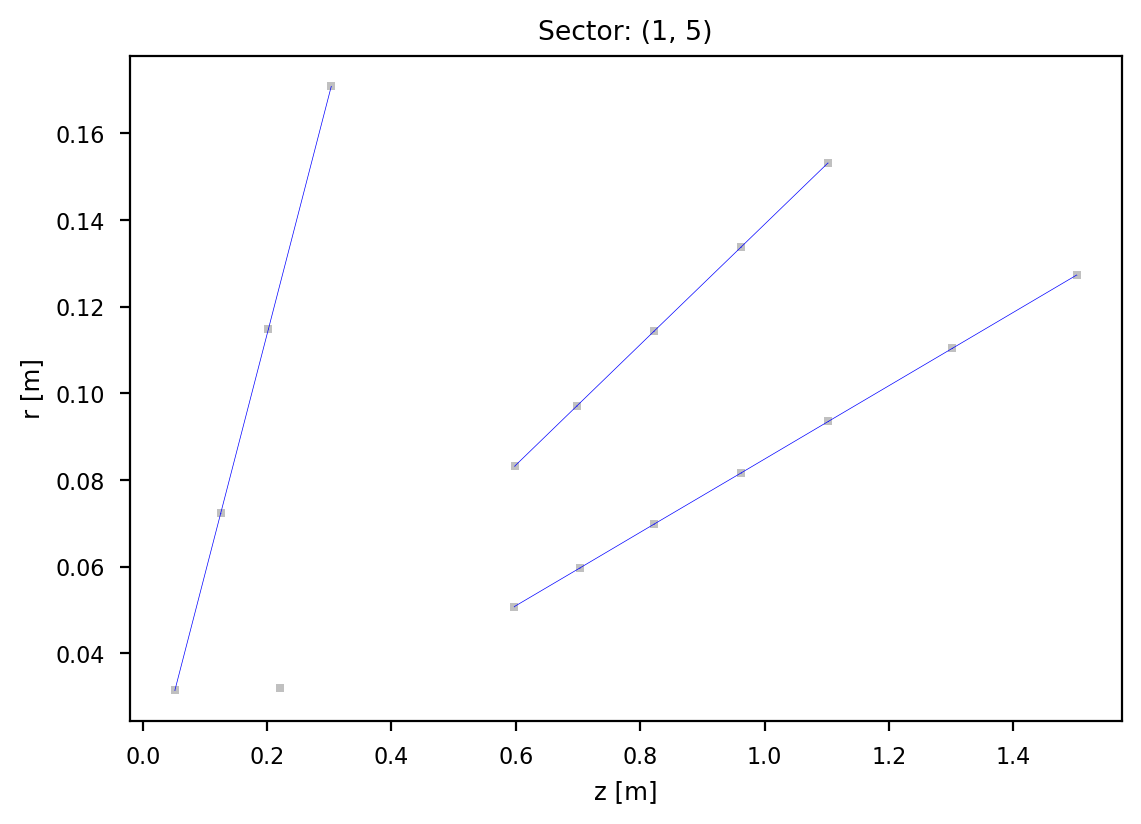

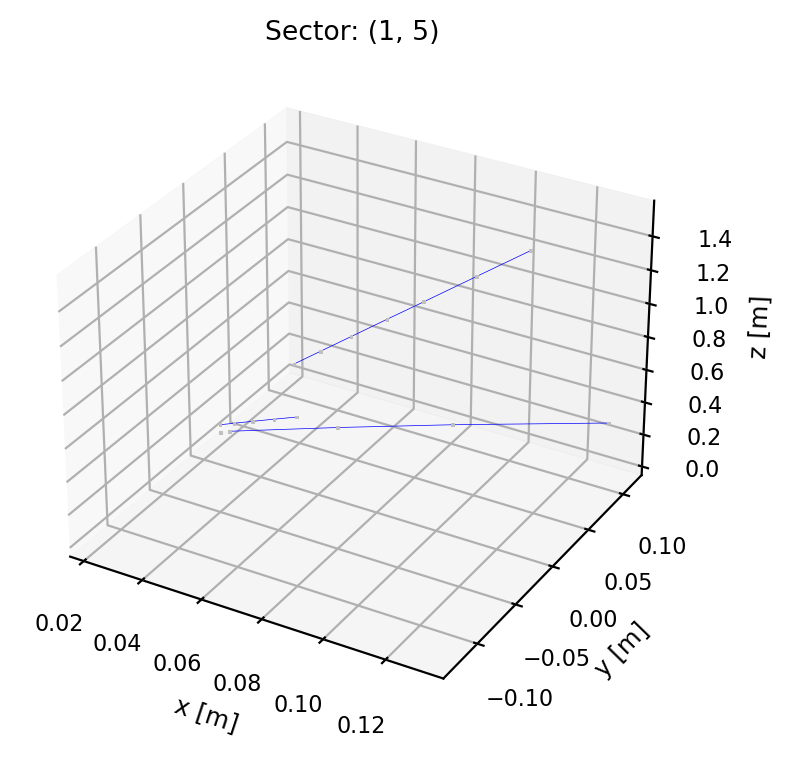

(0, 6)


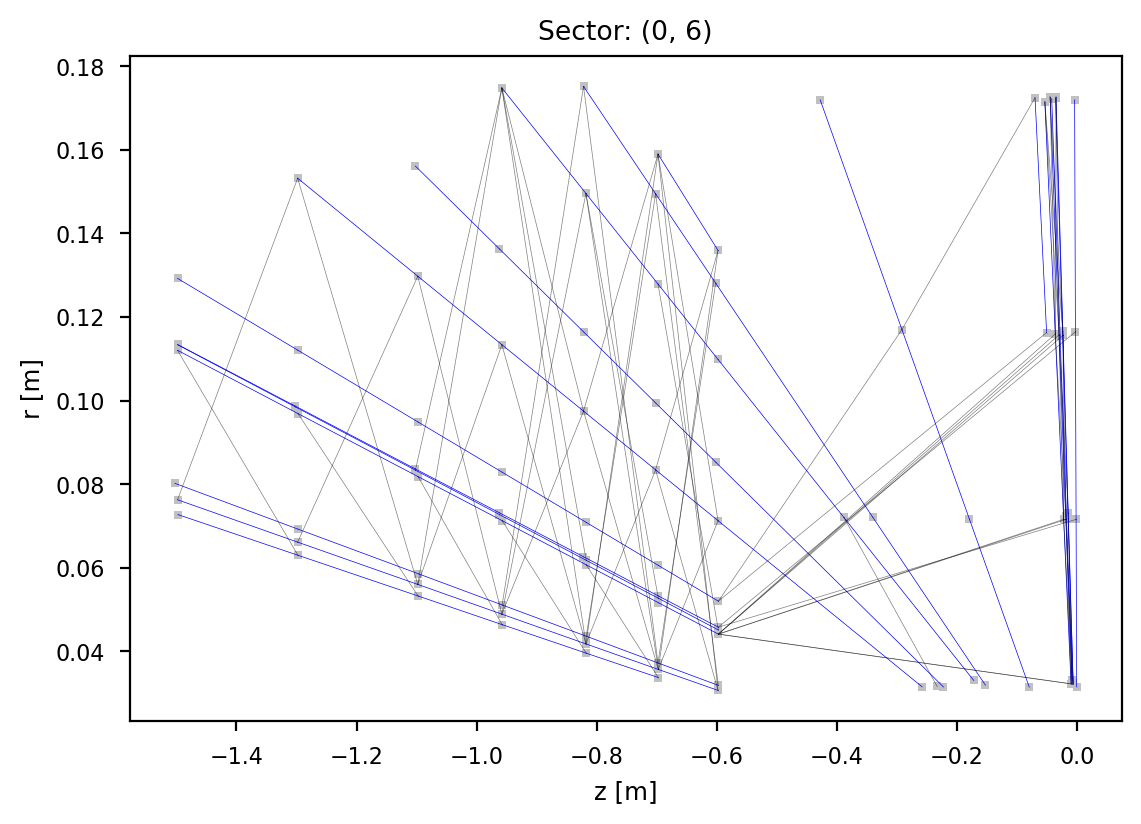

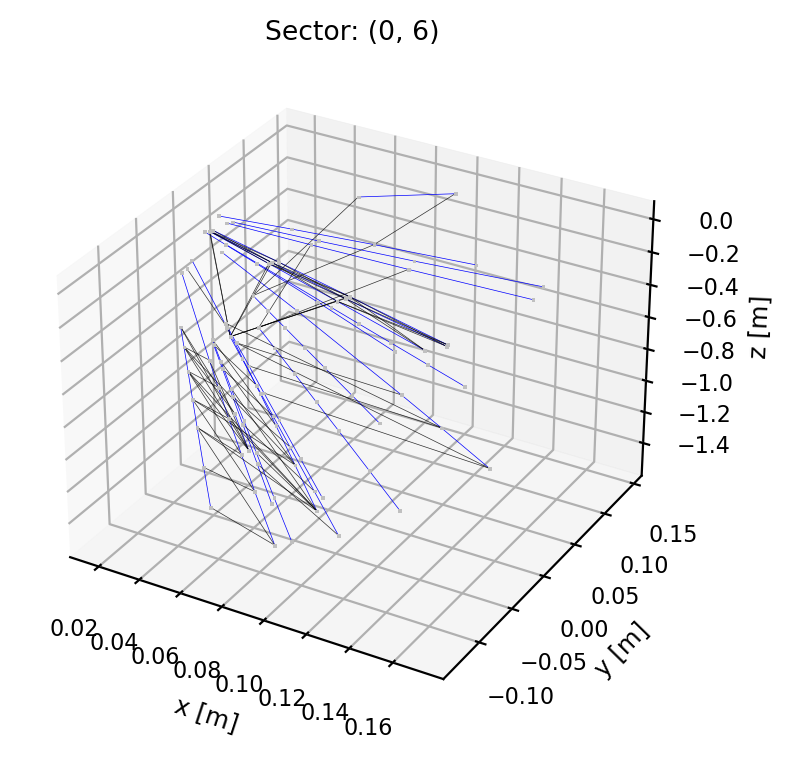

(1, 6)


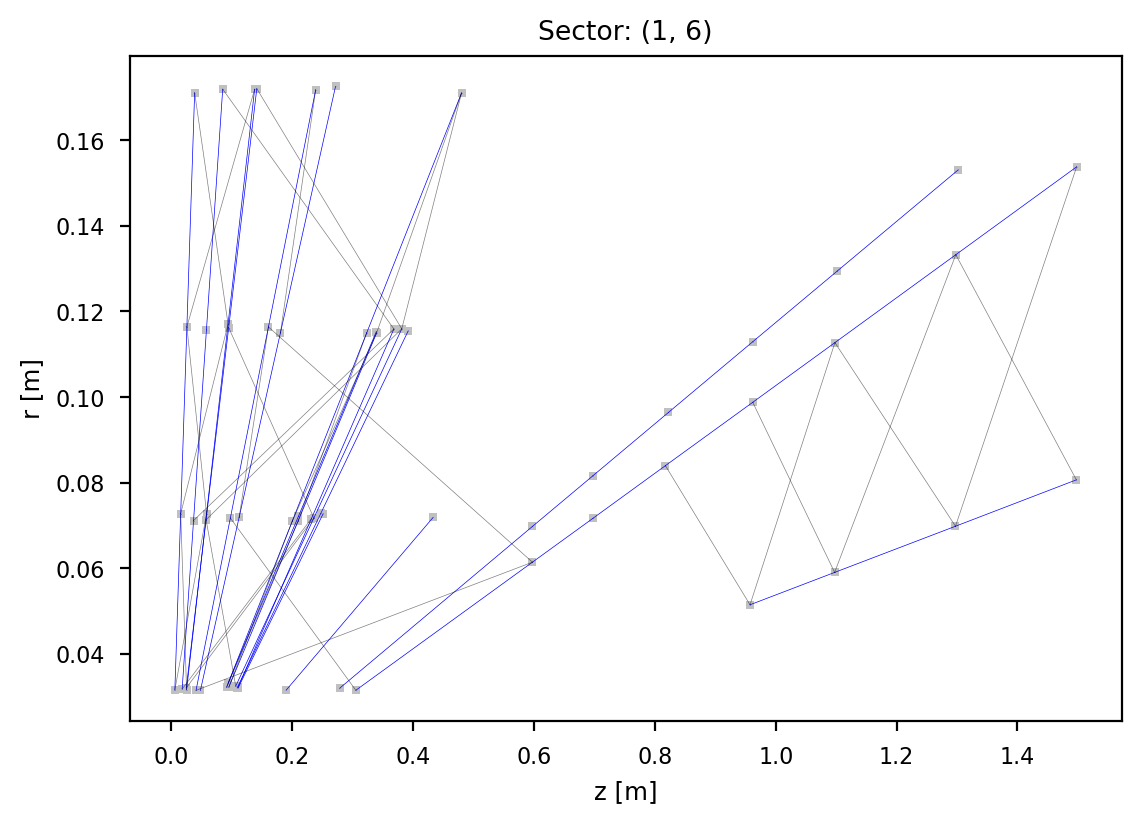

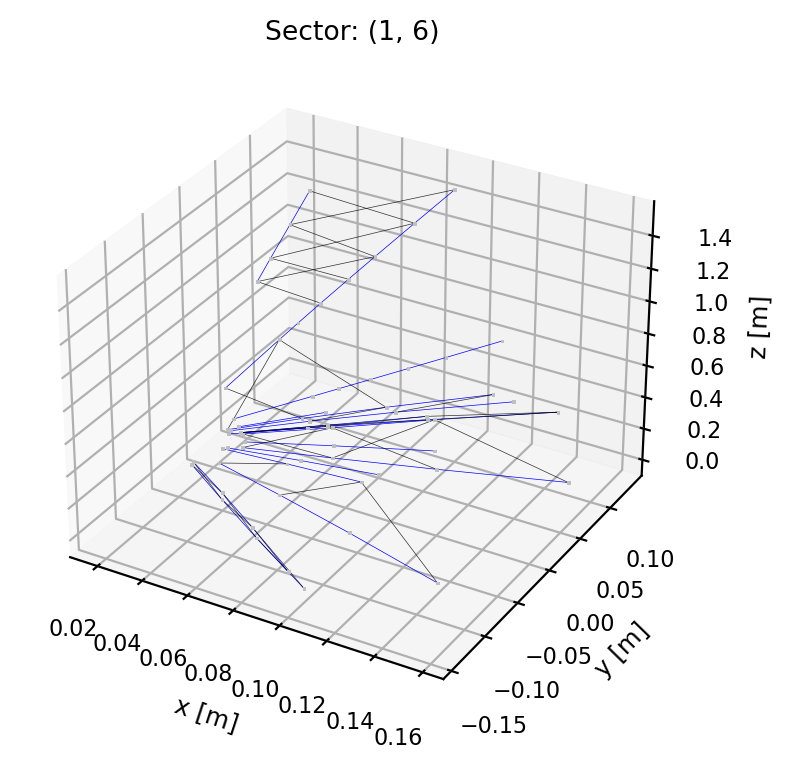

(0, 7)


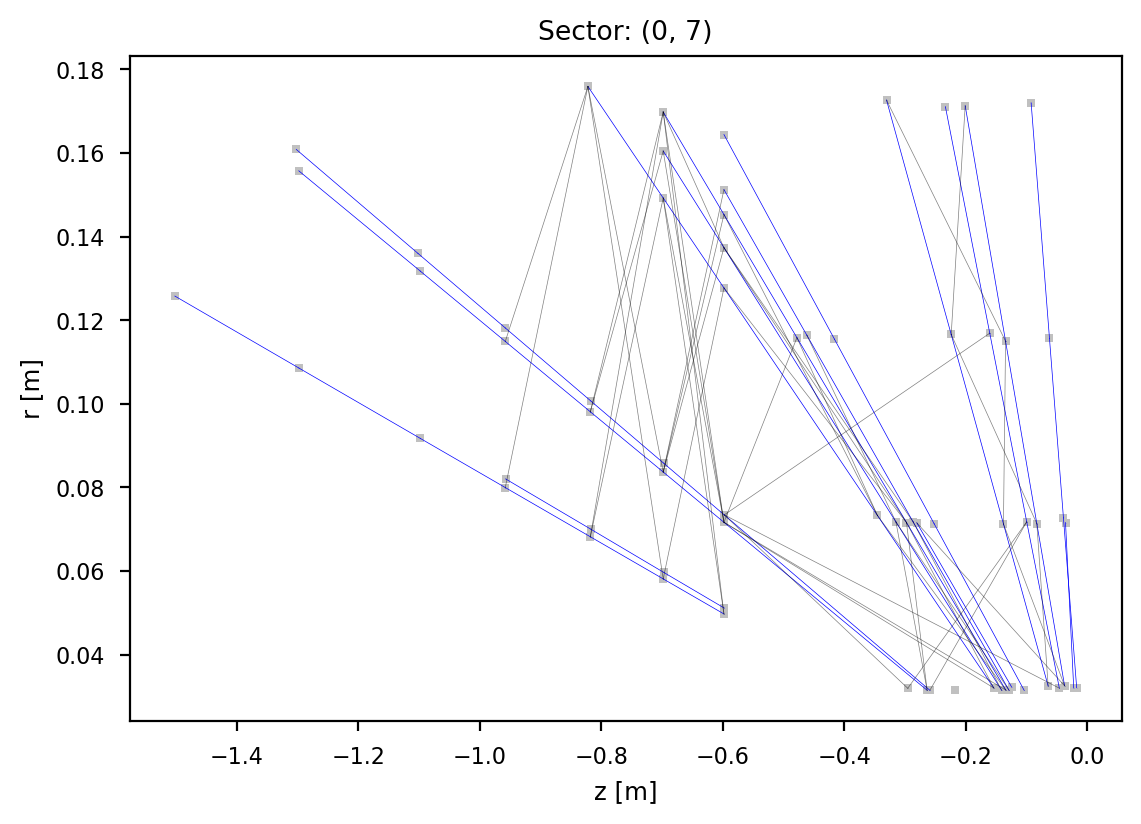

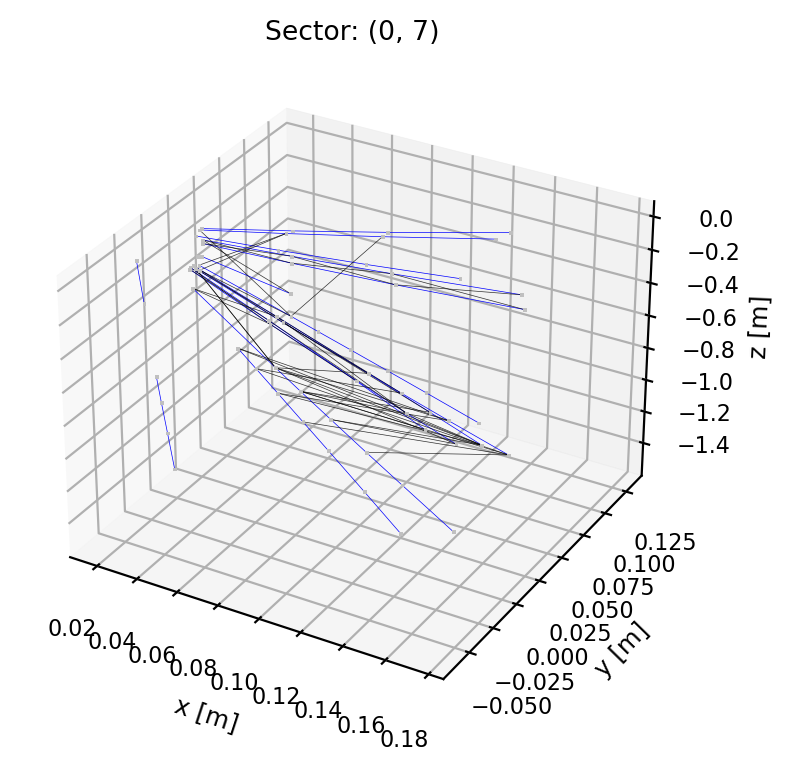

(1, 7)


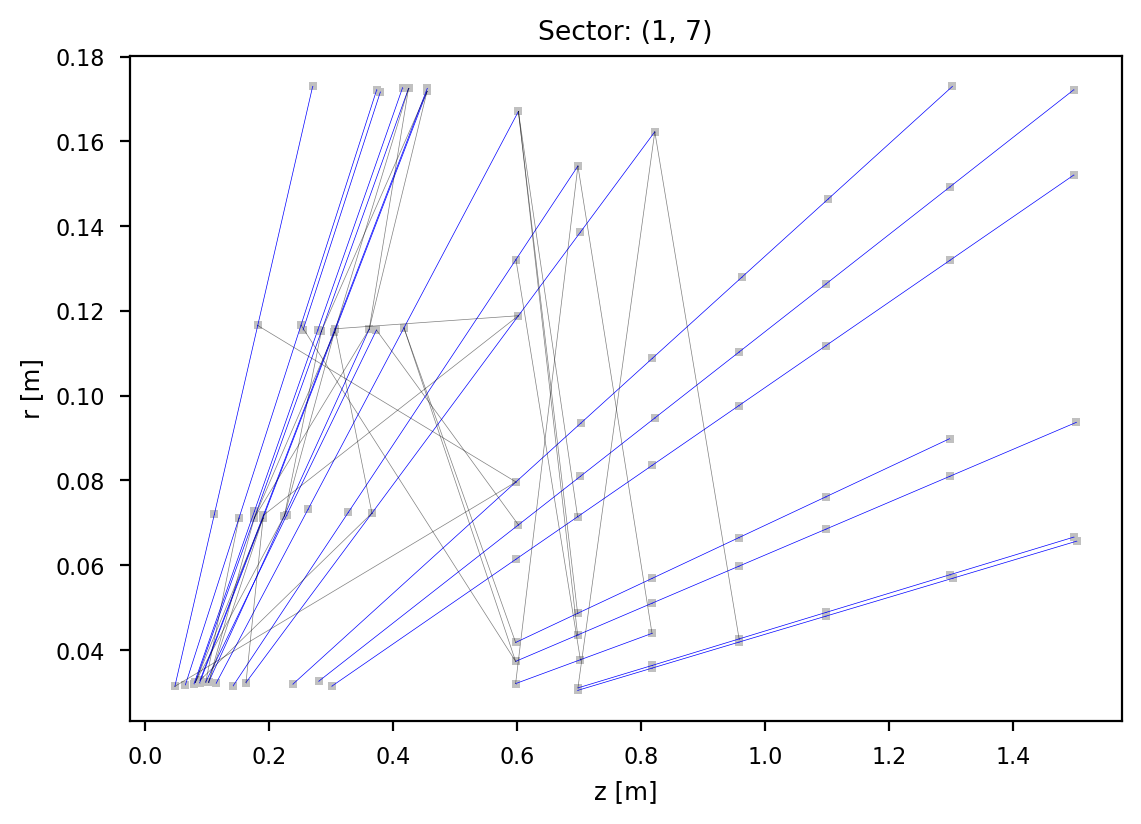

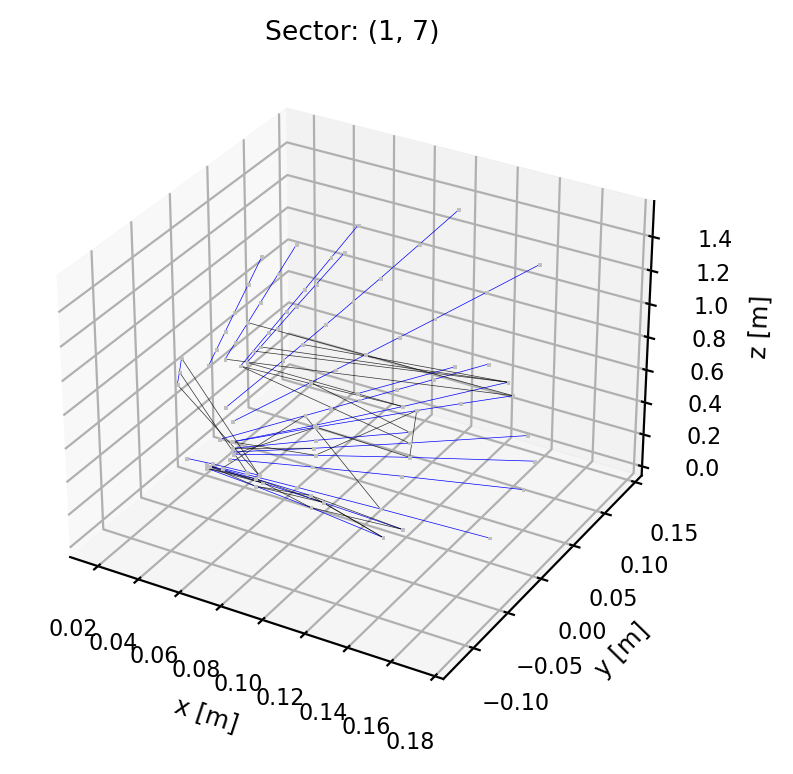

In [13]:
for sector in graph_sectors[0]:
    plot_rz(sector['x'], sector['edge_index'], sector['y'], sector['s'])
    plot_3d(sector['x'], sector['edge_index'], sector['y'], sector['s'])

In [14]:
n_eta_sectors = [1,2,4,8]
n_phi_sectors = [1,2,4,8]
shape = (len(n_eta_sectors), len(n_phi_sectors))
n_edges = np.zeros(shape)
n_edges_err = np.zeros(shape)
purities = np.zeros(shape)
purities_err = np.zeros(shape)
efficiencies = np.zeros(shape)
efficiencies_err = np.zeros(shape)
boundary_fractions = np.zeros(shape)
boundary_fractions_err = np.zeros(shape)
for i, neta in enumerate(n_eta_sectors):
    for j, nphi in enumerate(n_phi_sectors):
        print(neta, nphi)
        config = {'pt_min': 2, # GeV,
          'phi_slope_max': 0.0006,
          'z0_max': 15000,
          'n_phi_sectors': nphi,
          'n_eta_sectors': neta,
          'eta_range': [-5, 5],
          'endcaps': True,
          'remove_noise': True, 
          'remove_duplicates': True,
         }
        
        with mp.Pool(processes=n_workers) as pool:
            process_func = partial(process_event, output_dir=output_dir,
                                   phi_range=(-np.pi, np.pi), 
                                   module_maps=module_maps,
                                   **config)
            output = pool.map(process_func, file_prefixes)
        
        # analyze output statistics
        logging.info('All done!')
        graph_sectors = [graph['sectors'] for graph in output]
        output = [graph['summary_stats'] for graph in output]
        node_counts = np.array([graph_stats['n_nodes'] for graph_stats in output])
        edge_counts = np.array([graph_stats['n_edges'] for graph_stats in output])
        purity = np.array([graph_stats['purity'] for graph_stats in output])
        efficiency = np.array([graph_stats['efficiency'] for graph_stats in output])
        boundary_fraction = np.array([graph_stats['boundary_fraction'] for graph_stats in output])
    
        n_edges[i,j] = edge_counts.mean()
        n_edges_err[i,j] = edge_counts.std()
        purities[i,j] = purity.mean()
        purities_err[i,j] = purity.std()
        efficiencies[i,j] = efficiency.mean()
        efficiencies_err[i,j] = efficiency.std()
        boundary_fractions[i,j] = boundary_fraction.mean()
        boundary_fractions_err[i,j] = boundary_fraction.std()

1 1


2021-10-19 16:05:16,721 INFO Event 1000, loading data
2021-10-19 16:05:16,727 INFO Event 1002, loading data
2021-10-19 16:05:16,731 INFO Event 1004, loading data
2021-10-19 16:05:16,735 INFO Event 1006, loading data
2021-10-19 16:05:16,742 INFO Event 1008, loading data
2021-10-19 16:05:16,744 INFO Event 1010, loading data
2021-10-19 16:05:16,749 INFO Event 1012, loading data
2021-10-19 16:05:16,753 INFO Event 1014, loading data
2021-10-19 16:05:16,757 INFO Event 1016, loading data
2021-10-19 16:05:16,769 INFO Event 1018, loading data
2021-10-19 16:05:16,996 INFO Event 1000, selecting hits
2021-10-19 16:05:17,005 INFO Event 1010, selecting hits
2021-10-19 16:05:17,016 INFO Event 1006, selecting hits
2021-10-19 16:05:17,040 INFO Event 1004, selecting hits
2021-10-19 16:05:17,040 INFO Event 1018, selecting hits
2021-10-19 16:05:17,048 INFO Event 1008, selecting hits
2021-10-19 16:05:17,063 INFO Event 1002, selecting hits
2021-10-19 16:05:17,068 INFO Event 1016, selecting hits
2021-10-19 1

2021-10-19 16:05:18,932 INFO Event 1017, graph summary statistics
...total nodes: 1325
...total edges: 2543
...efficiency: 0.99024
...purity: 0.39913
...boundary edge fraction: 0.00000
2021-10-19 16:05:18,941 INFO Event 1034, loading data
2021-10-19 16:05:18,966 INFO Event 1022, selecting hits
2021-10-19 16:05:18,967 INFO Event 1007, calculating graph summary
2021-10-19 16:05:18,967 INFO Event 1020, constructing graphs
2021-10-19 16:05:18,968 INFO Event 1007, graph summary statistics
...total nodes: 1107
...total edges: 1802
...efficiency: 0.98601
...purity: 0.46948
...boundary edge fraction: 0.00000
2021-10-19 16:05:18,977 INFO Event 1036, loading data
2021-10-19 16:05:18,999 INFO Event 1015, calculating graph summary
2021-10-19 16:05:19,001 INFO Event 1015, graph summary statistics
...total nodes: 1267
...total edges: 2308
...efficiency: 0.98271
...purity: 0.41854
...boundary edge fraction: 0.00000
2021-10-19 16:05:19,005 INFO Event 1024, selecting hits
2021-10-19 16:05:19,011 INFO E

2021-10-19 16:05:20,713 INFO Event 1027, calculating graph summary
2021-10-19 16:05:20,715 INFO Event 1027, graph summary statistics
...total nodes: 1137
...total edges: 1989
...efficiency: 0.99774
...purity: 0.44344
...boundary edge fraction: 0.00000
2021-10-19 16:05:20,737 INFO Event 1039, calculating graph summary
2021-10-19 16:05:20,738 INFO Event 1039, graph summary statistics
...total nodes: 794
...total edges: 1191
...efficiency: 0.98358
...purity: 0.50294
...boundary edge fraction: 0.00000
2021-10-19 16:05:20,782 INFO Event 1025, calculating graph summary
2021-10-19 16:05:20,784 INFO Event 1025, graph summary statistics
...total nodes: 1415
...total edges: 3203
...efficiency: 0.99814
...purity: 0.33594
...boundary edge fraction: 0.00000
2021-10-19 16:05:20,834 INFO incorrectly-labeled edges: 1
2021-10-19 16:05:20,836 INFO Event 1037, calculating graph summary
2021-10-19 16:05:20,837 INFO Event 1037, graph summary statistics
...total nodes: 1269
...total edges: 2423
...efficienc

1 2


2021-10-19 16:05:22,587 INFO Event 1000, loading data
2021-10-19 16:05:22,591 INFO Event 1002, loading data
2021-10-19 16:05:22,595 INFO Event 1004, loading data
2021-10-19 16:05:22,599 INFO Event 1006, loading data
2021-10-19 16:05:22,603 INFO Event 1008, loading data
2021-10-19 16:05:22,608 INFO Event 1010, loading data
2021-10-19 16:05:22,611 INFO Event 1012, loading data
2021-10-19 16:05:22,618 INFO Event 1014, loading data
2021-10-19 16:05:22,622 INFO Event 1016, loading data
2021-10-19 16:05:22,643 INFO Event 1018, loading data
2021-10-19 16:05:22,857 INFO Event 1000, selecting hits
2021-10-19 16:05:22,876 INFO Event 1002, selecting hits
2021-10-19 16:05:22,879 INFO Event 1006, selecting hits
2021-10-19 16:05:22,882 INFO Event 1010, selecting hits
2021-10-19 16:05:22,885 INFO Event 1008, selecting hits
2021-10-19 16:05:22,893 INFO Event 1012, selecting hits
2021-10-19 16:05:22,894 INFO Event 1018, selecting hits
2021-10-19 16:05:22,897 INFO Event 1004, selecting hits
2021-10-19 1

2021-10-19 16:05:25,292 INFO Event 1011, graph summary statistics
...total nodes: 1028
...total edges: 1684
...efficiency: 0.99491
...purity: 0.46437
...boundary edge fraction: 0.00127
2021-10-19 16:05:25,301 INFO Event 1034, loading data
2021-10-19 16:05:25,302 INFO Event 1020, selecting hits
2021-10-19 16:05:25,326 INFO Event 1022, selecting hits
2021-10-19 16:05:25,376 INFO Event 1024, selecting hits
2021-10-19 16:05:25,379 INFO Event 1007, calculating graph summary
2021-10-19 16:05:25,380 INFO Event 1007, graph summary statistics
...total nodes: 1107
...total edges: 1795
...efficiency: 0.98485
...purity: 0.47075
...boundary edge fraction: 0.00350
2021-10-19 16:05:25,389 INFO Event 1036, loading data
2021-10-19 16:05:25,411 INFO Event 1017, calculating graph summary
2021-10-19 16:05:25,413 INFO Event 1017, graph summary statistics
...total nodes: 1325
...total edges: 2500
...efficiency: 0.98634
...purity: 0.40440
...boundary edge fraction: 0.00390
2021-10-19 16:05:25,423 INFO Event 

2021-10-19 16:05:27,846 INFO Event 1050, loading data
2021-10-19 16:05:27,917 INFO Event 1044, selecting hits
2021-10-19 16:05:27,953 INFO Event 1035, calculating graph summary
2021-10-19 16:05:27,955 INFO Event 1035, graph summary statistics
...total nodes: 895
...total edges: 1409
...efficiency: 0.99425
...purity: 0.49113
...boundary edge fraction: 0.00144
2021-10-19 16:05:27,972 INFO Event 1025, calculating graph summary
2021-10-19 16:05:27,973 INFO Event 1025, graph summary statistics
...total nodes: 1415
...total edges: 3198
...efficiency: 0.99629
...purity: 0.33583
...boundary edge fraction: 0.00186
2021-10-19 16:05:27,975 INFO Event 1046, selecting hits
2021-10-19 16:05:27,981 INFO Event 1048, selecting hits
2021-10-19 16:05:27,981 INFO Event 1042, constructing graphs
2021-10-19 16:05:28,003 INFO Event 1033, calculating graph summary
2021-10-19 16:05:28,009 INFO Event 1033, graph summary statistics
...total nodes: 1019
...total edges: 1766
...efficiency: 0.99359
...purity: 0.438

1 4


2021-10-19 16:05:30,292 INFO Event 1000, loading data
2021-10-19 16:05:30,296 INFO Event 1002, loading data
2021-10-19 16:05:30,300 INFO Event 1004, loading data
2021-10-19 16:05:30,304 INFO Event 1006, loading data
2021-10-19 16:05:30,310 INFO Event 1008, loading data
2021-10-19 16:05:30,320 INFO Event 1010, loading data
2021-10-19 16:05:30,326 INFO Event 1012, loading data
2021-10-19 16:05:30,330 INFO Event 1014, loading data
2021-10-19 16:05:30,336 INFO Event 1016, loading data
2021-10-19 16:05:30,349 INFO Event 1018, loading data
2021-10-19 16:05:30,550 INFO Event 1002, selecting hits
2021-10-19 16:05:30,591 INFO Event 1000, selecting hits
2021-10-19 16:05:30,591 INFO Event 1004, selecting hits
2021-10-19 16:05:30,592 INFO Event 1018, selecting hits
2021-10-19 16:05:30,603 INFO Event 1012, selecting hits
2021-10-19 16:05:30,608 INFO Event 1008, selecting hits
2021-10-19 16:05:30,613 INFO Event 1006, selecting hits
2021-10-19 16:05:30,630 INFO Event 1014, selecting hits
2021-10-19 1

2021-10-19 16:05:34,349 INFO Event 1015, calculating graph summary
2021-10-19 16:05:34,350 INFO Event 1015, graph summary statistics
...total nodes: 1267
...total edges: 2287
...efficiency: 0.98169
...purity: 0.42195
...boundary edge fraction: 0.00305
2021-10-19 16:05:34,354 INFO Event 1024, selecting hits
2021-10-19 16:05:34,359 INFO Event 1034, loading data
2021-10-19 16:05:34,419 INFO Event 1026, selecting hits
2021-10-19 16:05:34,509 INFO Event 1028, selecting hits
2021-10-19 16:05:34,529 INFO Event 1030, selecting hits
2021-10-19 16:05:34,545 INFO Event 1032, selecting hits
2021-10-19 16:05:34,546 INFO Event 1022, constructing graphs
2021-10-19 16:05:34,547 INFO Event 1020, constructing graphs
2021-10-19 16:05:34,570 INFO Event 1034, selecting hits
2021-10-19 16:05:34,599 INFO Event 1003, calculating graph summary
2021-10-19 16:05:34,604 INFO Event 1003, graph summary statistics
...total nodes: 1040
...total edges: 1856
...efficiency: 0.99496
...purity: 0.42511
...boundary edge fr

2021-10-19 16:05:37,955 INFO Event 1040, selecting hits
2021-10-19 16:05:37,965 INFO Event 1042, selecting hits
2021-10-19 16:05:38,050 INFO Event 1031, calculating graph summary
2021-10-19 16:05:38,053 INFO Event 1031, graph summary statistics
...total nodes: 1226
...total edges: 2245
...efficiency: 0.96835
...purity: 0.40891
...boundary edge fraction: 0.00316
2021-10-19 16:05:38,075 INFO Event 1044, selecting hits
2021-10-19 16:05:38,122 INFO Event 1048, selecting hits
2021-10-19 16:05:38,128 INFO Event 1046, selecting hits
2021-10-19 16:05:38,141 INFO Event 1050, selecting hits
2021-10-19 16:05:38,200 INFO Event 1042, constructing graphs
2021-10-19 16:05:38,230 INFO Event 1040, constructing graphs
2021-10-19 16:05:38,271 INFO Event 1029, calculating graph summary
2021-10-19 16:05:38,274 INFO Event 1029, graph summary statistics
...total nodes: 1214
...total edges: 2071
...efficiency: 0.98197
...purity: 0.44713
...boundary edge fraction: 0.00742
2021-10-19 16:05:38,292 INFO Event 104

1 8


2021-10-19 16:05:41,698 INFO Event 1000, loading data
2021-10-19 16:05:41,703 INFO Event 1002, loading data
2021-10-19 16:05:41,708 INFO Event 1004, loading data
2021-10-19 16:05:41,717 INFO Event 1006, loading data
2021-10-19 16:05:41,724 INFO Event 1008, loading data
2021-10-19 16:05:41,730 INFO Event 1010, loading data
2021-10-19 16:05:41,735 INFO Event 1012, loading data
2021-10-19 16:05:41,741 INFO Event 1014, loading data
2021-10-19 16:05:41,748 INFO Event 1016, loading data
2021-10-19 16:05:41,752 INFO Event 1018, loading data
2021-10-19 16:05:41,964 INFO Event 1008, selecting hits
2021-10-19 16:05:41,977 INFO Event 1012, selecting hits
2021-10-19 16:05:41,983 INFO Event 1010, selecting hits
2021-10-19 16:05:41,992 INFO Event 1002, selecting hits
2021-10-19 16:05:41,999 INFO Event 1000, selecting hits
2021-10-19 16:05:42,005 INFO Event 1018, selecting hits
2021-10-19 16:05:42,017 INFO Event 1014, selecting hits
2021-10-19 16:05:42,026 INFO Event 1006, selecting hits
2021-10-19 1

2021-10-19 16:05:48,201 INFO Event 1007, calculating graph summary
2021-10-19 16:05:48,202 INFO Event 1007, graph summary statistics
...total nodes: 1107
...total edges: 1753
...efficiency: 0.97552
...purity: 0.47747
...boundary edge fraction: 0.01515
2021-10-19 16:05:48,209 INFO Event 1032, loading data
2021-10-19 16:05:48,211 INFO Event 1020, constructing graphs
2021-10-19 16:05:48,214 INFO Event 1034, loading data
2021-10-19 16:05:48,234 INFO Event 1003, calculating graph summary
2021-10-19 16:05:48,236 INFO Event 1003, graph summary statistics
...total nodes: 1040
...total edges: 1847
...efficiency: 0.99369
...purity: 0.42664
...boundary edge fraction: 0.00378
2021-10-19 16:05:48,240 INFO Event 1022, constructing graphs
2021-10-19 16:05:48,245 INFO Event 1017, calculating graph summary
2021-10-19 16:05:48,246 INFO Event 1017, graph summary statistics
...total nodes: 1325
...total edges: 2475
...efficiency: 0.97951
...purity: 0.40566
...boundary edge fraction: 0.01366
2021-10-19 16:

2021-10-19 16:05:54,157 INFO Event 1050, loading data
2021-10-19 16:05:54,201 INFO Event 1044, selecting hits
2021-10-19 16:05:54,204 INFO Event 1029, calculating graph summary
2021-10-19 16:05:54,205 INFO Event 1029, graph summary statistics
...total nodes: 1214
...total edges: 2016
...efficiency: 0.97879
...purity: 0.45784
...boundary edge fraction: 0.01273
2021-10-19 16:05:54,226 INFO Event 1025, calculating graph summary
2021-10-19 16:05:54,227 INFO Event 1031, calculating graph summary
2021-10-19 16:05:54,228 INFO Event 1025, graph summary statistics
...total nodes: 1415
...total edges: 3189
...efficiency: 0.99536
...purity: 0.33647
...boundary edge fraction: 0.00278
2021-10-19 16:05:54,229 INFO Event 1031, graph summary statistics
...total nodes: 1226
...total edges: 2229
...efficiency: 0.96624
...purity: 0.41095
...boundary edge fraction: 0.00633
2021-10-19 16:05:54,278 INFO Event 1046, selecting hits
2021-10-19 16:05:54,340 INFO Event 1048, selecting hits
2021-10-19 16:05:54,36

2 1


2021-10-19 16:06:00,194 INFO Event 1000, loading data
2021-10-19 16:06:00,202 INFO Event 1002, loading data
2021-10-19 16:06:00,205 INFO Event 1004, loading data
2021-10-19 16:06:00,213 INFO Event 1006, loading data
2021-10-19 16:06:00,218 INFO Event 1008, loading data
2021-10-19 16:06:00,222 INFO Event 1010, loading data
2021-10-19 16:06:00,226 INFO Event 1012, loading data
2021-10-19 16:06:00,231 INFO Event 1014, loading data
2021-10-19 16:06:00,235 INFO Event 1016, loading data
2021-10-19 16:06:00,239 INFO Event 1018, loading data
2021-10-19 16:06:00,469 INFO Event 1018, selecting hits
2021-10-19 16:06:00,474 INFO Event 1010, selecting hits
2021-10-19 16:06:00,478 INFO Event 1008, selecting hits
2021-10-19 16:06:00,482 INFO Event 1012, selecting hits
2021-10-19 16:06:00,483 INFO Event 1004, selecting hits
2021-10-19 16:06:00,487 INFO Event 1006, selecting hits
2021-10-19 16:06:00,489 INFO Event 1002, selecting hits
2021-10-19 16:06:00,492 INFO Event 1000, selecting hits
2021-10-19 1

2021-10-19 16:06:02,214 INFO Event 1015, graph summary statistics
...total nodes: 1267
...total edges: 1729
...efficiency: 0.97965
...purity: 0.55697
...boundary edge fraction: 0.00305
2021-10-19 16:06:02,224 INFO Event 1034, loading data
2021-10-19 16:06:02,254 INFO Event 1020, selecting hits
2021-10-19 16:06:02,270 INFO Event 1003, calculating graph summary
2021-10-19 16:06:02,271 INFO Event 1003, graph summary statistics
...total nodes: 1040
...total edges: 1493
...efficiency: 0.98991
...purity: 0.52579
...boundary edge fraction: 0.00757
2021-10-19 16:06:02,280 INFO Event 1036, loading data
2021-10-19 16:06:02,326 INFO Event 1017, calculating graph summary
2021-10-19 16:06:02,327 INFO Event 1017, graph summary statistics
...total nodes: 1325
...total edges: 1945
...efficiency: 0.98537
...purity: 0.51928
...boundary edge fraction: 0.00780
2021-10-19 16:06:02,337 INFO Event 1038, loading data
2021-10-19 16:06:02,365 INFO Event 1022, selecting hits
2021-10-19 16:06:02,403 INFO Event 10

2021-10-19 16:06:04,117 INFO Event 1050, loading data
2021-10-19 16:06:04,124 INFO Event 1025, calculating graph summary
2021-10-19 16:06:04,125 INFO Event 1025, graph summary statistics
...total nodes: 1415
...total edges: 2387
...efficiency: 0.99443
...purity: 0.44910
...boundary edge fraction: 0.00371
2021-10-19 16:06:04,127 INFO Event 1039, calculating graph summary
2021-10-19 16:06:04,128 INFO Event 1039, graph summary statistics
...total nodes: 794
...total edges: 925
...efficiency: 0.97701
...purity: 0.64324
...boundary edge fraction: 0.00657
2021-10-19 16:06:04,131 INFO Event 1027, calculating graph summary
2021-10-19 16:06:04,132 INFO Event 1027, graph summary statistics
...total nodes: 1137
...total edges: 1512
...efficiency: 0.99661
...purity: 0.58267
...boundary edge fraction: 0.00113
2021-10-19 16:06:04,200 INFO Event 1044, selecting hits
2021-10-19 16:06:04,201 INFO Event 1042, selecting hits
2021-10-19 16:06:04,232 INFO Event 1040, constructing graphs
2021-10-19 16:06:04

2 2


2021-10-19 16:06:05,987 INFO Event 1000, loading data
2021-10-19 16:06:05,992 INFO Event 1002, loading data
2021-10-19 16:06:05,997 INFO Event 1004, loading data
2021-10-19 16:06:06,000 INFO Event 1006, loading data
2021-10-19 16:06:06,005 INFO Event 1008, loading data
2021-10-19 16:06:06,008 INFO Event 1010, loading data
2021-10-19 16:06:06,012 INFO Event 1012, loading data
2021-10-19 16:06:06,016 INFO Event 1014, loading data
2021-10-19 16:06:06,021 INFO Event 1016, loading data
2021-10-19 16:06:06,025 INFO Event 1018, loading data
2021-10-19 16:06:06,257 INFO Event 1018, selecting hits
2021-10-19 16:06:06,262 INFO Event 1010, selecting hits
2021-10-19 16:06:06,267 INFO Event 1006, selecting hits
2021-10-19 16:06:06,274 INFO Event 1002, selecting hits
2021-10-19 16:06:06,279 INFO Event 1012, selecting hits
2021-10-19 16:06:06,287 INFO Event 1014, selecting hits
2021-10-19 16:06:06,293 INFO Event 1004, selecting hits
2021-10-19 16:06:06,296 INFO Event 1016, selecting hits
2021-10-19 1

2021-10-19 16:06:08,733 INFO Event 1032, loading data
2021-10-19 16:06:08,738 INFO Event 1034, loading data
2021-10-19 16:06:08,754 INFO Event 1003, calculating graph summary
2021-10-19 16:06:08,755 INFO Event 1003, graph summary statistics
...total nodes: 1040
...total edges: 1488
...efficiency: 0.98991
...purity: 0.52755
...boundary edge fraction: 0.00757
2021-10-19 16:06:08,763 INFO Event 1020, selecting hits
2021-10-19 16:06:08,764 INFO Event 1036, loading data
2021-10-19 16:06:08,770 INFO Event 1015, calculating graph summary
2021-10-19 16:06:08,771 INFO Event 1015, graph summary statistics
...total nodes: 1267
...total edges: 1729
...efficiency: 0.97965
...purity: 0.55697
...boundary edge fraction: 0.00509
2021-10-19 16:06:08,779 INFO Event 1038, loading data
2021-10-19 16:06:08,847 INFO Event 1022, selecting hits
2021-10-19 16:06:08,893 INFO Event 1026, selecting hits
2021-10-19 16:06:08,896 INFO Event 1024, selecting hits
2021-10-19 16:06:08,959 INFO Event 1030, selecting hits


2021-10-19 16:06:11,315 INFO Event 1025, calculating graph summary
2021-10-19 16:06:11,316 INFO Event 1025, graph summary statistics
...total nodes: 1415
...total edges: 2382
...efficiency: 0.99258
...purity: 0.44920
...boundary edge fraction: 0.00557
2021-10-19 16:06:11,349 INFO Event 1040, selecting hits
2021-10-19 16:06:11,375 INFO Event 1029, calculating graph summary
2021-10-19 16:06:11,376 INFO Event 1029, graph summary statistics
...total nodes: 1214
...total edges: 1597
...efficiency: 0.98091
...purity: 0.57921
...boundary edge fraction: 0.00848
2021-10-19 16:06:11,392 INFO Event 1037, calculating graph summary
2021-10-19 16:06:11,394 INFO Event 1037, graph summary statistics
...total nodes: 1269
...total edges: 1742
...efficiency: 0.98967
...purity: 0.54994
...boundary edge fraction: 0.00826
2021-10-19 16:06:11,441 INFO Event 1044, selecting hits
2021-10-19 16:06:11,443 INFO Event 1042, selecting hits
2021-10-19 16:06:11,474 INFO Event 1046, selecting hits
2021-10-19 16:06:11,

2 4


2021-10-19 16:06:13,939 INFO Event 1000, loading data
2021-10-19 16:06:13,943 INFO Event 1002, loading data
2021-10-19 16:06:13,947 INFO Event 1004, loading data
2021-10-19 16:06:13,951 INFO Event 1006, loading data
2021-10-19 16:06:13,956 INFO Event 1008, loading data
2021-10-19 16:06:13,961 INFO Event 1010, loading data
2021-10-19 16:06:13,965 INFO Event 1012, loading data
2021-10-19 16:06:13,969 INFO Event 1014, loading data
2021-10-19 16:06:13,975 INFO Event 1016, loading data
2021-10-19 16:06:14,007 INFO Event 1018, loading data
2021-10-19 16:06:14,220 INFO Event 1002, selecting hits
2021-10-19 16:06:14,224 INFO Event 1010, selecting hits
2021-10-19 16:06:14,229 INFO Event 1008, selecting hits
2021-10-19 16:06:14,235 INFO Event 1012, selecting hits
2021-10-19 16:06:14,239 INFO Event 1006, selecting hits
2021-10-19 16:06:14,245 INFO Event 1014, selecting hits
2021-10-19 16:06:14,257 INFO Event 1016, selecting hits
2021-10-19 16:06:14,264 INFO Event 1018, selecting hits
2021-10-19 1

2021-10-19 16:06:18,313 INFO Event 1022, selecting hits
2021-10-19 16:06:18,315 INFO Event 1017, graph summary statistics
...total nodes: 1325
...total edges: 1899
...efficiency: 0.98049
...purity: 0.52923
...boundary edge fraction: 0.01366
2021-10-19 16:06:18,323 INFO Event 1007, calculating graph summary
2021-10-19 16:06:18,324 INFO Event 1007, graph summary statistics
...total nodes: 1107
...total edges: 1396
...efficiency: 0.97902
...purity: 0.60172
...boundary edge fraction: 0.01049
2021-10-19 16:06:18,327 INFO Event 1034, loading data
2021-10-19 16:06:18,336 INFO Event 1036, loading data
2021-10-19 16:06:18,338 INFO Event 1024, selecting hits
2021-10-19 16:06:18,348 INFO Event 1026, selecting hits
2021-10-19 16:06:18,359 INFO Event 1028, selecting hits
2021-10-19 16:06:18,425 INFO Event 1020, constructing graphs
2021-10-19 16:06:18,432 INFO Event 1030, selecting hits
2021-10-19 16:06:18,487 INFO Event 1005, calculating graph summary
2021-10-19 16:06:18,490 INFO Event 1005, graph 

2021-10-19 16:06:22,165 INFO Event 1050, loading data
2021-10-19 16:06:22,166 INFO Event 1035, calculating graph summary
2021-10-19 16:06:22,167 INFO Event 1035, graph summary statistics
...total nodes: 895
...total edges: 1136
...efficiency: 0.98707
...purity: 0.60475
...boundary edge fraction: 0.00862
2021-10-19 16:06:22,206 INFO Event 1042, selecting hits
2021-10-19 16:06:22,261 INFO Event 1044, selecting hits
2021-10-19 16:06:22,284 INFO Event 1046, selecting hits
2021-10-19 16:06:22,283 INFO Event 1025, calculating graph summary
2021-10-19 16:06:22,286 INFO Event 1025, graph summary statistics
...total nodes: 1415
...total edges: 2377
...efficiency: 0.99165
...purity: 0.44973
...boundary edge fraction: 0.00649
2021-10-19 16:06:22,296 INFO Event 1037, calculating graph summary
2021-10-19 16:06:22,297 INFO Event 1037, graph summary statistics
...total nodes: 1269
...total edges: 1733
...efficiency: 0.98864
...purity: 0.55222
...boundary edge fraction: 0.00930
2021-10-19 16:06:22,298

2 8


2021-10-19 16:06:26,238 INFO Event 1000, loading data
2021-10-19 16:06:26,242 INFO Event 1002, loading data
2021-10-19 16:06:26,247 INFO Event 1004, loading data
2021-10-19 16:06:26,251 INFO Event 1006, loading data
2021-10-19 16:06:26,255 INFO Event 1008, loading data
2021-10-19 16:06:26,260 INFO Event 1010, loading data
2021-10-19 16:06:26,266 INFO Event 1012, loading data
2021-10-19 16:06:26,268 INFO Event 1014, loading data
2021-10-19 16:06:26,273 INFO Event 1016, loading data
2021-10-19 16:06:26,278 INFO Event 1018, loading data
2021-10-19 16:06:26,492 INFO Event 1018, selecting hits
2021-10-19 16:06:26,499 INFO Event 1006, selecting hits
2021-10-19 16:06:26,502 INFO Event 1000, selecting hits
2021-10-19 16:06:26,503 INFO Event 1002, selecting hits
2021-10-19 16:06:26,515 INFO Event 1010, selecting hits
2021-10-19 16:06:26,518 INFO Event 1008, selecting hits
2021-10-19 16:06:26,526 INFO Event 1012, selecting hits
2021-10-19 16:06:26,548 INFO Event 1016, selecting hits
2021-10-19 1

2021-10-19 16:06:33,402 INFO Event 1032, loading data
2021-10-19 16:06:33,417 INFO Event 1003, calculating graph summary
2021-10-19 16:06:33,420 INFO Event 1003, graph summary statistics
...total nodes: 1040
...total edges: 1477
...efficiency: 0.98613
...purity: 0.52945
...boundary edge fraction: 0.01135
2021-10-19 16:06:33,428 INFO Event 1007, calculating graph summary
2021-10-19 16:06:33,431 INFO Event 1007, graph summary statistics
...total nodes: 1107
...total edges: 1378
...efficiency: 0.97436
...purity: 0.60668
...boundary edge fraction: 0.01748
2021-10-19 16:06:33,436 INFO Event 1034, loading data
2021-10-19 16:06:33,446 INFO Event 1036, loading data
2021-10-19 16:06:33,457 INFO Event 1009, calculating graph summary
2021-10-19 16:06:33,460 INFO Event 1009, graph summary statistics
...total nodes: 1077
...total edges: 1423
...efficiency: 0.99041
...purity: 0.58046
...boundary edge fraction: 0.00839
2021-10-19 16:06:33,474 INFO Event 1038, loading data
2021-10-19 16:06:33,479 INFO

2021-10-19 16:06:40,290 INFO Event 1042, constructing graphs
2021-10-19 16:06:40,362 INFO Event 1046, constructing graphs
2021-10-19 16:06:40,364 INFO Event 1031, calculating graph summary
2021-10-19 16:06:40,366 INFO Event 1031, graph summary statistics
...total nodes: 1226
...total edges: 1686
...efficiency: 0.95992
...purity: 0.53974
...boundary edge fraction: 0.01266
2021-10-19 16:06:40,378 INFO Event 1050, loading data
2021-10-19 16:06:40,400 INFO Event 1048, selecting hits
2021-10-19 16:06:40,407 INFO Event 1037, calculating graph summary
2021-10-19 16:06:40,410 INFO Event 1037, graph summary statistics
...total nodes: 1269
...total edges: 1720
...efficiency: 0.98657
...purity: 0.55523
...boundary edge fraction: 0.01136
2021-10-19 16:06:40,428 INFO Event 1039, calculating graph summary
2021-10-19 16:06:40,430 INFO Event 1039, graph summary statistics
...total nodes: 794
...total edges: 909
...efficiency: 0.97044
...purity: 0.65017
...boundary edge fraction: 0.01806
2021-10-19 16:

4 1


2021-10-19 16:06:47,025 INFO Event 1000, loading data
2021-10-19 16:06:47,036 INFO Event 1002, loading data
2021-10-19 16:06:47,038 INFO Event 1004, loading data
2021-10-19 16:06:47,042 INFO Event 1006, loading data
2021-10-19 16:06:47,046 INFO Event 1008, loading data
2021-10-19 16:06:47,050 INFO Event 1010, loading data
2021-10-19 16:06:47,054 INFO Event 1012, loading data
2021-10-19 16:06:47,059 INFO Event 1014, loading data
2021-10-19 16:06:47,063 INFO Event 1016, loading data
2021-10-19 16:06:47,069 INFO Event 1018, loading data
2021-10-19 16:06:47,291 INFO Event 1002, selecting hits
2021-10-19 16:06:47,292 INFO Event 1012, selecting hits
2021-10-19 16:06:47,293 INFO Event 1010, selecting hits
2021-10-19 16:06:47,310 INFO Event 1016, selecting hits
2021-10-19 16:06:47,313 INFO Event 1000, selecting hits
2021-10-19 16:06:47,320 INFO Event 1018, selecting hits
2021-10-19 16:06:47,324 INFO Event 1006, selecting hits
2021-10-19 16:06:47,354 INFO Event 1008, selecting hits
2021-10-19 1

2021-10-19 16:06:49,409 INFO Event 1017, graph summary statistics
...total nodes: 1325
...total edges: 1717
...efficiency: 0.98341
...purity: 0.58707
...boundary edge fraction: 0.01073
2021-10-19 16:06:49,418 INFO Event 1034, loading data
2021-10-19 16:06:49,422 INFO Event 1003, calculating graph summary
2021-10-19 16:06:49,422 INFO Event 1022, selecting hits
2021-10-19 16:06:49,423 INFO Event 1003, graph summary statistics
...total nodes: 1040
...total edges: 1366
...efficiency: 0.98865
...purity: 0.57394
...boundary edge fraction: 0.00883
2021-10-19 16:06:49,432 INFO Event 1036, loading data
2021-10-19 16:06:49,451 INFO Event 1024, selecting hits
2021-10-19 16:06:49,510 INFO Event 1007, calculating graph summary
2021-10-19 16:06:49,512 INFO Event 1007, graph summary statistics
...total nodes: 1107
...total edges: 1303
...efficiency: 0.98485
...purity: 0.64850
...boundary edge fraction: 0.00233
2021-10-19 16:06:49,521 INFO Event 1038, loading data
2021-10-19 16:06:49,552 INFO Event 10

2021-10-19 16:06:51,497 INFO incorrectly-labeled edges: 1
2021-10-19 16:06:51,543 INFO Event 1042, selecting hits
2021-10-19 16:06:51,557 INFO Event 1029, calculating graph summary
2021-10-19 16:06:51,558 INFO Event 1031, calculating graph summary
2021-10-19 16:06:51,558 INFO Event 1029, graph summary statistics
...total nodes: 1214
...total edges: 1426
...efficiency: 0.98727
...purity: 0.65288
...boundary edge fraction: 0.00212
2021-10-19 16:06:51,559 INFO Event 1031, graph summary statistics
...total nodes: 1226
...total edges: 1532
...efficiency: 0.96308
...purity: 0.59595
...boundary edge fraction: 0.00633
2021-10-19 16:06:51,619 INFO Event 1044, selecting hits
2021-10-19 16:06:51,648 INFO Event 1039, calculating graph summary
2021-10-19 16:06:51,650 INFO Event 1039, graph summary statistics
...total nodes: 794
...total edges: 863
...efficiency: 0.97701
...purity: 0.68946
...boundary edge fraction: 0.00657
2021-10-19 16:06:51,653 INFO Event 1037, calculating graph summary
2021-10-1

4 2


2021-10-19 16:06:53,723 INFO Event 1000, loading data
2021-10-19 16:06:53,727 INFO Event 1002, loading data
2021-10-19 16:06:53,731 INFO Event 1004, loading data
2021-10-19 16:06:53,734 INFO Event 1006, loading data
2021-10-19 16:06:53,739 INFO Event 1008, loading data
2021-10-19 16:06:53,743 INFO Event 1010, loading data
2021-10-19 16:06:53,749 INFO Event 1012, loading data
2021-10-19 16:06:53,752 INFO Event 1014, loading data
2021-10-19 16:06:53,756 INFO Event 1016, loading data
2021-10-19 16:06:53,760 INFO Event 1018, loading data
2021-10-19 16:06:53,968 INFO Event 1000, selecting hits
2021-10-19 16:06:53,993 INFO Event 1018, selecting hits
2021-10-19 16:06:53,999 INFO Event 1010, selecting hits
2021-10-19 16:06:54,003 INFO Event 1006, selecting hits
2021-10-19 16:06:54,008 INFO Event 1002, selecting hits
2021-10-19 16:06:54,009 INFO Event 1008, selecting hits
2021-10-19 16:06:54,026 INFO Event 1012, selecting hits
2021-10-19 16:06:54,026 INFO Event 1004, selecting hits
2021-10-19 1

2021-10-19 16:06:57,117 INFO Event 1005, graph summary statistics
...total nodes: 1019
...total edges: 1165
...efficiency: 0.98972
...purity: 0.66094
...boundary edge fraction: 0.00643
2021-10-19 16:06:57,117 INFO Event 1032, loading data
2021-10-19 16:06:57,124 INFO Event 1017, calculating graph summary
2021-10-19 16:06:57,125 INFO Event 1017, graph summary statistics
...total nodes: 1325
...total edges: 1688
...efficiency: 0.97951
...purity: 0.59479
...boundary edge fraction: 0.01463
2021-10-19 16:06:57,126 INFO Event 1034, loading data
2021-10-19 16:06:57,135 INFO Event 1036, loading data
2021-10-19 16:06:57,138 INFO Event 1020, constructing graphs
2021-10-19 16:06:57,158 INFO Event 1024, selecting hits
2021-10-19 16:06:57,200 INFO Event 1026, selecting hits
2021-10-19 16:06:57,255 INFO Event 1003, calculating graph summary
2021-10-19 16:06:57,256 INFO Event 1003, graph summary statistics
...total nodes: 1040
...total edges: 1366
...efficiency: 0.98865
...purity: 0.57394
...boundary

2021-10-19 16:07:00,245 INFO Event 1027, graph summary statistics
...total nodes: 1137
...total edges: 1384
...efficiency: 0.99434
...purity: 0.63512
...boundary edge fraction: 0.00339
2021-10-19 16:07:00,246 INFO Event 1048, loading data
2021-10-19 16:07:00,252 INFO Event 1050, loading data
2021-10-19 16:07:00,254 INFO Event 1040, constructing graphs
2021-10-19 16:07:00,291 INFO Event 1042, selecting hits
2021-10-19 16:07:00,389 INFO Event 1031, calculating graph summary
2021-10-19 16:07:00,390 INFO Event 1044, selecting hits
2021-10-19 16:07:00,391 INFO Event 1031, graph summary statistics
...total nodes: 1226
...total edges: 1532
...efficiency: 0.96308
...purity: 0.59595
...boundary edge fraction: 0.00633
2021-10-19 16:07:00,407 INFO Event 1039, calculating graph summary
2021-10-19 16:07:00,410 INFO Event 1039, graph summary statistics
...total nodes: 794
...total edges: 848
...efficiency: 0.97209
...purity: 0.69811
...boundary edge fraction: 0.01149
2021-10-19 16:07:00,418 INFO Eve

4 4


2021-10-19 16:07:03,490 INFO Event 1000, loading data
2021-10-19 16:07:03,494 INFO Event 1002, loading data
2021-10-19 16:07:03,499 INFO Event 1004, loading data
2021-10-19 16:07:03,503 INFO Event 1006, loading data
2021-10-19 16:07:03,507 INFO Event 1008, loading data
2021-10-19 16:07:03,512 INFO Event 1010, loading data
2021-10-19 16:07:03,517 INFO Event 1012, loading data
2021-10-19 16:07:03,522 INFO Event 1014, loading data
2021-10-19 16:07:03,526 INFO Event 1016, loading data
2021-10-19 16:07:03,550 INFO Event 1018, loading data
2021-10-19 16:07:03,745 INFO Event 1000, selecting hits
2021-10-19 16:07:03,754 INFO Event 1002, selecting hits
2021-10-19 16:07:03,756 INFO Event 1010, selecting hits
2021-10-19 16:07:03,757 INFO Event 1006, selecting hits
2021-10-19 16:07:03,762 INFO Event 1012, selecting hits
2021-10-19 16:07:03,763 INFO Event 1008, selecting hits
2021-10-19 16:07:03,782 INFO Event 1004, selecting hits
2021-10-19 16:07:03,792 INFO Event 1018, selecting hits
2021-10-19 1

2021-10-19 16:07:09,159 INFO Event 1022, constructing graphs
2021-10-19 16:07:09,172 INFO Event 1030, loading data
2021-10-19 16:07:09,180 INFO Event 1032, loading data
2021-10-19 16:07:09,183 INFO Event 1007, calculating graph summary
2021-10-19 16:07:09,186 INFO Event 1007, graph summary statistics
...total nodes: 1107
...total edges: 1278
...efficiency: 0.97902
...purity: 0.65728
...boundary edge fraction: 0.01049
2021-10-19 16:07:09,203 INFO Event 1034, loading data
2021-10-19 16:07:09,233 INFO Event 1005, calculating graph summary
2021-10-19 16:07:09,236 INFO Event 1005, graph summary statistics
...total nodes: 1019
...total edges: 1164
...efficiency: 0.98843
...purity: 0.66065
...boundary edge fraction: 0.00771
2021-10-19 16:07:09,252 INFO Event 1036, loading data
2021-10-19 16:07:09,322 INFO Event 1024, selecting hits
2021-10-19 16:07:09,338 INFO Event 1003, calculating graph summary
2021-10-19 16:07:09,342 INFO Event 1003, graph summary statistics
...total nodes: 1040
...total 

2021-10-19 16:07:14,352 INFO Event 1039, calculating graph summary
2021-10-19 16:07:14,355 INFO Event 1039, graph summary statistics
...total nodes: 794
...total edges: 848
...efficiency: 0.97209
...purity: 0.69811
...boundary edge fraction: 0.01149
2021-10-19 16:07:14,357 INFO Event 1031, calculating graph summary
2021-10-19 16:07:14,360 INFO Event 1031, graph summary statistics
...total nodes: 1226
...total edges: 1530
...efficiency: 0.96203
...purity: 0.59608
...boundary edge fraction: 0.00949
2021-10-19 16:07:14,367 INFO Event 1050, loading data
2021-10-19 16:07:14,438 INFO Event 1046, selecting hits
2021-10-19 16:07:14,529 INFO Event 1044, constructing graphs
2021-10-19 16:07:14,538 INFO Event 1048, selecting hits
2021-10-19 16:07:14,541 INFO Event 1027, calculating graph summary
2021-10-19 16:07:14,543 INFO Event 1027, graph summary statistics
...total nodes: 1137
...total edges: 1384
...efficiency: 0.99434
...purity: 0.63512
...boundary edge fraction: 0.00339
2021-10-19 16:07:14

4 8


2021-10-19 16:07:19,674 INFO Event 1000, loading data
2021-10-19 16:07:19,679 INFO Event 1002, loading data
2021-10-19 16:07:19,684 INFO Event 1004, loading data
2021-10-19 16:07:19,689 INFO Event 1006, loading data
2021-10-19 16:07:19,693 INFO Event 1008, loading data
2021-10-19 16:07:19,700 INFO Event 1010, loading data
2021-10-19 16:07:19,705 INFO Event 1012, loading data
2021-10-19 16:07:19,709 INFO Event 1014, loading data
2021-10-19 16:07:19,714 INFO Event 1016, loading data
2021-10-19 16:07:19,720 INFO Event 1018, loading data
2021-10-19 16:07:20,080 INFO Event 1000, selecting hits
2021-10-19 16:07:20,093 INFO Event 1010, selecting hits
2021-10-19 16:07:20,103 INFO Event 1008, selecting hits
2021-10-19 16:07:20,106 INFO Event 1006, selecting hits
2021-10-19 16:07:20,114 INFO Event 1016, selecting hits
2021-10-19 16:07:20,115 INFO Event 1018, selecting hits
2021-10-19 16:07:20,126 INFO Event 1004, selecting hits
2021-10-19 16:07:20,128 INFO Event 1002, selecting hits
2021-10-19 1

2021-10-19 16:07:28,265 INFO Event 1032, loading data
2021-10-19 16:07:28,325 INFO Event 1022, constructing graphs
2021-10-19 16:07:28,434 INFO Event 1024, selecting hits
2021-10-19 16:07:28,459 INFO Event 1030, selecting hits
2021-10-19 16:07:28,465 INFO Event 1028, selecting hits
2021-10-19 16:07:28,485 INFO Event 1032, selecting hits
2021-10-19 16:07:28,499 INFO Event 1026, selecting hits
2021-10-19 16:07:28,499 INFO Event 1005, calculating graph summary
2021-10-19 16:07:28,502 INFO Event 1005, graph summary statistics
...total nodes: 1019
...total edges: 1156
...efficiency: 0.98586
...purity: 0.66349
...boundary edge fraction: 0.01028
2021-10-19 16:07:28,520 INFO Event 1034, loading data
2021-10-19 16:07:28,769 INFO Event 1034, selecting hits
2021-10-19 16:07:28,781 INFO Event 1030, constructing graphs
2021-10-19 16:07:28,790 INFO Event 1003, calculating graph summary
2021-10-19 16:07:28,796 INFO Event 1003, graph summary statistics
...total nodes: 1040
...total edges: 1359
...effi

2021-10-19 16:07:36,487 INFO Event 1046, selecting hits
2021-10-19 16:07:36,487 INFO Event 1048, loading data
2021-10-19 16:07:36,500 INFO Event 1050, loading data
2021-10-19 16:07:36,528 INFO Event 1042, constructing graphs
2021-10-19 16:07:36,584 INFO Event 1027, calculating graph summary
2021-10-19 16:07:36,588 INFO Event 1027, graph summary statistics
...total nodes: 1137
...total edges: 1379
...efficiency: 0.99321
...purity: 0.63669
...boundary edge fraction: 0.00452
2021-10-19 16:07:36,661 INFO Event 1044, constructing graphs
2021-10-19 16:07:36,732 INFO Event 1050, selecting hits
2021-10-19 16:07:36,739 INFO Event 1048, selecting hits
2021-10-19 16:07:36,759 INFO Event 1029, calculating graph summary
2021-10-19 16:07:36,761 INFO Event 1029, graph summary statistics
...total nodes: 1214
...total edges: 1376
...efficiency: 0.97667
...purity: 0.66933
...boundary edge fraction: 0.01485
2021-10-19 16:07:36,777 INFO Event 1046, constructing graphs
2021-10-19 16:07:37,048 INFO Event 10

8 1


2021-10-19 16:07:44,883 INFO Event 1000, loading data
2021-10-19 16:07:44,888 INFO Event 1002, loading data
2021-10-19 16:07:44,893 INFO Event 1004, loading data
2021-10-19 16:07:44,898 INFO Event 1006, loading data
2021-10-19 16:07:44,902 INFO Event 1008, loading data
2021-10-19 16:07:44,907 INFO Event 1010, loading data
2021-10-19 16:07:44,914 INFO Event 1012, loading data
2021-10-19 16:07:44,919 INFO Event 1014, loading data
2021-10-19 16:07:44,925 INFO Event 1016, loading data
2021-10-19 16:07:44,928 INFO Event 1018, loading data
2021-10-19 16:07:45,148 INFO Event 1000, selecting hits
2021-10-19 16:07:45,155 INFO Event 1006, selecting hits
2021-10-19 16:07:45,183 INFO Event 1008, selecting hits
2021-10-19 16:07:45,188 INFO Event 1010, selecting hits
2021-10-19 16:07:45,189 INFO Event 1018, selecting hits
2021-10-19 16:07:45,192 INFO Event 1002, selecting hits
2021-10-19 16:07:45,208 INFO Event 1004, selecting hits
2021-10-19 16:07:45,211 INFO Event 1016, selecting hits
2021-10-19 1

2021-10-19 16:07:47,801 INFO Event 1017, graph summary statistics
...total nodes: 1325
...total edges: 1444
...efficiency: 0.97659
...purity: 0.69321
...boundary edge fraction: 0.01756
2021-10-19 16:07:47,812 INFO Event 1034, loading data
2021-10-19 16:07:47,837 INFO Event 1020, constructing graphs
2021-10-19 16:07:47,846 INFO Event 1003, calculating graph summary
2021-10-19 16:07:47,848 INFO Event 1003, graph summary statistics
...total nodes: 1040
...total edges: 1155
...efficiency: 0.97856
...purity: 0.67186
...boundary edge fraction: 0.01892
2021-10-19 16:07:47,857 INFO Event 1015, calculating graph summary
2021-10-19 16:07:47,858 INFO Event 1036, loading data
2021-10-19 16:07:47,858 INFO Event 1015, graph summary statistics
...total nodes: 1267
...total edges: 1256
...efficiency: 0.97457
...purity: 0.76274
...boundary edge fraction: 0.00814
2021-10-19 16:07:47,868 INFO Event 1038, loading data
2021-10-19 16:07:47,878 INFO Event 1022, selecting hits
2021-10-19 16:07:47,906 INFO Eve

2021-10-19 16:07:50,437 INFO Event 1048, loading data
2021-10-19 16:07:50,445 INFO Event 1027, calculating graph summary
2021-10-19 16:07:50,445 INFO Event 1050, loading data
2021-10-19 16:07:50,446 INFO Event 1027, graph summary statistics
...total nodes: 1137
...total edges: 1216
...efficiency: 0.98982
...purity: 0.71957
...boundary edge fraction: 0.00792
2021-10-19 16:07:50,460 INFO Event 1035, calculating graph summary
2021-10-19 16:07:50,461 INFO Event 1035, graph summary statistics
...total nodes: 895
...total edges: 920
...efficiency: 0.98276
...purity: 0.74348
...boundary edge fraction: 0.01293
2021-10-19 16:07:50,475 INFO Event 1031, calculating graph summary
2021-10-19 16:07:50,477 INFO Event 1031, graph summary statistics
...total nodes: 1226
...total edges: 1323
...efficiency: 0.95992
...purity: 0.68783
...boundary edge fraction: 0.01266
2021-10-19 16:07:50,482 INFO Event 1037, calculating graph summary
2021-10-19 16:07:50,483 INFO Event 1037, graph summary statistics
...to

8 2


2021-10-19 16:07:53,353 INFO Event 1000, loading data
2021-10-19 16:07:53,357 INFO Event 1002, loading data
2021-10-19 16:07:53,362 INFO Event 1004, loading data
2021-10-19 16:07:53,366 INFO Event 1006, loading data
2021-10-19 16:07:53,371 INFO Event 1008, loading data
2021-10-19 16:07:53,375 INFO Event 1010, loading data
2021-10-19 16:07:53,381 INFO Event 1012, loading data
2021-10-19 16:07:53,388 INFO Event 1014, loading data
2021-10-19 16:07:53,392 INFO Event 1016, loading data
2021-10-19 16:07:53,398 INFO Event 1018, loading data
2021-10-19 16:07:53,621 INFO Event 1000, selecting hits
2021-10-19 16:07:53,638 INFO Event 1010, selecting hits
2021-10-19 16:07:53,649 INFO Event 1012, selecting hits
2021-10-19 16:07:53,653 INFO Event 1006, selecting hits
2021-10-19 16:07:53,656 INFO Event 1016, selecting hits
2021-10-19 16:07:53,656 INFO Event 1008, selecting hits
2021-10-19 16:07:53,666 INFO Event 1018, selecting hits
2021-10-19 16:07:53,666 INFO Event 1002, selecting hits
2021-10-19 1

2021-10-19 16:07:57,863 INFO Event 1007, graph summary statistics
...total nodes: 1107
...total edges: 1144
...efficiency: 0.97552
...purity: 0.73164
...boundary edge fraction: 0.01515
2021-10-19 16:07:57,867 INFO Event 1030, loading data
2021-10-19 16:07:57,879 INFO Event 1032, loading data
2021-10-19 16:07:57,885 INFO Event 1034, loading data
2021-10-19 16:07:57,898 INFO Event 1026, selecting hits
2021-10-19 16:07:57,949 INFO Event 1028, selecting hits
2021-10-19 16:07:57,994 INFO Event 1003, calculating graph summary
2021-10-19 16:07:57,996 INFO Event 1003, graph summary statistics
...total nodes: 1040
...total edges: 1155
...efficiency: 0.97856
...purity: 0.67186
...boundary edge fraction: 0.01892
2021-10-19 16:07:58,014 INFO Event 1036, loading data
2021-10-19 16:07:58,041 INFO Event 1005, calculating graph summary
2021-10-19 16:07:58,043 INFO Event 1005, graph summary statistics
...total nodes: 1019
...total edges: 985
...efficiency: 0.98586
...purity: 0.77868
...boundary edge fr

2021-10-19 16:08:02,092 INFO Event 1031, graph summary statistics
...total nodes: 1226
...total edges: 1323
...efficiency: 0.95992
...purity: 0.68783
...boundary edge fraction: 0.01266
2021-10-19 16:08:02,099 INFO Event 1050, loading data
2021-10-19 16:08:02,105 INFO Event 1027, calculating graph summary
2021-10-19 16:08:02,108 INFO Event 1027, graph summary statistics
...total nodes: 1137
...total edges: 1215
...efficiency: 0.98869
...purity: 0.71934
...boundary edge fraction: 0.00905
2021-10-19 16:08:02,187 INFO Event 1040, constructing graphs
2021-10-19 16:08:02,204 INFO Event 1042, selecting hits
2021-10-19 16:08:02,251 INFO Event 1044, selecting hits
2021-10-19 16:08:02,294 INFO Event 1048, selecting hits
2021-10-19 16:08:02,325 INFO Event 1046, selecting hits
2021-10-19 16:08:02,349 INFO Event 1039, calculating graph summary
2021-10-19 16:08:02,351 INFO Event 1050, selecting hits
2021-10-19 16:08:02,351 INFO Event 1039, graph summary statistics
...total nodes: 794
...total edges:

8 4


2021-10-19 16:08:06,731 INFO Event 1000, loading data
2021-10-19 16:08:06,736 INFO Event 1002, loading data
2021-10-19 16:08:06,741 INFO Event 1004, loading data
2021-10-19 16:08:06,745 INFO Event 1006, loading data
2021-10-19 16:08:06,750 INFO Event 1008, loading data
2021-10-19 16:08:06,755 INFO Event 1010, loading data
2021-10-19 16:08:06,759 INFO Event 1012, loading data
2021-10-19 16:08:06,764 INFO Event 1014, loading data
2021-10-19 16:08:06,769 INFO Event 1016, loading data
2021-10-19 16:08:06,774 INFO Event 1018, loading data
2021-10-19 16:08:07,007 INFO Event 1000, selecting hits
2021-10-19 16:08:07,010 INFO Event 1018, selecting hits
2021-10-19 16:08:07,012 INFO Event 1008, selecting hits
2021-10-19 16:08:07,012 INFO Event 1010, selecting hits
2021-10-19 16:08:07,019 INFO Event 1002, selecting hits
2021-10-19 16:08:07,022 INFO Event 1006, selecting hits
2021-10-19 16:08:07,024 INFO Event 1012, selecting hits
2021-10-19 16:08:07,043 INFO Event 1016, selecting hits
2021-10-19 1

2021-10-19 16:08:14,272 INFO Event 1032, loading data
2021-10-19 16:08:14,282 INFO Event 1028, selecting hits
2021-10-19 16:08:14,282 INFO Event 1009, calculating graph summary
2021-10-19 16:08:14,287 INFO Event 1009, graph summary statistics
...total nodes: 1077
...total edges: 1084
...efficiency: 0.98561
...purity: 0.75830
...boundary edge fraction: 0.01319
2021-10-19 16:08:14,301 INFO Event 1030, selecting hits
2021-10-19 16:08:14,301 INFO Event 1013, calculating graph summary
2021-10-19 16:08:14,304 INFO Event 1013, graph summary statistics
...total nodes: 1097
...total edges: 1038
...efficiency: 0.98462
...purity: 0.80154
...boundary edge fraction: 0.01302
2021-10-19 16:08:14,308 INFO Event 1034, loading data
2021-10-19 16:08:14,323 INFO Event 1036, loading data
2021-10-19 16:08:14,356 INFO Event 1017, calculating graph summary
2021-10-19 16:08:14,360 INFO Event 1017, graph summary statistics
...total nodes: 1325
...total edges: 1412
...efficiency: 0.97171
...purity: 0.70538
...bo

2021-10-19 16:08:21,544 INFO Event 1039, graph summary statistics
...total nodes: 794
...total edges: 741
...efficiency: 0.96880
...purity: 0.79622
...boundary edge fraction: 0.01642
2021-10-19 16:08:21,569 INFO Event 1050, loading data
2021-10-19 16:08:21,659 INFO Event 1048, selecting hits
2021-10-19 16:08:21,665 INFO Event 1027, calculating graph summary
2021-10-19 16:08:21,669 INFO Event 1027, graph summary statistics
...total nodes: 1137
...total edges: 1215
...efficiency: 0.98869
...purity: 0.71934
...boundary edge fraction: 0.00905
2021-10-19 16:08:21,724 INFO Event 1046, selecting hits
2021-10-19 16:08:21,729 INFO Event 1025, calculating graph summary
2021-10-19 16:08:21,735 INFO Event 1025, graph summary statistics
...total nodes: 1415
...total edges: 1689
...efficiency: 0.97774
...purity: 0.62404
...boundary edge fraction: 0.02041
2021-10-19 16:08:21,819 INFO Event 1031, calculating graph summary
2021-10-19 16:08:21,822 INFO Event 1031, graph summary statistics
...total nodes

8 8


2021-10-19 16:08:28,827 INFO Event 1000, loading data
2021-10-19 16:08:28,832 INFO Event 1002, loading data
2021-10-19 16:08:28,838 INFO Event 1004, loading data
2021-10-19 16:08:28,843 INFO Event 1006, loading data
2021-10-19 16:08:28,848 INFO Event 1008, loading data
2021-10-19 16:08:28,854 INFO Event 1010, loading data
2021-10-19 16:08:28,861 INFO Event 1012, loading data
2021-10-19 16:08:28,867 INFO Event 1014, loading data
2021-10-19 16:08:28,873 INFO Event 1016, loading data
2021-10-19 16:08:28,879 INFO Event 1018, loading data
2021-10-19 16:08:29,109 INFO Event 1018, selecting hits
2021-10-19 16:08:29,147 INFO Event 1010, selecting hits
2021-10-19 16:08:29,167 INFO Event 1002, selecting hits
2021-10-19 16:08:29,175 INFO Event 1012, selecting hits
2021-10-19 16:08:29,177 INFO Event 1016, selecting hits
2021-10-19 16:08:29,178 INFO Event 1014, selecting hits
2021-10-19 16:08:29,180 INFO Event 1006, selecting hits
2021-10-19 16:08:29,185 INFO Event 1000, selecting hits
2021-10-19 1

2021-10-19 16:08:40,850 INFO Event 1017, graph summary statistics
...total nodes: 1325
...total edges: 1406
...efficiency: 0.96585
...purity: 0.70413
...boundary edge fraction: 0.03024
2021-10-19 16:08:40,865 INFO Event 1030, loading data
2021-10-19 16:08:40,882 INFO Event 1032, loading data
2021-10-19 16:08:40,909 INFO Event 1003, calculating graph summary
2021-10-19 16:08:40,913 INFO Event 1003, graph summary statistics
...total nodes: 1040
...total edges: 1149
...efficiency: 0.97478
...purity: 0.67276
...boundary edge fraction: 0.02270
2021-10-19 16:08:40,940 INFO Event 1034, loading data
2021-10-19 16:08:41,046 INFO Event 1028, selecting hits
2021-10-19 16:08:41,136 INFO Event 1032, selecting hits
2021-10-19 16:08:41,154 INFO Event 1007, calculating graph summary
2021-10-19 16:08:41,158 INFO Event 1007, graph summary statistics
...total nodes: 1107
...total edges: 1120
...efficiency: 0.96620
...purity: 0.74018
...boundary edge fraction: 0.02681
2021-10-19 16:08:41,169 INFO Event 10

2021-10-19 16:08:53,867 INFO Event 1031, calculating graph summary
2021-10-19 16:08:53,872 INFO Event 1031, graph summary statistics
...total nodes: 1226
...total edges: 1312
...efficiency: 0.95675
...purity: 0.69131
...boundary edge fraction: 0.01793
2021-10-19 16:08:53,879 INFO Event 1039, calculating graph summary
2021-10-19 16:08:53,884 INFO Event 1039, graph summary statistics
...total nodes: 794
...total edges: 740
...efficiency: 0.96716
...purity: 0.79595
...boundary edge fraction: 0.02135
2021-10-19 16:08:53,898 INFO Event 1044, constructing graphs
2021-10-19 16:08:53,913 INFO Event 1050, loading data
2021-10-19 16:08:54,115 INFO Event 1048, selecting hits
2021-10-19 16:08:54,191 INFO Event 1046, constructing graphs
2021-10-19 16:08:54,222 INFO Event 1050, selecting hits
2021-10-19 16:08:54,327 INFO Event 1025, calculating graph summary
2021-10-19 16:08:54,332 INFO Event 1025, graph summary statistics
...total nodes: 1415
...total edges: 1689
...efficiency: 0.97774
...purity: 0

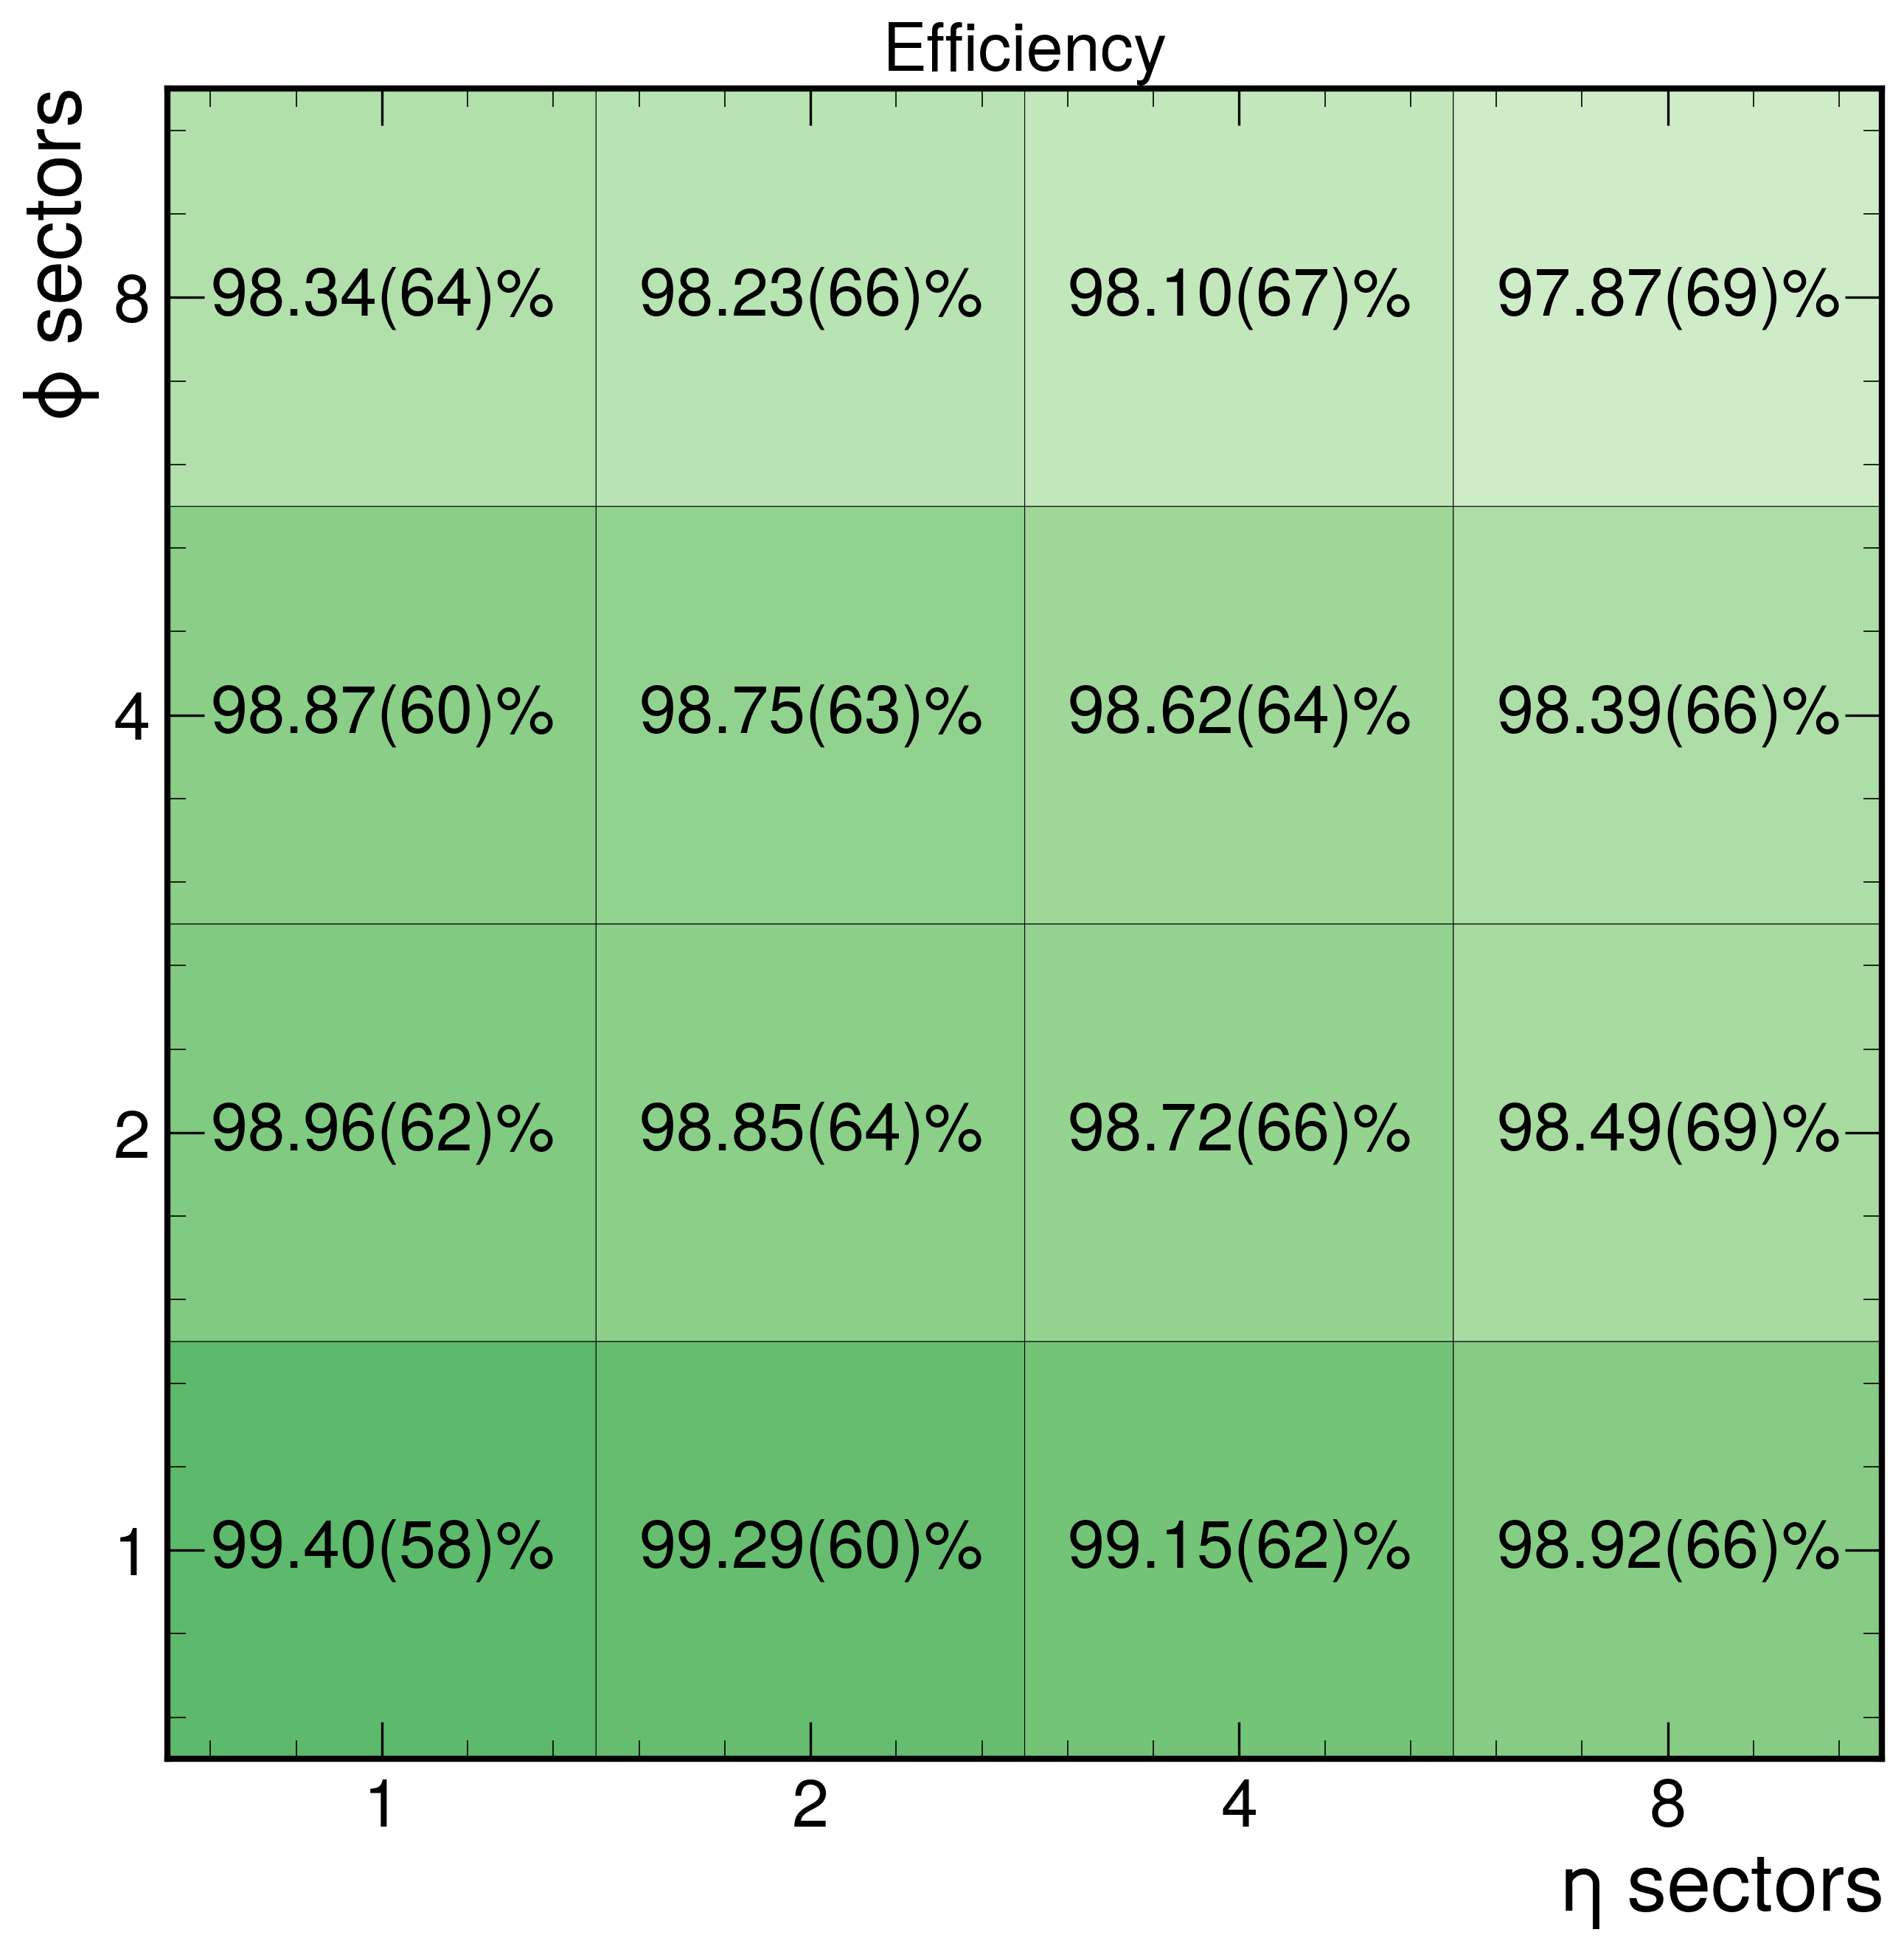

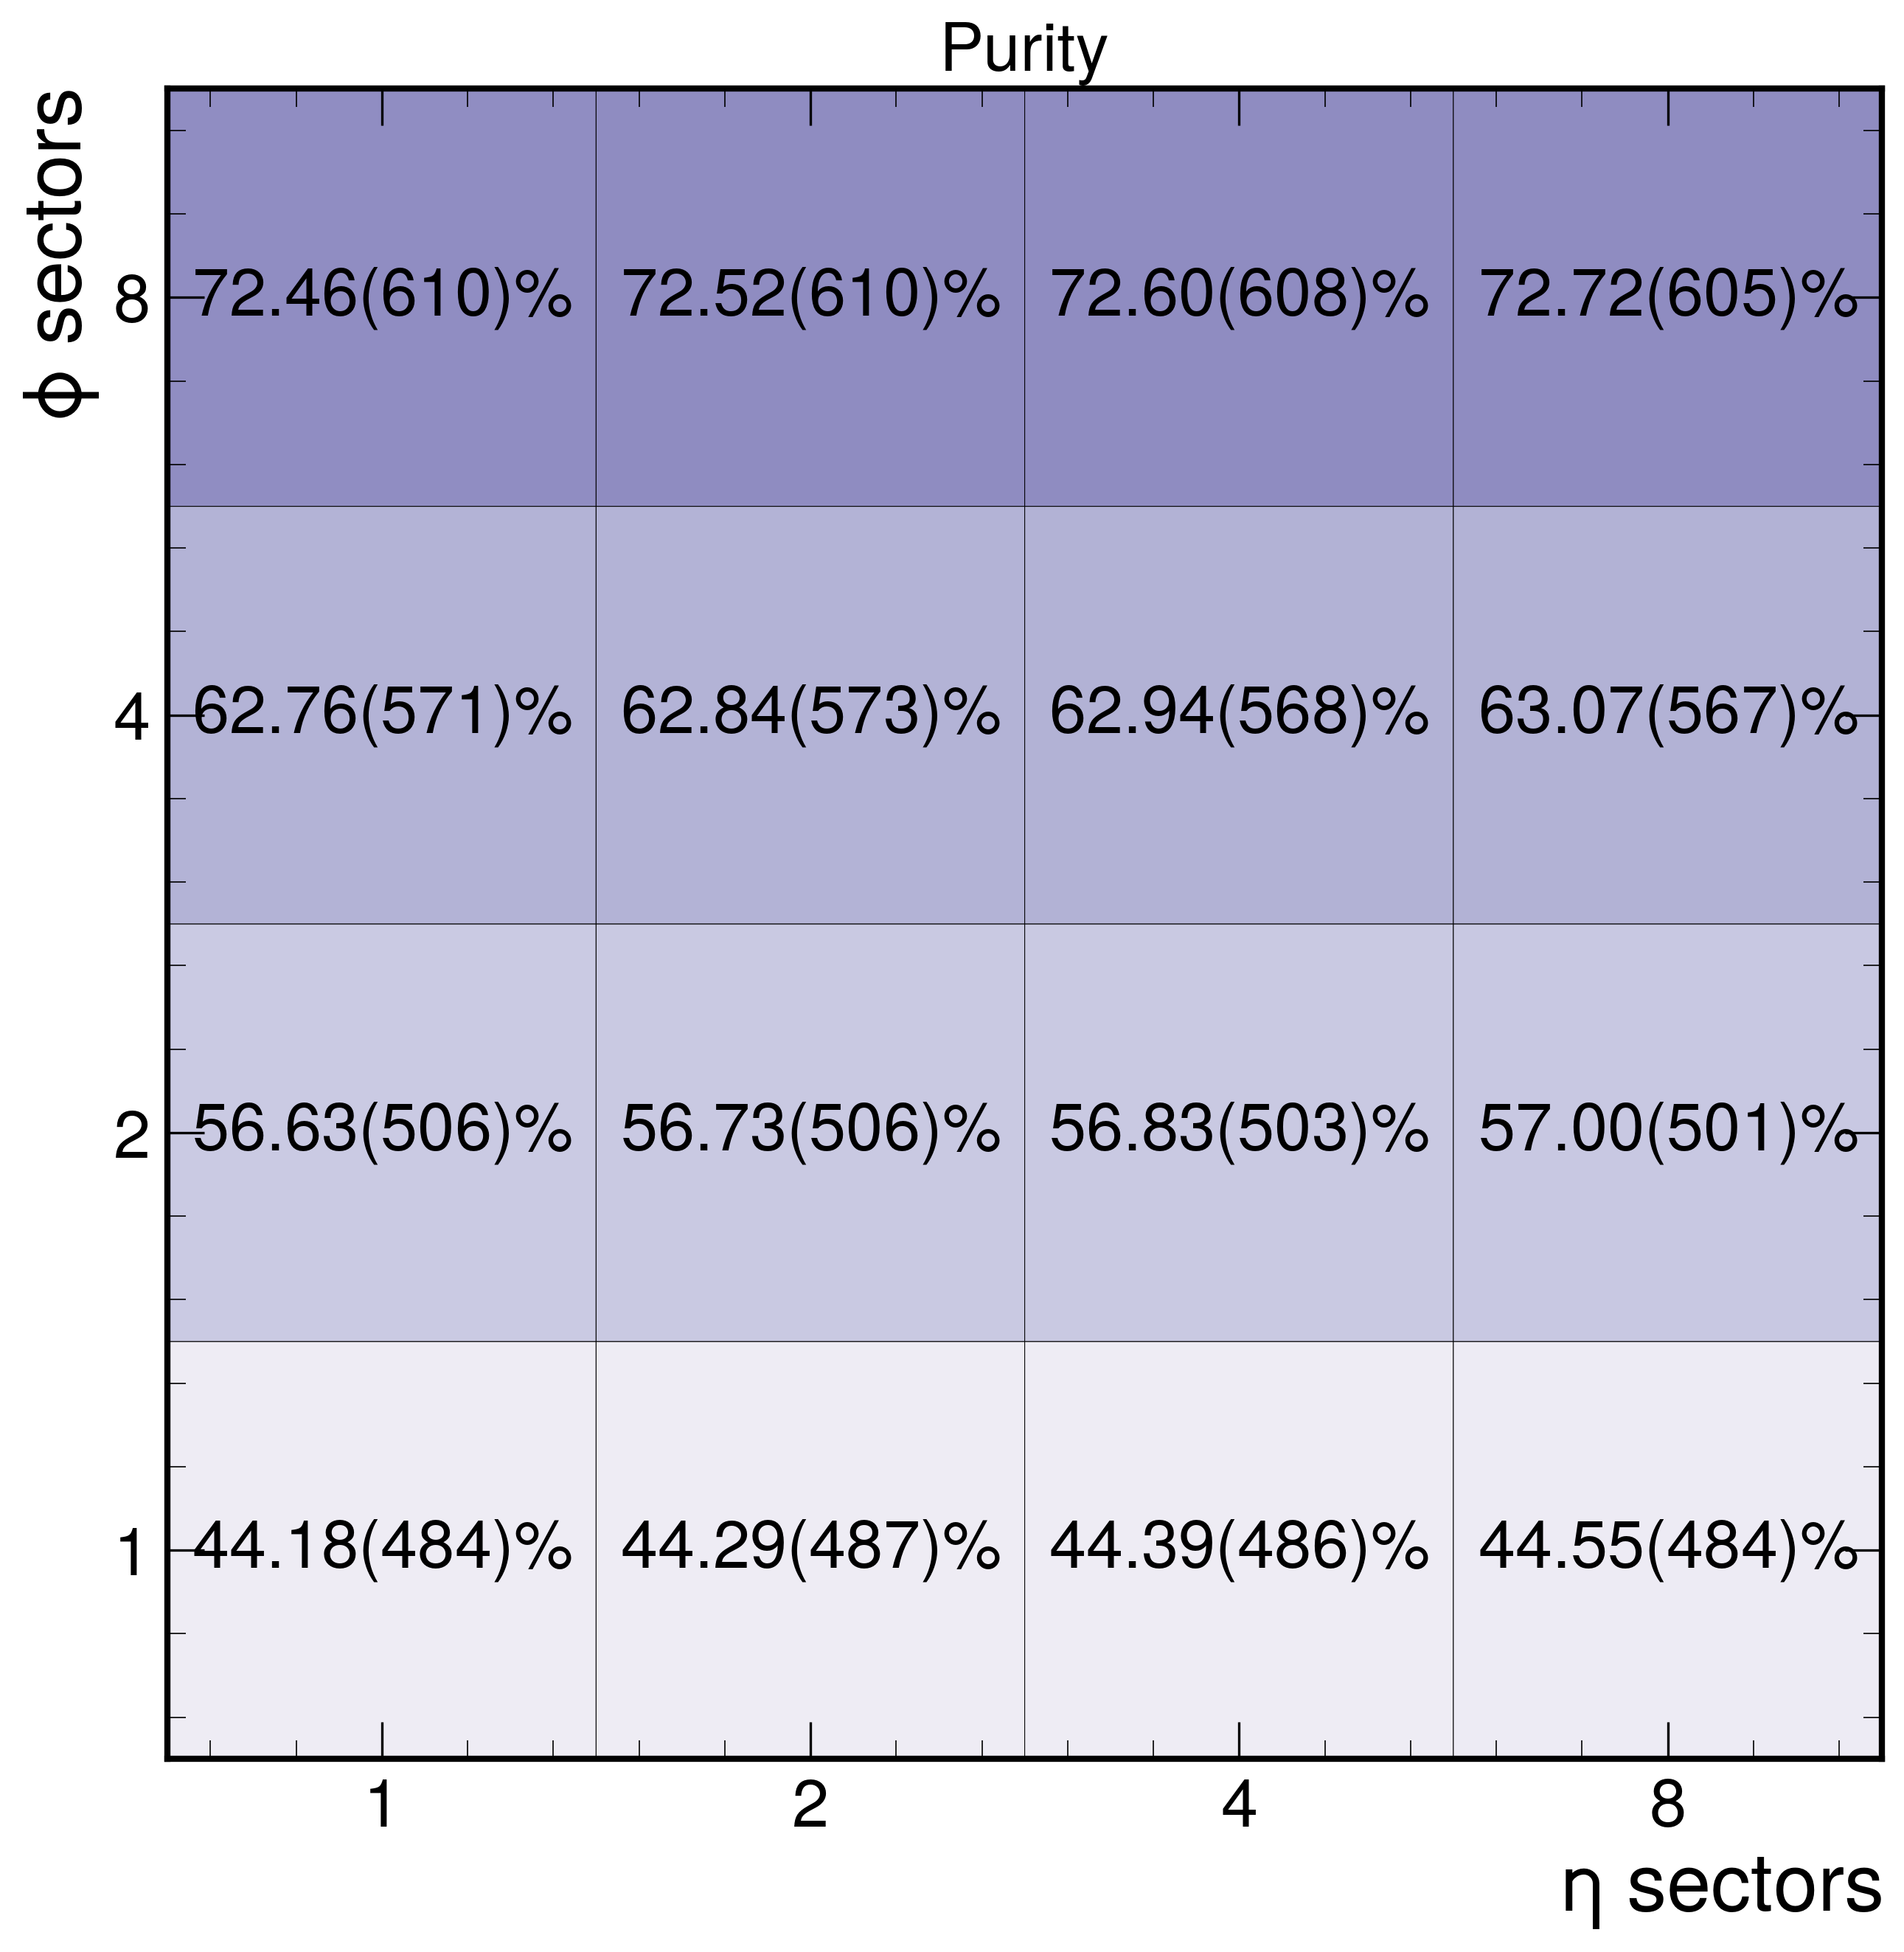

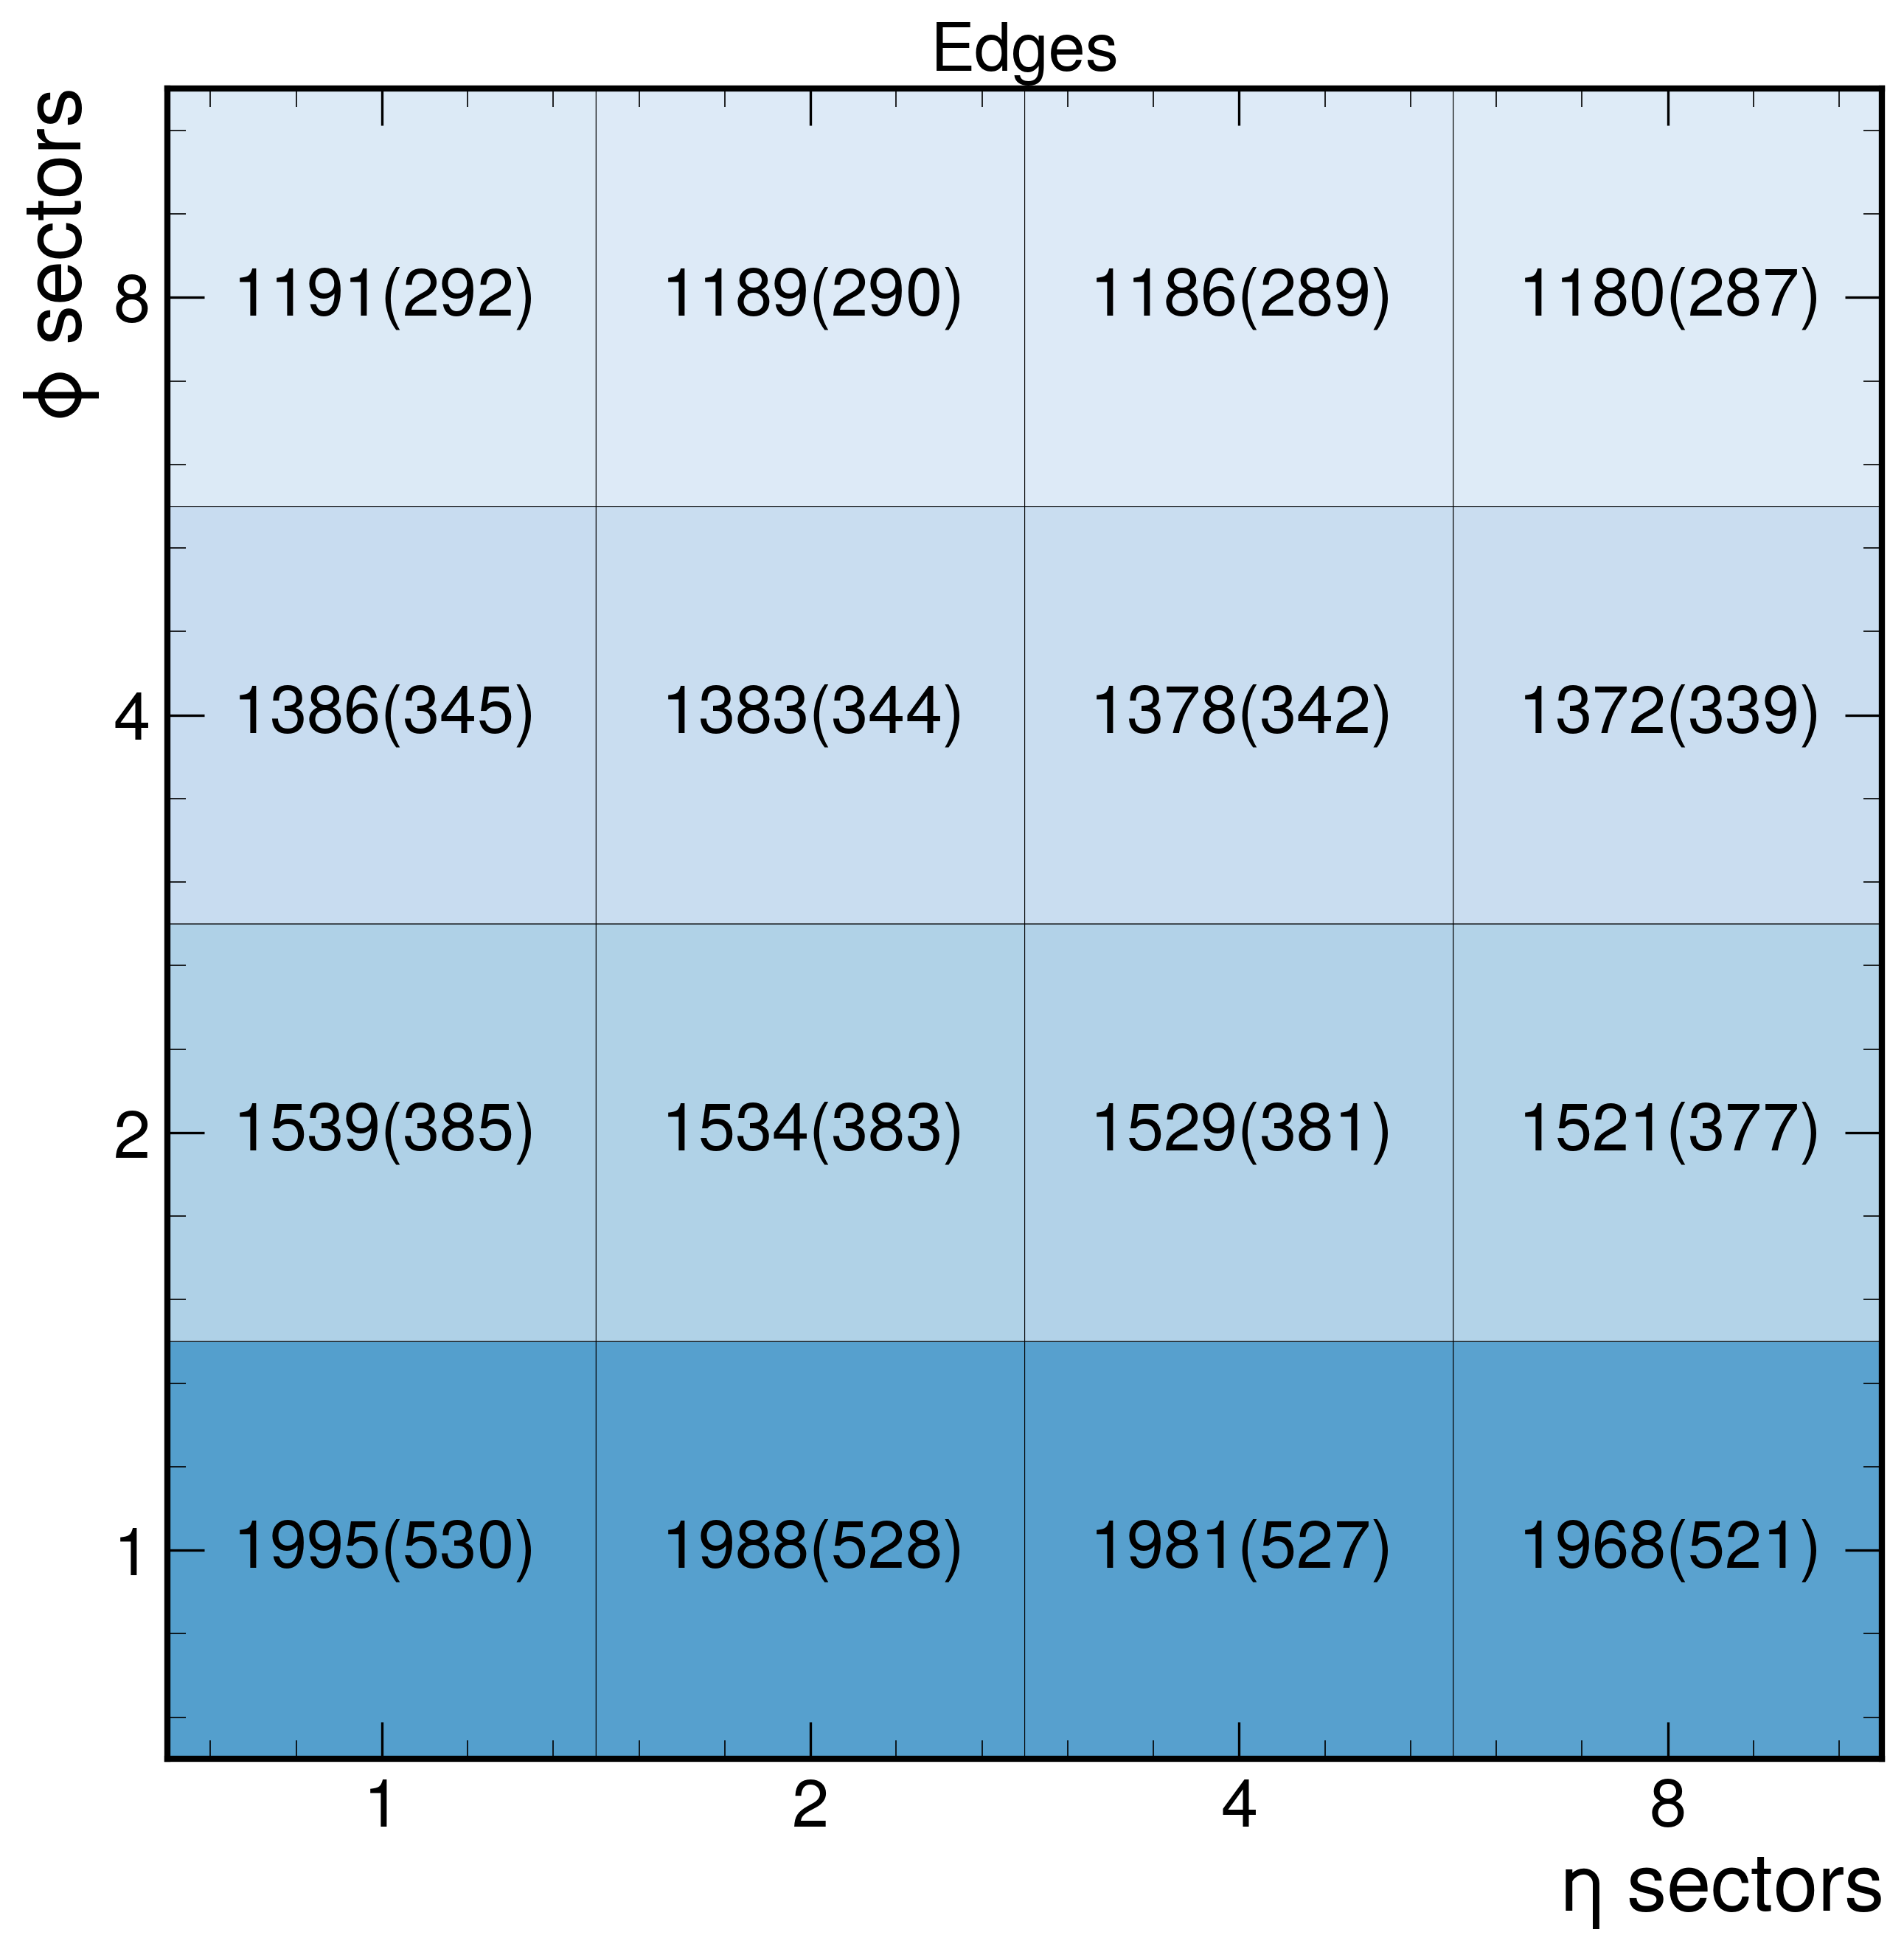

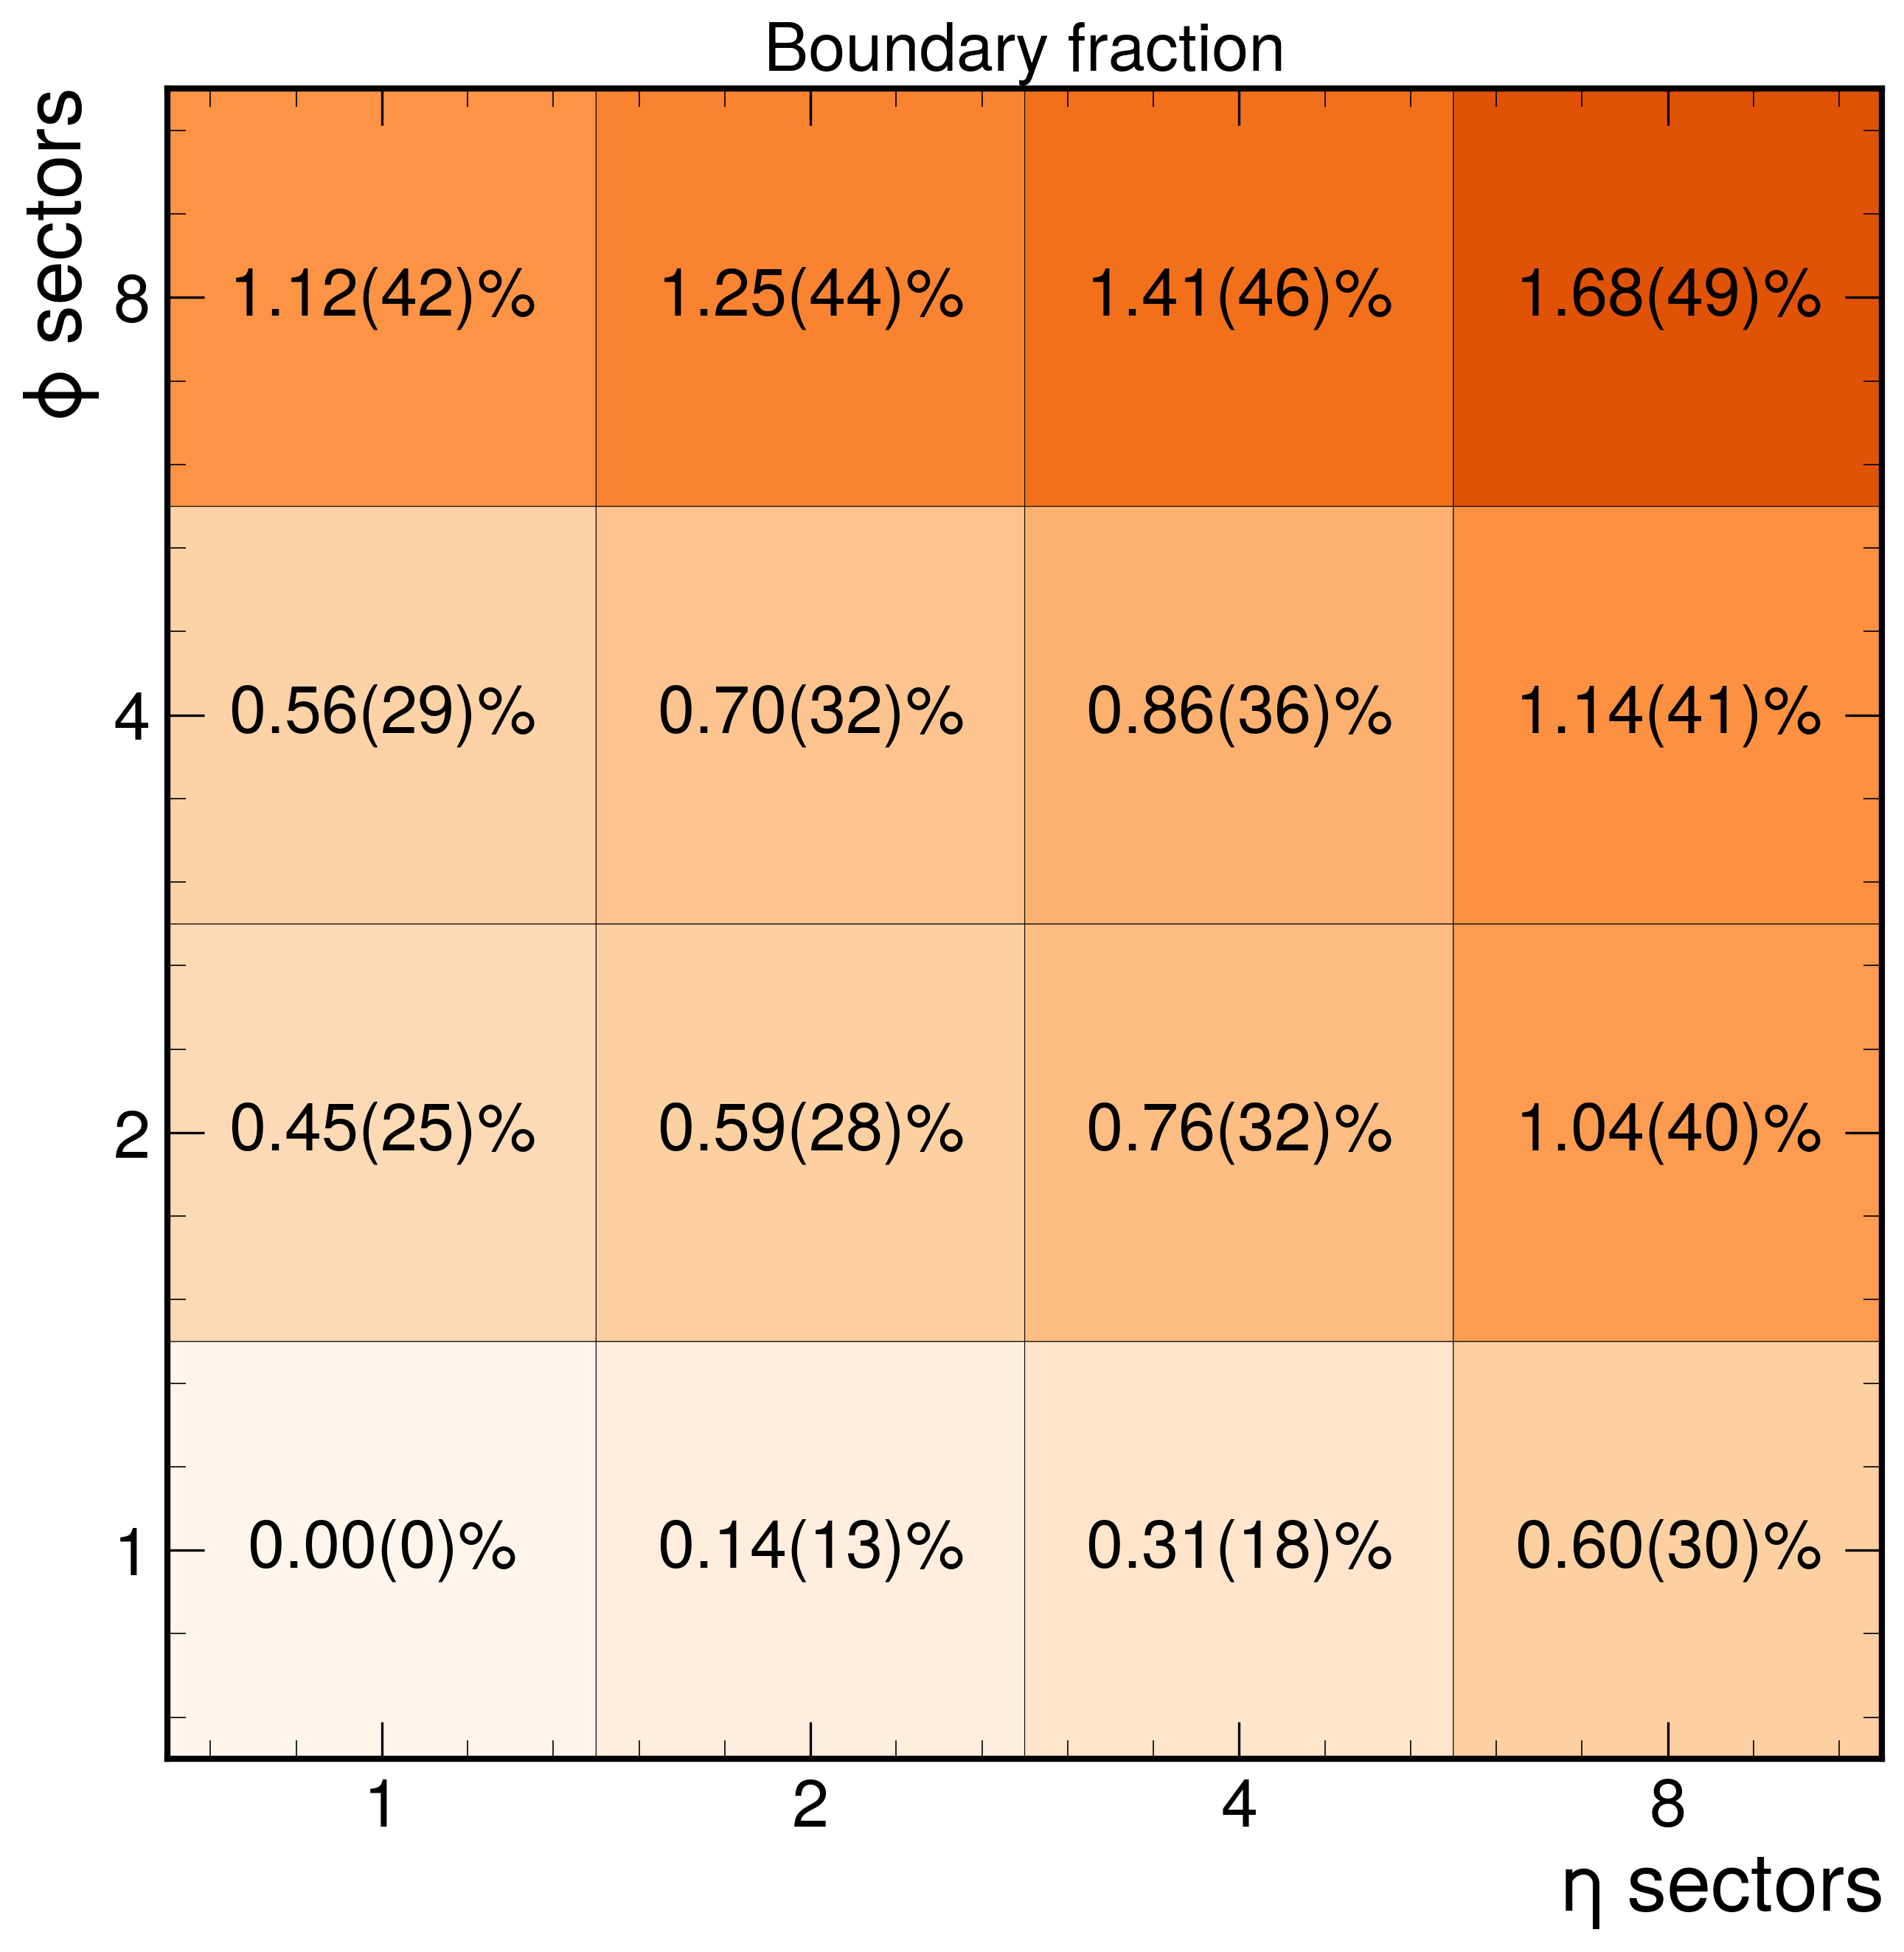

In [17]:
import mplhep as hep
plt.style.use(hep.style.ROOT)

def plot_hist2d(data, data_err, label, 
                fmt='percent', cmap='Purples', v=[0.1, 0.2]):
    fig, ax = plt.subplots(dpi=300)
    heatmap = ax.pcolor(data, edgecolors='k', 
                        cmap=cmap, vmin=v[0], vmax=v[1])
    ax.set_xticks(np.arange(1,len(n_eta_sectors)+1) - 0.5)
    ax.set_xticklabels(n_eta_sectors)
    ax.set_yticks(np.arange(1,len(n_phi_sectors)+1) - 0.5)
    ax.set_yticklabels(n_phi_sectors)
    ax.set_xlabel('$\eta$ sectors')
    ax.set_ylabel('$\phi$ sectors')
    labels = np.empty(data.shape, dtype="S16")
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if (fmt=='percent'):
                labels[i,j] = '${:.2f}({})\%$'.format(100*data[i,j], int(data_err[i,j]*10**4))
            else:
                labels[i,j] = '${:d}({})$'.format(int(data[i,j]), int(data_err[i,j]))
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            ax.text(x + 0.5, y + 0.5, labels[y, x].decode('ascii'),
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize='smaller')
    plt.title(label, fontsize='smaller')
    #plt.savefig(label.replace(' ','_')+'.png')
    #plt.savefig(label.replace(' ','_')+'.pdf')
    plt.show()

plot_hist2d(efficiencies, efficiencies_err, 'Efficiency', cmap='Greens', 
            v=[0.99*np.min(efficiencies), 1.02*np.max(efficiencies)])
plot_hist2d(purities, purities_err, 'Purity', cmap='Purples', 
            v=[0.8*np.min(purities), 1.4*np.max(purities)])
plot_hist2d(n_edges, n_edges_err, 'Edges', fmt='counts', cmap='Blues', 
            v=[0.8*np.min(n_edges), 1.4*np.max(n_edges)])
plot_hist2d(boundary_fractions, boundary_fractions_err, 'Boundary fraction', 
            cmap='Oranges', v=[0.8*np.min(boundary_fractions), 
                               1.4*np.max(boundary_fractions)])

In [16]:
print(n_edges, n_edges_err)
print(purities, purities_err)
print(efficiencies, efficiencies_err)

[[1995.74509804 1988.78431373 1981.25490196 1968.74509804]
 [1539.47058824 1534.84313725 1529.78431373 1521.        ]
 [1386.54901961 1383.11764706 1378.70588235 1372.1372549 ]
 [1191.60784314 1189.11764706 1186.03921569 1180.92156863]] [[530.88693243 528.95139751 527.02122006 521.55419485]
 [385.57628644 383.406423   381.32705913 377.92073035]
 [345.67440839 344.27887961 342.19116857 339.60299888]
 [292.36923193 290.98693772 289.52597911 287.53685821]]
[[0.4417901  0.44286386 0.44389826 0.44545792]
 [0.5662892  0.56727374 0.56825506 0.56999923]
 [0.62756449 0.62838068 0.62937546 0.63072081]
 [0.7245551  0.72516404 0.72596532 0.72718393]] [[0.04849952 0.04876257 0.04869274 0.04846982]
 [0.05064925 0.0506559  0.05032492 0.05012988]
 [0.05717782 0.05732196 0.05687687 0.05671903]
 [0.0610716  0.0610824  0.06083539 0.06052852]]
[[0.99398603 0.99287546 0.99152313 0.98921461]
 [0.98964899 0.98853843 0.98720635 0.98489783]
 [0.98865329 0.98754272 0.98621065 0.98390213]
 [0.98341107 0.98230051

[[46582.         36234.14285714 28929.14285714 24379.61904762
  20656.61904762]
 [43154.47619048 33644.76190476 26968.23809524 22789.42857143
  19386.38095238]
 [39948.47619048 31194.04761905 25106.42857143 21290.19047619
  18182.19047619]
 [36372.76190476 28501.52380952 23034.9047619  19635.66666667
  16837.        ]
 [33211.38095238 26141.61904762 21250.38095238 18202.19047619
  15699.47619048]] [[12934.58682684  9934.77961165  7763.21230938  6350.3016312
   5319.39224488]
 [11943.20094136  9153.61051277  7206.55550708  5885.81503497
   4969.45244158]
 [11051.69948844  8483.42536095  6685.21769116  5475.79049844
   4651.74589466]
 [ 9897.71157728  7619.81743075  6001.38594235  4939.23280464
   4190.16441319]
 [ 8943.12774452  6903.83528659  5473.6576217   4548.13966803
   3882.58110784]]
[[0.09591663 0.12233298 0.1520478  0.17896338 0.20980115]
 [0.10305244 0.13107169 0.16232119 0.19044082 0.22246157]
 [0.11074281 0.1406421  0.17342071 0.20277025 0.23599805]
 [0.1210353  0.15315532 0.18798231 0.21868654 0.25335473]
 [0.13165775 0.16587028 0.2025337  0.2345556  0.27021316]] [[0.01427353 0.01733543 0.020242   0.02259846 0.02542585]
 [0.01523951 0.01829854 0.02135755 0.02343521 0.02654426]
 [0.01590568 0.01907287 0.02203539 0.02407778 0.02724467]
 [0.01726159 0.02043518 0.02313724 0.02521014 0.02792206]
 [0.01792477 0.02125695 0.02433169 0.02639789 0.02916249]]
[[0.99675493 0.99104258 0.98636495 0.98115504 0.9760925 ]
 [0.99251987 0.9868344  0.98218755 0.97703702 0.97195728]
 [0.98828561 0.98267705 0.97804247 0.97294543 0.96788725]
 [0.98466252 0.97908546 0.97451618 0.96942208 0.96438336]
 [0.9797568  0.97420812 0.96967    0.96461012 0.9597139 ]] [[0.00125261 0.00207076 0.00290442 0.00264645 0.00349725]
 [0.00142362 0.00218213 0.00300465 0.00268546 0.00370771]
 [0.00149471 0.0022803  0.00308185 0.00280431 0.00383774]
 [0.00175188 0.00267115 0.00323988 0.0031318  0.00402075]
 [0.00169625 0.0022951  0.0030095  0.00283302 0.00373857]]